In [1]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Input,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as kb
from libs.feature_extraction import *

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [4]:
from matplotlib import font_manager, rc

path = 'c:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font',family=font_name)

plt.style.use('fivethirtyeight')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (20,10)

In [5]:
df = get_df('KOSPI', 'KOSPI-All', 'Add')
df

close      대비       기관      외국인       개인       기타     금융투자  \
date                                                                       
2009-01-12  1156.75  -24.21  -105369  -100171   207988    -3455   -15603   
2009-01-13  1167.71   10.96  -262362    30223   205073    26175    -2955   
2009-01-14  1182.68   14.97    -5903     9837    -6527     2182    34413   
2009-01-15  1111.34  -71.34  -406404  -182570   563538    21116   -66342   
2009-01-16  1135.20   23.86    45743  -307461   236397    25424     5946   
...             ...     ...      ...      ...      ...      ...      ...   
2021-02-24  2994.98  -75.11   -82457   631358   561382 -1115543   258837   
2021-02-25  3099.69  104.71   974913   974946 -1936090    -8948  1027147   
2021-02-26  3012.95  -86.74 -1030068 -2829962  3778506    68921  -891584   
2021-03-02  3043.87   30.92   437087   210377  -624895   -20336   553981   
2021-03-03  3082.99   39.12   691100   -20486  -655434   -14639   651262   

               보험      투신     사모  ...      low      volume     대비%  한국금리  \
date                              ...                                      
2009-01-12 -24208 -163712  -2151  ...  1150.41   352670000  -2.05%   2.5   
2009-01-13   4193 -253006 -16493  ...  1133.94   381510000   0.95%   2.5   
2009-01-14 -11807  -28832  -2658  ...  1151.80   358880000   1.28%   2.5   
2009-01-15  31493 -439477  -5603  ...  1108.15   366480000  -6.03%   2.5   
2009-01-16  -7465   74338   8534  ...  1109.69   335690000   2.15%   2.5   
...           ...     ...    ...  ...      ...         ...     ...   ...   
2021-02-24 -27013  -68615 -34963  ...  2993.46  1560000000  -2.45%   0.5   
2021-02-25 -52027    5798  34583  ...  3026.47  1280000000   3.50%   0.5   
2021-02-26  26706  -38506 -21671  ...  2988.28  1360000000  -2.80%   0.5   
2021-03-02 -41788    9477  25236  ...  3020.74  1750000000   1.03%   0.5   
2021-03-03   7841   60224  19232  ...  3029.37  2240000000   1.29%   0.5   

             천연가스  미국금리      다우존스       나스닥      구리    WTI  
date                                                        
2009-01-12  3.793  0.25   7223.98   1404.02  2.0370  67.16  
2009-01-13  3.550  0.25   7216.97   1462.11  2.0350  68.05  
2009-01-14  3.695  0.25   7395.70   1491.22  2.0280  68.38  
2009-01-15  3.604  0.25   7486.58   1483.48  2.0750  67.23  
2009-01-16  3.535  0.25   7400.80   1457.27  2.0700  63.35  
...           ...   ...       ...       ...     ...    ...  
2021-02-24  2.777  0.25  31402.01  13119.43  4.2635  63.53  
2021-02-25  2.771  0.25  30932.37  13192.34  4.0925  61.50  
2021-02-26  2.777  0.25  31535.51  13588.83  4.1130  60.64  
2021-03-02  2.839  0.25  31391.52  13358.79  4.2220  59.75  
2021-03-03  2.816  0.25  31270.09  12997.75  4.1420  61.28  

[3001 rows x 24 columns]

In [6]:
df = df[['close', '대비', 'open', 'low', 'high', 'volume', '대비%']]
df

close      대비     open      low     high      volume     대비%
date                                                                      
2009-01-12  1156.75  -24.21  1170.69  1150.41  1177.19   352670000  -2.05%
2009-01-13  1167.71   10.96  1147.99  1133.94  1168.04   381510000   0.95%
2009-01-14  1182.68   14.97  1161.01  1151.80  1184.52   358880000   1.28%
2009-01-15  1111.34  -71.34  1138.47  1108.15  1145.41   366480000  -6.03%
2009-01-16  1135.20   23.86  1120.69  1109.69  1135.79   335690000   2.15%
...             ...     ...      ...      ...      ...         ...     ...
2021-02-24  2994.98  -75.11  3070.58  2993.46  3092.05  1560000000  -2.45%
2021-02-25  3099.69  104.71  3026.47  3026.47  3099.80  1280000000   3.50%
2021-02-26  3012.95  -86.74  3089.49  2988.28  3089.49  1360000000  -2.80%
2021-03-02  3043.87   30.92  3021.68  3020.74  3096.50  1750000000   1.03%
2021-03-03  3082.99   39.12  3041.20  3029.37  3083.04  2240000000   1.29%

[3001 rows x 7 columns]

In [7]:
df.columns = ['close', 'ups and downs', 'open', 'low', 'high', 'volume', 'change']
df

close  ups and downs     open      low     high      volume  \
date                                                                        
2009-01-12  1156.75         -24.21  1170.69  1150.41  1177.19   352670000   
2009-01-13  1167.71          10.96  1147.99  1133.94  1168.04   381510000   
2009-01-14  1182.68          14.97  1161.01  1151.80  1184.52   358880000   
2009-01-15  1111.34         -71.34  1138.47  1108.15  1145.41   366480000   
2009-01-16  1135.20          23.86  1120.69  1109.69  1135.79   335690000   
...             ...            ...      ...      ...      ...         ...   
2021-02-24  2994.98         -75.11  3070.58  2993.46  3092.05  1560000000   
2021-02-25  3099.69         104.71  3026.47  3026.47  3099.80  1280000000   
2021-02-26  3012.95         -86.74  3089.49  2988.28  3089.49  1360000000   
2021-03-02  3043.87          30.92  3021.68  3020.74  3096.50  1750000000   
2021-03-03  3082.99          39.12  3041.20  3029.37  3083.04  2240000000   

            change  
date                
2009-01-12  -2.05%  
2009-01-13   0.95%  
2009-01-14   1.28%  
2009-01-15  -6.03%  
2009-01-16   2.15%  
...            ...  
2021-02-24  -2.45%  
2021-02-25   3.50%  
2021-02-26  -2.80%  
2021-03-02   1.03%  
2021-03-03   1.29%  

[3001 rows x 7 columns]

In [8]:
for i in range(len(df)):
    change = df.iloc[i]['change']
    change = change[:-1]
    volume = df.iloc[i]['volume']
    volume //= 1000
    df.loc[df.index[i], 'change'] = float(change)
    df.loc[df.index[i], 'volume'] = int(volume)

In [9]:
df = df.astype('float64')

In [10]:
df.dtypes

close            float64
ups and downs    float64
open             float64
low              float64
high             float64
volume           float64
change           float64
dtype: object

In [11]:
df

close  ups and downs     open      low     high     volume  \
date                                                                       
2009-01-12  1156.75         -24.21  1170.69  1150.41  1177.19   352670.0   
2009-01-13  1167.71          10.96  1147.99  1133.94  1168.04   381510.0   
2009-01-14  1182.68          14.97  1161.01  1151.80  1184.52   358880.0   
2009-01-15  1111.34         -71.34  1138.47  1108.15  1145.41   366480.0   
2009-01-16  1135.20          23.86  1120.69  1109.69  1135.79   335690.0   
...             ...            ...      ...      ...      ...        ...   
2021-02-24  2994.98         -75.11  3070.58  2993.46  3092.05  1560000.0   
2021-02-25  3099.69         104.71  3026.47  3026.47  3099.80  1280000.0   
2021-02-26  3012.95         -86.74  3089.49  2988.28  3089.49  1360000.0   
2021-03-02  3043.87          30.92  3021.68  3020.74  3096.50  1750000.0   
2021-03-03  3082.99          39.12  3041.20  3029.37  3083.04  2240000.0   

            change  
date                
2009-01-12   -2.05  
2009-01-13    0.95  
2009-01-14    1.28  
2009-01-15   -6.03  
2009-01-16    2.15  
...            ...  
2021-02-24   -2.45  
2021-02-25    3.50  
2021-02-26   -2.80  
2021-03-02    1.03  
2021-03-03    1.29  

[3001 rows x 7 columns]

In [12]:
df['next_close'] = df['close'].shift(-1)
df

close  ups and downs     open      low     high     volume  \
date                                                                       
2009-01-12  1156.75         -24.21  1170.69  1150.41  1177.19   352670.0   
2009-01-13  1167.71          10.96  1147.99  1133.94  1168.04   381510.0   
2009-01-14  1182.68          14.97  1161.01  1151.80  1184.52   358880.0   
2009-01-15  1111.34         -71.34  1138.47  1108.15  1145.41   366480.0   
2009-01-16  1135.20          23.86  1120.69  1109.69  1135.79   335690.0   
...             ...            ...      ...      ...      ...        ...   
2021-02-24  2994.98         -75.11  3070.58  2993.46  3092.05  1560000.0   
2021-02-25  3099.69         104.71  3026.47  3026.47  3099.80  1280000.0   
2021-02-26  3012.95         -86.74  3089.49  2988.28  3089.49  1360000.0   
2021-03-02  3043.87          30.92  3021.68  3020.74  3096.50  1750000.0   
2021-03-03  3082.99          39.12  3041.20  3029.37  3083.04  2240000.0   

            change  next_close  
date                            
2009-01-12   -2.05     1167.71  
2009-01-13    0.95     1182.68  
2009-01-14    1.28     1111.34  
2009-01-15   -6.03     1135.20  
2009-01-16    2.15     1150.65  
...            ...         ...  
2021-02-24   -2.45     3099.69  
2021-02-25    3.50     3012.95  
2021-02-26   -2.80     3043.87  
2021-03-02    1.03     3082.99  
2021-03-03    1.29         NaN  

[3001 rows x 8 columns]

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled, columns = df.columns, index=df.index)
df_scaled

close  ups and downs      open       low      high    volume  \
date                                                                          
2009-01-12  0.062981       0.418853  0.080014  0.073251  0.066163  0.055859   
2009-01-13  0.067985       0.553568  0.069743  0.065602  0.062073  0.064621   
2009-01-14  0.074820       0.568928  0.075634  0.073896  0.069440  0.057745   
2009-01-15  0.042248       0.238327  0.065436  0.053624  0.051957  0.060055   
2009-01-16  0.053142       0.602980  0.057391  0.054339  0.047657  0.050699   
...              ...            ...       ...       ...       ...       ...   
2021-02-24  0.902287       0.223886  0.939650  0.929229  0.922139  0.422698   
2021-02-25  0.950095       0.912667  0.919692  0.944560  0.925603  0.337622   
2021-02-26  0.910491       0.179339  0.948206  0.926823  0.920994  0.361929   
2021-03-02  0.924609       0.630023  0.917524  0.941899  0.924128  0.480428   
2021-03-03  0.942470       0.661432  0.926357  0.945907  0.918111  0.629311   

              change  next_close  
date                              
2009-01-12  0.373161    0.067985  
2009-01-13  0.549735    0.074820  
2009-01-14  0.569158    0.042248  
2009-01-15  0.138905    0.053142  
2009-01-16  0.620365    0.060196  
...              ...         ...  
2021-02-24  0.349617    0.950095  
2021-02-25  0.699823    0.910491  
2021-02-26  0.329017    0.924609  
2021-03-02  0.554444    0.942470  
2021-03-03  0.569747         NaN  

[3001 rows x 8 columns]

In [14]:
train_len = int(3001 * 0.7)
train = df_scaled[:train_len]
test = df_scaled[train_len:]
train.shape, test.shape

((2100, 8), (901, 8))

In [15]:
def windowing_dataset(feature, label, window_size):
    feature_list = []
    label_list = []
    
    for i in range(len(feature) - window_size):
        feature_list.append(np.array(feature.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [16]:
train_test_set = []
data_list = [train, test]
feature_list = df.columns.difference(['next_close'])
target = 'next_close'
feature_list

Index(['change', 'close', 'high', 'low', 'open', 'ups and downs', 'volume'], dtype='object')

In [17]:
for data in data_list:
    feature, label = data[feature_list], data[target]
    train_test_set.append(windowing_dataset(feature, label, 10))
(x_train, y_train), (x_test, y_test) = train_test_set
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2090, 10, 7), (2090,), (891, 10, 7), (891,))

In [18]:
x_test = x_test[:-1]
y_test = y_test[:-1]
x_test.shape, y_test.shape

((890, 10, 7), (890,))

In [19]:
def inverse_data(data, max_value, min_value):
    data = (data * (max_value - min_value)) + min_value
    return data

In [20]:
def MAE(d_max, d_min):
    def loss(y_test, y_pred):
        y_test = inverse_data(y_test, d_max, d_min)
        y_pred = inverse_data(y_pred, d_max, d_min)
        mae_loss = kb.mean(kb.abs(y_pred - y_test))
        return mae_loss
    loss.__name__ = 'mae'
    return loss

def RMSE(d_max, d_min):
    def loss(y_test, y_pred):
        y_test = inverse_data(y_test, d_max, d_min)
        y_pred = inverse_data(y_pred, d_max, d_min)
        rmse_loss = kb.sqrt(kb.mean(kb.square(y_pred - y_test)))
        return rmse_loss
    loss.__name__ = 'rmse'
    return loss

In [21]:
max_v, min_v = scaler.data_max_[-1], scaler.data_min_[-1]
max_v, min_v

(3208.99, 1018.81)

In [22]:
epochs = [x for x in range(10, 101, 10)]
epochs

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [23]:
from tensorflow.keras.utils import plot_model

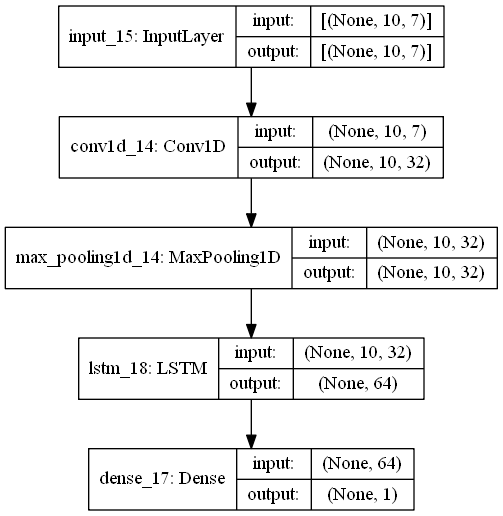

In [46]:
model = Sequential()
model.add(Input(shape=(10, 7)))
model.add(Conv1D(32, 1, activation='tanh', padding='same'))
model.add(MaxPooling1D(1, padding='same'))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(1))
plot_model(model, show_shapes=True)

In [26]:
model_list = []

for epoch in epochs:
    print(epoch)
    model = Sequential()
    model.add(Input(shape=(10, 7)))
    model.add(Conv1D(32, 1, activation='tanh', padding='same'))
    model.add(MaxPooling1D(1, padding='same'))
    model.add(LSTM(64, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss=RMSE(max_v, min_v), optimizer=Adam(lr=0.001),
                 metrics=[MAE(max_v, min_v)])
    model.fit(x_train, y_train, epochs=epoch, batch_size=64)
    model_list.append(model)
    print('\n\n')

10
Epoch 1/10
33/33 [==============================] - 3s 10ms/step - loss: 339.7156 - mae: 324.1088
Epoch 2/10
33/33 [==============================] - 0s 8ms/step - loss: 44.0449 - mae: 34.9707
Epoch 3/10
33/33 [==============================] - 0s 7ms/step - loss: 36.0009 - mae: 27.3647
Epoch 4/10
33/33 [==============================] - 0s 7ms/step - loss: 32.8689 - mae: 24.8105A: 0s - loss: 31.8304 - mae: 23.6
Epoch 5/10
33/33 [==============================] - 0s 7ms/step - loss: 30.2943 - mae: 23.0098
Epoch 6/10
33/33 [==============================] - 0s 7ms/step - loss: 32.6624 - mae: 25.0161
Epoch 7/10
33/33 [==============================] - 0s 7ms/step - loss: 29.0795 - mae: 22.0166
Epoch 8/10
33/33 [==============================] - 0s 7ms/step - loss: 32.1270 - mae: 24.3105
Epoch 9/10
33/33 [==============================] - 0s 7ms/step - loss: 28.2732 - mae: 21.2957
Epoch 10/10
33/33 [==============================] - 0s 7ms/step - loss: 29.4410 - mae: 22.5367



20
Epoc

33/33 [==============================] - 0s 7ms/step - loss: 27.4994 - mae: 20.9409
Epoch 18/60
33/33 [==============================] - 0s 8ms/step - loss: 29.6586 - mae: 23.4863
Epoch 19/60
33/33 [==============================] - 0s 8ms/step - loss: 26.2184 - mae: 20.1632
Epoch 20/60
33/33 [==============================] - 0s 9ms/step - loss: 27.1102 - mae: 20.4651
Epoch 21/60
33/33 [==============================] - 0s 7ms/step - loss: 28.8898 - mae: 22.2539
Epoch 22/60
33/33 [==============================] - 0s 8ms/step - loss: 26.8507 - mae: 20.1083
Epoch 23/60
33/33 [==============================] - 0s 7ms/step - loss: 31.4819 - mae: 25.0705
Epoch 24/60
33/33 [==============================] - 0s 7ms/step - loss: 27.5020 - mae: 20.6929
Epoch 25/60
33/33 [==============================] - 0s 7ms/step - loss: 27.9597 - mae: 20.9765
Epoch 26/60
33/33 [==============================] - 0s 7ms/step - loss: 27.9463 - mae: 21.0792
Epoch 27/60
33/33 [==============================] -

33/33 [==============================] - 0s 7ms/step - loss: 27.9670 - mae: 21.8316
Epoch 55/80
33/33 [==============================] - 0s 8ms/step - loss: 26.6660 - mae: 19.9487
Epoch 56/80
33/33 [==============================] - 0s 8ms/step - loss: 30.2906 - mae: 23.5425
Epoch 57/80
33/33 [==============================] - 0s 7ms/step - loss: 26.2268 - mae: 20.1078
Epoch 58/80
33/33 [==============================] - 0s 6ms/step - loss: 27.6482 - mae: 20.6599
Epoch 59/80
33/33 [==============================] - 0s 7ms/step - loss: 27.5071 - mae: 20.7739
Epoch 60/80
33/33 [==============================] - 0s 7ms/step - loss: 26.7645 - mae: 20.2957
Epoch 61/80
33/33 [==============================] - 0s 8ms/step - loss: 28.0533 - mae: 21.5741
Epoch 62/80
33/33 [==============================] - 0s 7ms/step - loss: 27.8886 - mae: 21.0826
Epoch 63/80
33/33 [==============================] - 0s 8ms/step - loss: 27.9831 - mae: 21.5081
Epoch 64/80
33/33 [==============================] -

33/33 [==============================] - 0s 8ms/step - loss: 28.3280 - mae: 21.3692
Epoch 49/100
33/33 [==============================] - 0s 6ms/step - loss: 27.7851 - mae: 21.1074A: 0s - loss: 27.7285 - mae: 21.059
Epoch 50/100
33/33 [==============================] - 0s 6ms/step - loss: 30.4820 - mae: 24.1309
Epoch 51/100
33/33 [==============================] - 0s 7ms/step - loss: 28.1422 - mae: 21.3081
Epoch 52/100
33/33 [==============================] - 0s 8ms/step - loss: 27.5986 - mae: 20.6892A: 0s - loss: 27.8537 - mae: 20.6
Epoch 53/100
33/33 [==============================] - 0s 7ms/step - loss: 27.3076 - mae: 20.0250
Epoch 54/100
33/33 [==============================] - 0s 7ms/step - loss: 25.9921 - mae: 19.6854
Epoch 55/100
33/33 [==============================] - 0s 7ms/step - loss: 25.1526 - mae: 19.2530
Epoch 56/100
33/33 [==============================] - 0s 8ms/step - loss: 26.5424 - mae: 20.2704
Epoch 57/100
33/33 [==============================] - 0s 7ms/step - loss

In [39]:
from sklearn.metrics import r2_score
def get_loss(y_test, pred):
    rmse = round(np.sqrt(np.mean((pred - y_test) ** 2)), 4)
    mae = round(np.mean(np.abs(pred - y_test)), 4)
    r2 = r2_score(y_test, pred)
    
    return rmse, mae, r2

28/28 [==============================] - 0s 5ms/step - loss: 40.7701 - mae: 34.9453
(49.9149, 34.3575, 0.965740329342745)


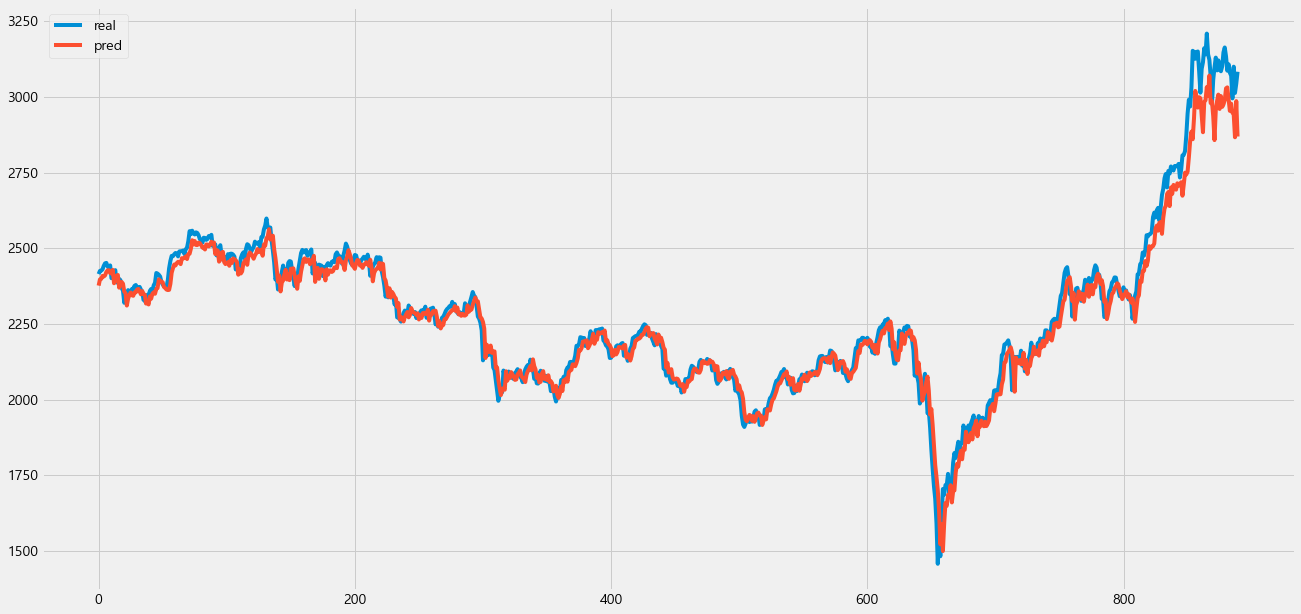

28/28 [==============================] - 0s 5ms/step - loss: 44.7423 - mae: 39.2128
(57.3933, 38.3497, 0.9547054404823299)


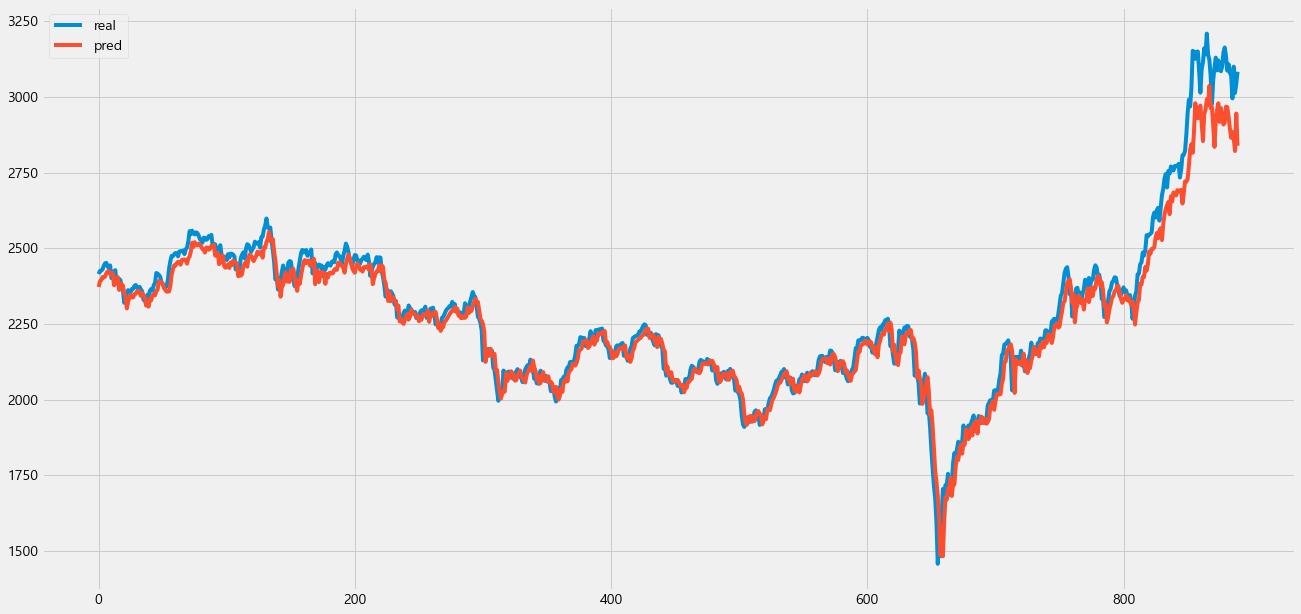

28/28 [==============================] - 0s 6ms/step - loss: 55.6497 - mae: 49.8712
(64.539, 49.0954, 0.9427246668819609)


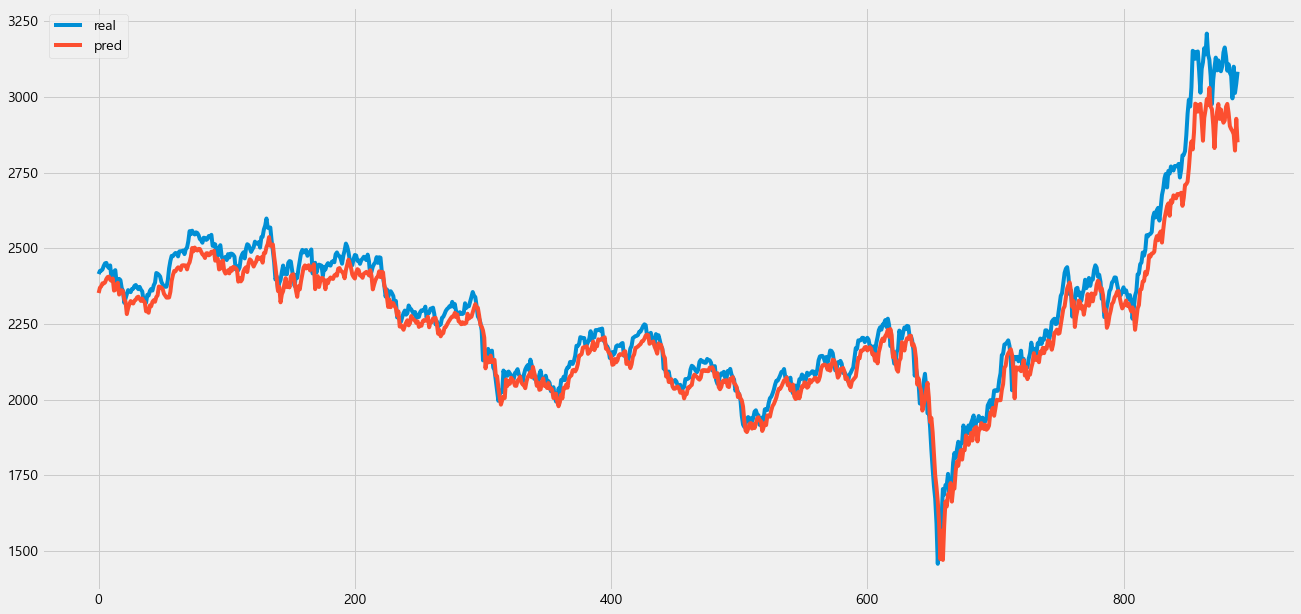

28/28 [==============================] - 0s 5ms/step - loss: 43.2328 - mae: 37.4948
(52.6388, 36.8196, 0.9618990938065767)


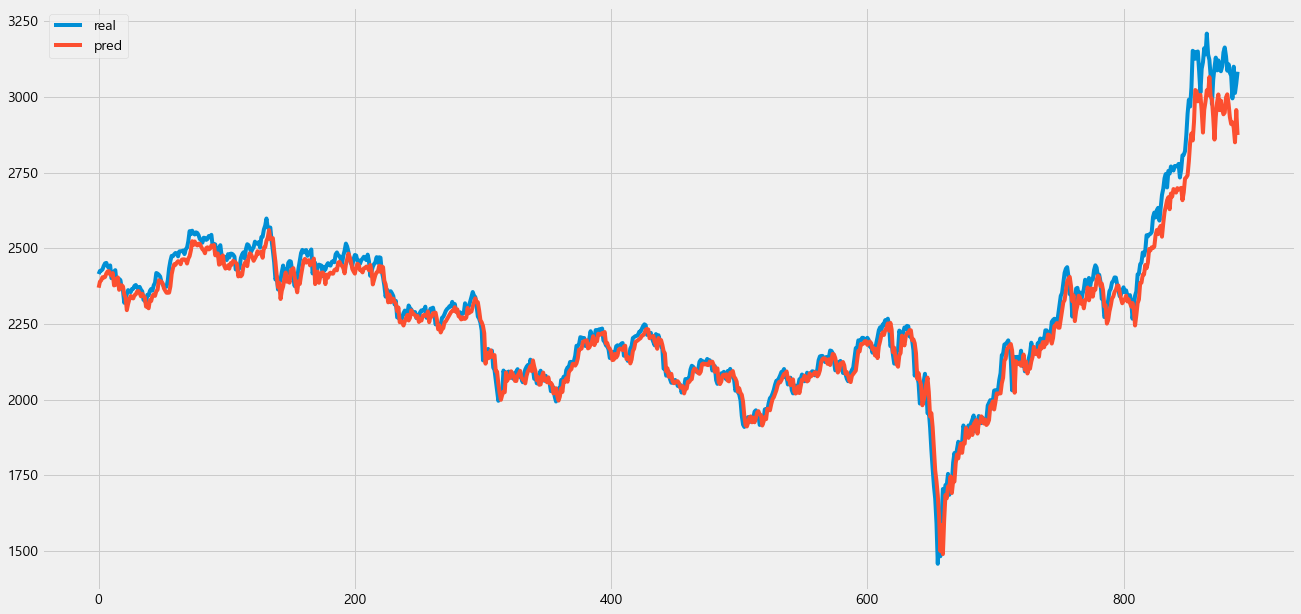

28/28 [==============================] - 0s 5ms/step - loss: 38.3839 - mae: 30.8932
(43.976, 30.5249, 0.9734077931115123)


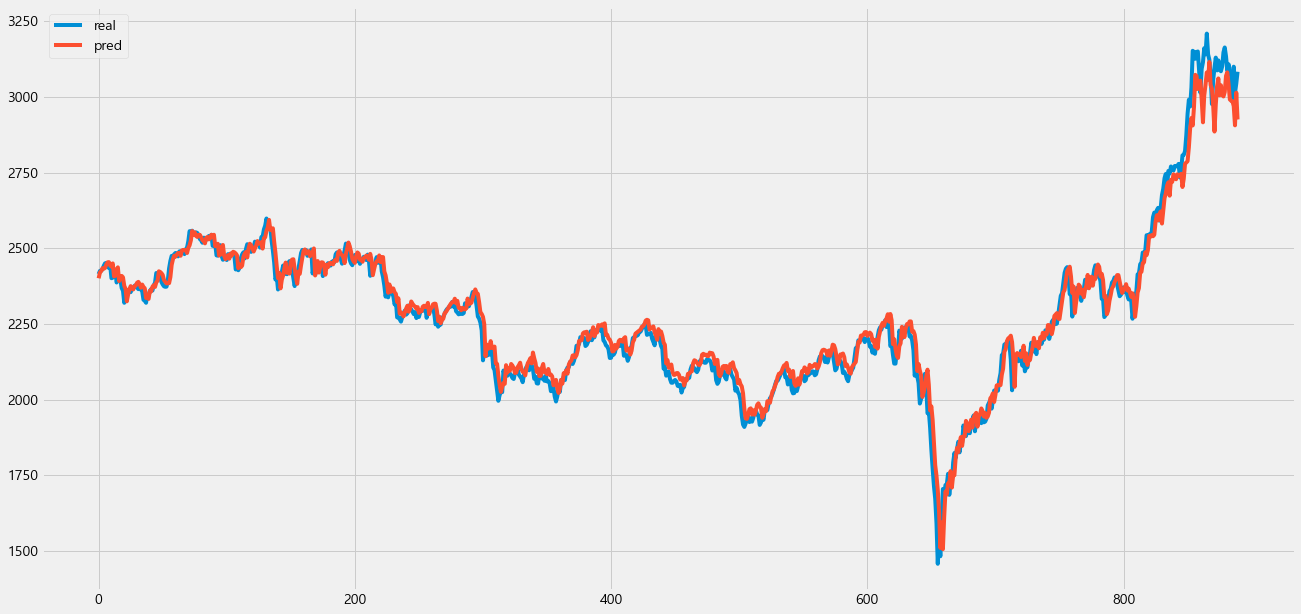

28/28 [==============================] - 0s 5ms/step - loss: 37.1439 - mae: 30.7966
(44.9221, 30.302, 0.9722512607467785)


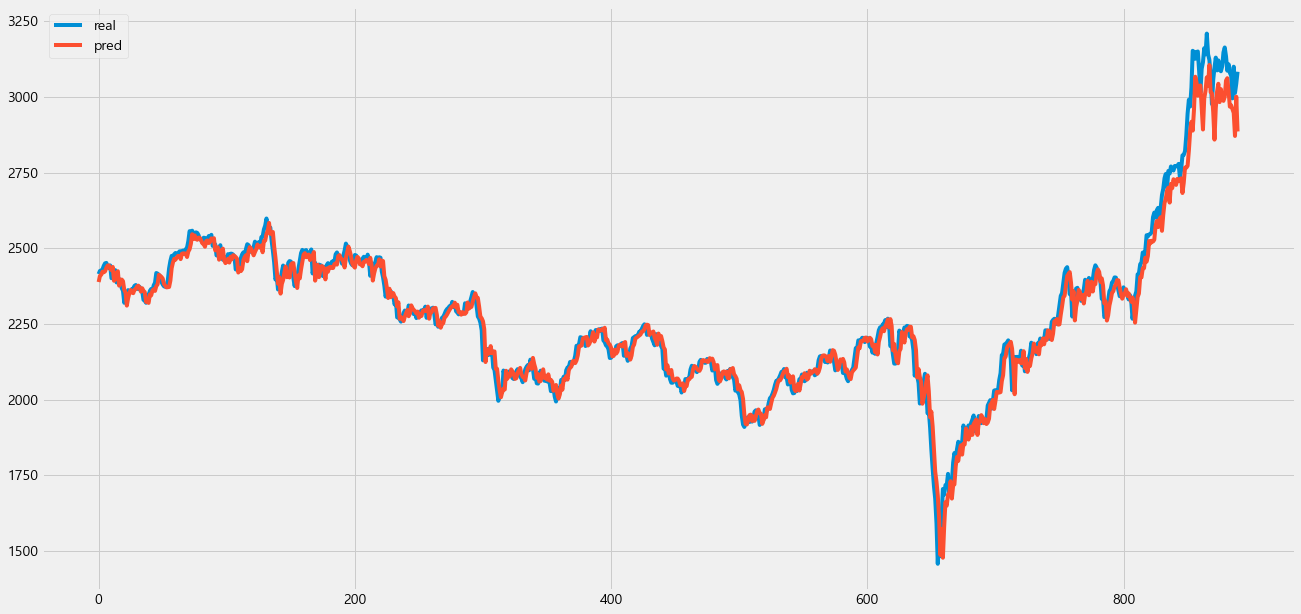

28/28 [==============================] - 0s 5ms/step - loss: 36.0847 - mae: 28.7394
(41.1713, 28.4408, 0.9766915452942557)


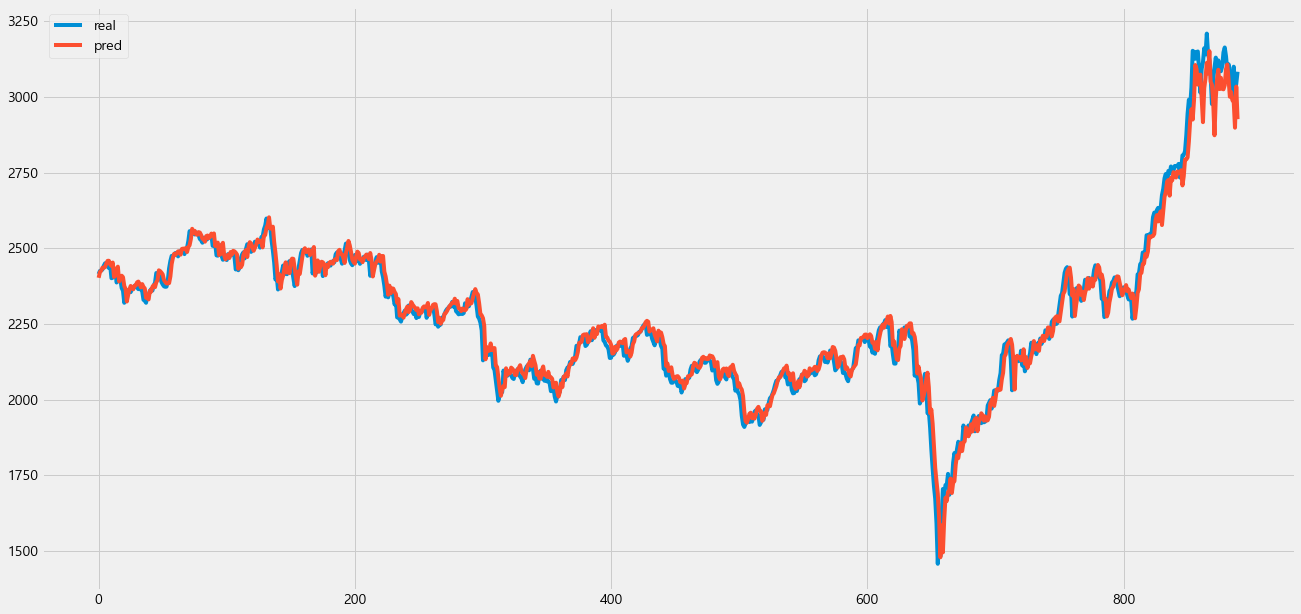

28/28 [==============================] - 0s 4ms/step - loss: 45.6945 - mae: 39.6468
(54.3124, 38.9919, 0.9594378432409957)


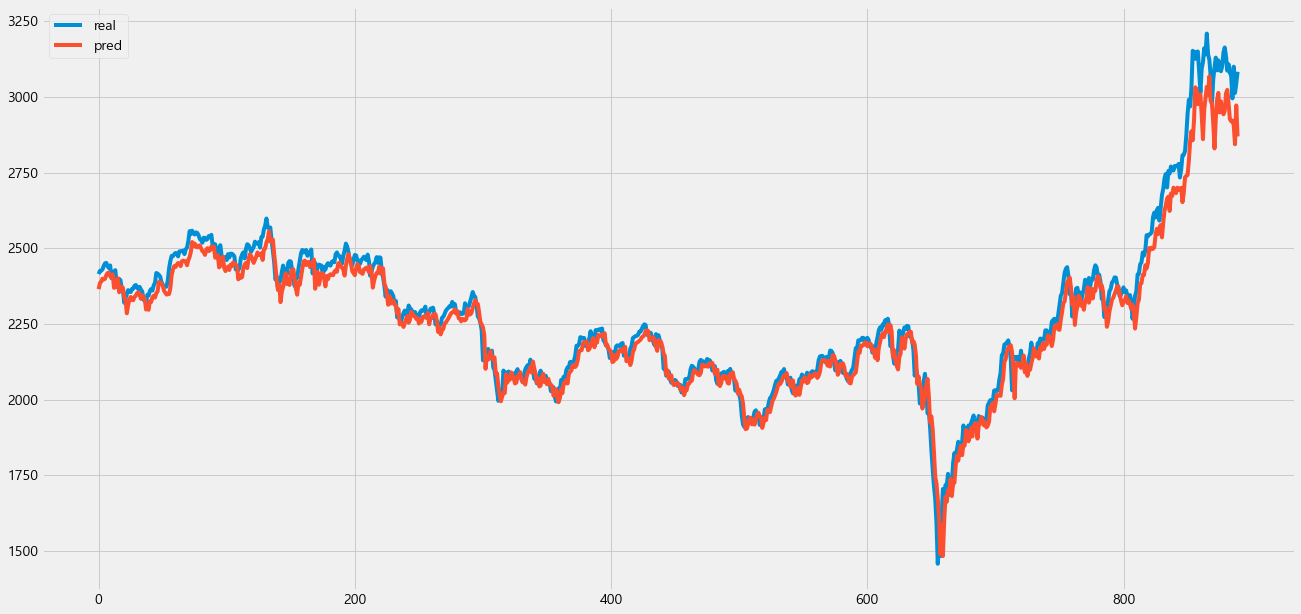

28/28 [==============================] - 0s 4ms/step - loss: 39.1882 - mae: 33.0531
(45.706, 32.6378, 0.9712743074122374)


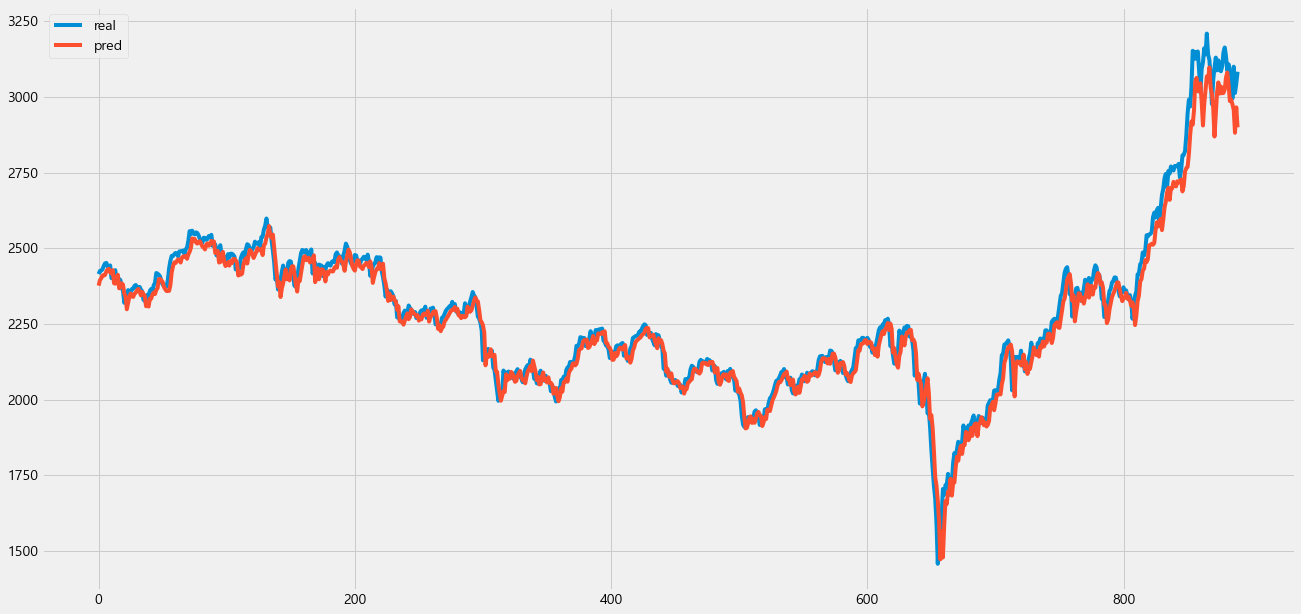

28/28 [==============================] - 0s 5ms/step - loss: 36.1081 - mae: 29.7726
(41.88, 29.4885, 0.975882274841624)


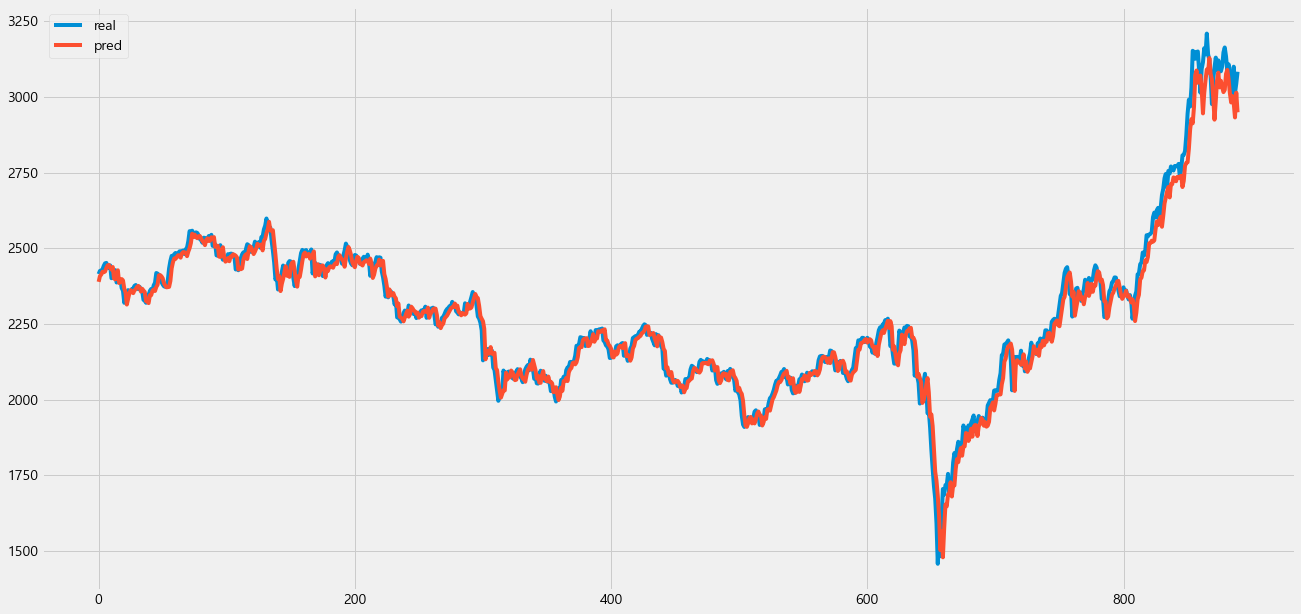

In [42]:
max_v, min_v = scaler.data_max_[-1], scaler.data_min_[-1]
loss_list = []

for epoch, model in zip(epochs,model_list):
    model.evaluate(x_test, y_test)
    pred = model.predict(x_test)
    pred = np.squeeze(pred)

    actual = inverse_data(y_test, max_v, min_v)
    pred = inverse_data(pred, max_v, min_v)
    
    rmse, mae, r2 = get_loss(actual, pred)
    loss_list.append([epoch, rmse, mae, r2])
    print(get_loss(actual, pred))
    plt.plot(actual)
    plt.plot(pred)
    plt.legend(['real', 'pred'])
    plt.show()

In [43]:
loss_list

[[10, 49.9149, 34.3575, 0.965740329342745],
 [20, 57.3933, 38.3497, 0.9547054404823299],
 [30, 64.539, 49.0954, 0.9427246668819609],
 [40, 52.6388, 36.8196, 0.9618990938065767],
 [50, 43.976, 30.5249, 0.9734077931115123],
 [60, 44.9221, 30.302, 0.9722512607467785],
 [70, 41.1713, 28.4408, 0.9766915452942557],
 [80, 54.3124, 38.9919, 0.9594378432409957],
 [90, 45.706, 32.6378, 0.9712743074122374],
 [100, 41.88, 29.4885, 0.975882274841624]]

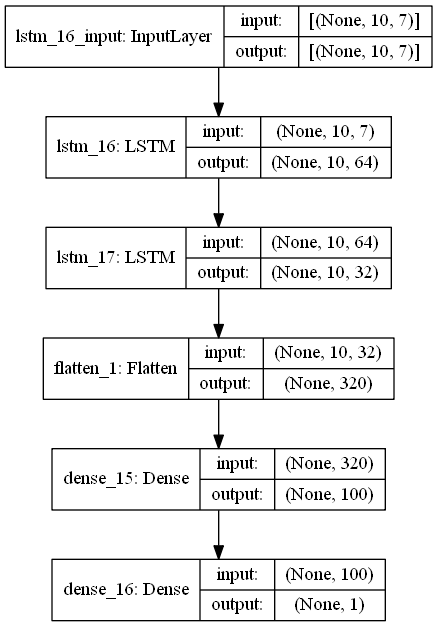

In [45]:
model = Sequential()
model.add(LSTM(64, input_shape=(10,7), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(1))
plot_model(model, show_shapes=True)

In [47]:
model_list = []

for epoch in epochs:
    print(epoch)
    model = Sequential()
    model.add(LSTM(64, input_shape=(10,7), return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(1))
    model.compile(loss=RMSE(max_v, min_v), optimizer=Adam(lr=0.001),
                 metrics=[MAE(max_v, min_v)])
    model.fit(x_train, y_train, epochs=epoch, batch_size=64)
    model_list.append(model)
    print('\n\n')

10
Epoch 1/10
33/33 [==============================] - 4s 11ms/step - loss: 251.6728 - mae: 234.9640
Epoch 2/10
33/33 [==============================] - 0s 10ms/step - loss: 51.1558 - mae: 38.9978
Epoch 3/10
33/33 [==============================] - 0s 9ms/step - loss: 46.4242 - mae: 35.0853
Epoch 4/10
33/33 [==============================] - 0s 9ms/step - loss: 42.6324 - mae: 32.1445
Epoch 5/10
33/33 [==============================] - 0s 9ms/step - loss: 42.3939 - mae: 32.2810
Epoch 6/10
33/33 [==============================] - 0s 9ms/step - loss: 41.1774 - mae: 31.9105
Epoch 7/10
33/33 [==============================] - 0s 9ms/step - loss: 41.5437 - mae: 32.6618
Epoch 8/10
33/33 [==============================] - 0s 10ms/step - loss: 43.6504 - mae: 34.7161
Epoch 9/10
33/33 [==============================] - 0s 9ms/step - loss: 37.1616 - mae: 29.2688
Epoch 10/10
33/33 [==============================] - 0s 10ms/step - loss: 34.1304 - mae: 26.4459



20
Epoch 1/20
33/33 [================

33/33 [==============================] - 0s 9ms/step - loss: 37.6287 - mae: 30.2982
Epoch 18/60
33/33 [==============================] - 0s 8ms/step - loss: 34.4934 - mae: 27.2659A: 0s - loss: 34.4373 - mae: 27.
Epoch 19/60
33/33 [==============================] - 0s 9ms/step - loss: 32.3674 - mae: 25.2218
Epoch 20/60
33/33 [==============================] - 0s 8ms/step - loss: 29.8874 - mae: 23.3746
Epoch 21/60
33/33 [==============================] - 0s 9ms/step - loss: 29.6377 - mae: 22.7090
Epoch 22/60
33/33 [==============================] - 0s 8ms/step - loss: 28.9023 - mae: 22.2189
Epoch 23/60
33/33 [==============================] - 0s 8ms/step - loss: 34.1120 - mae: 27.6265
Epoch 24/60
33/33 [==============================] - 0s 8ms/step - loss: 31.7515 - mae: 25.3311
Epoch 25/60
33/33 [==============================] - 0s 9ms/step - loss: 30.9892 - mae: 23.4032
Epoch 26/60
33/33 [==============================] - 0s 9ms/step - loss: 31.9829 - mae: 24.1210
Epoch 27/60
33/33 [=

33/33 [==============================] - 0s 8ms/step - loss: 30.5426 - mae: 23.6494
Epoch 53/80
33/33 [==============================] - 0s 8ms/step - loss: 29.5567 - mae: 22.0092
Epoch 54/80
33/33 [==============================] - 0s 8ms/step - loss: 28.6437 - mae: 22.1932A: 0s - loss: 27.4139 - mae: 21.
Epoch 55/80
33/33 [==============================] - 0s 7ms/step - loss: 30.6983 - mae: 23.9961
Epoch 56/80
33/33 [==============================] - 0s 7ms/step - loss: 26.6261 - mae: 20.3555
Epoch 57/80
33/33 [==============================] - 0s 8ms/step - loss: 33.0814 - mae: 26.8649
Epoch 58/80
33/33 [==============================] - 0s 8ms/step - loss: 29.5068 - mae: 22.8122
Epoch 59/80
33/33 [==============================] - 0s 8ms/step - loss: 29.7575 - mae: 23.0532
Epoch 60/80
33/33 [==============================] - 0s 8ms/step - loss: 32.6625 - mae: 25.9689
Epoch 61/80
33/33 [==============================] - 0s 8ms/step - loss: 27.5083 - mae: 20.9950
Epoch 62/80
33/33 [=

33/33 [==============================] - 0s 8ms/step - loss: 28.1446 - mae: 21.7986
Epoch 49/100
33/33 [==============================] - 0s 8ms/step - loss: 26.5412 - mae: 20.3096
Epoch 50/100
33/33 [==============================] - 0s 8ms/step - loss: 29.3987 - mae: 23.6050
Epoch 51/100
33/33 [==============================] - 0s 7ms/step - loss: 27.5132 - mae: 21.4708
Epoch 52/100
33/33 [==============================] - 0s 8ms/step - loss: 28.6243 - mae: 22.7173
Epoch 53/100
33/33 [==============================] - 0s 8ms/step - loss: 29.2402 - mae: 21.8315
Epoch 54/100
33/33 [==============================] - 0s 8ms/step - loss: 28.0407 - mae: 21.6499
Epoch 55/100
33/33 [==============================] - 0s 9ms/step - loss: 30.6860 - mae: 23.7858
Epoch 56/100
33/33 [==============================] - 0s 8ms/step - loss: 27.2990 - mae: 20.8733
Epoch 57/100
33/33 [==============================] - 0s 8ms/step - loss: 28.8558 - mae: 21.7800
Epoch 58/100
33/33 [=======================

28/28 [==============================] - 1s 4ms/step - loss: 89.1564 - mae: 83.2809
(99.0979, 82.3566, 0.8649631896592807)


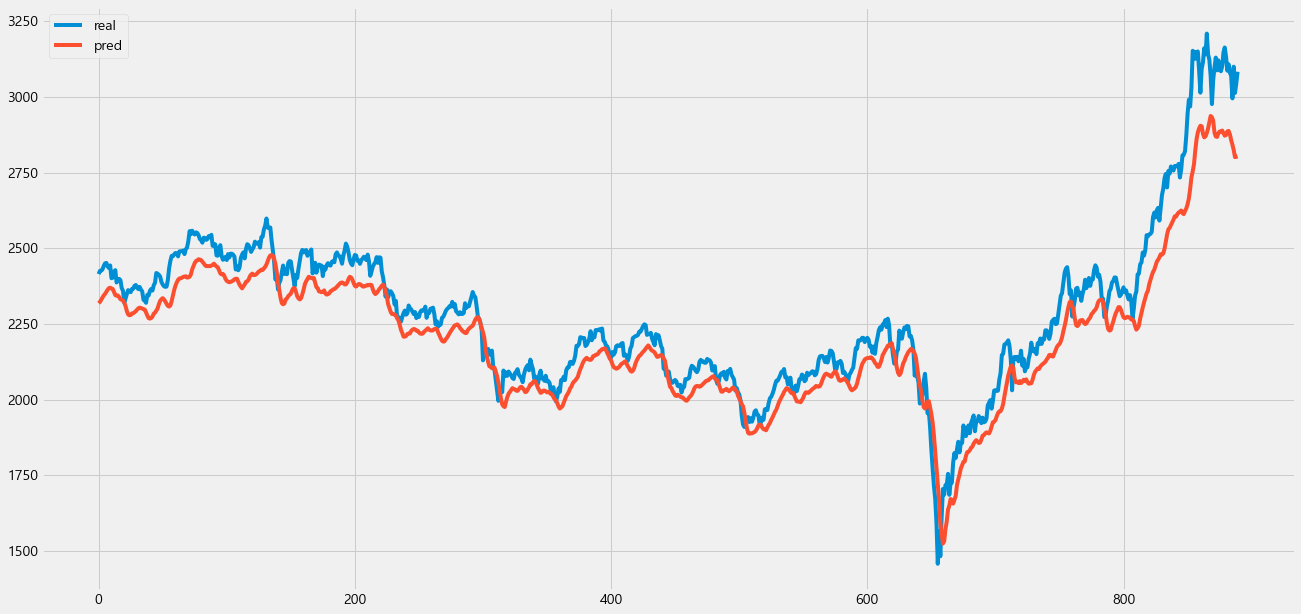

28/28 [==============================] - 1s 4ms/step - loss: 37.4628 - mae: 30.2193
(42.7517, 30.0441, 0.9748678359460272)


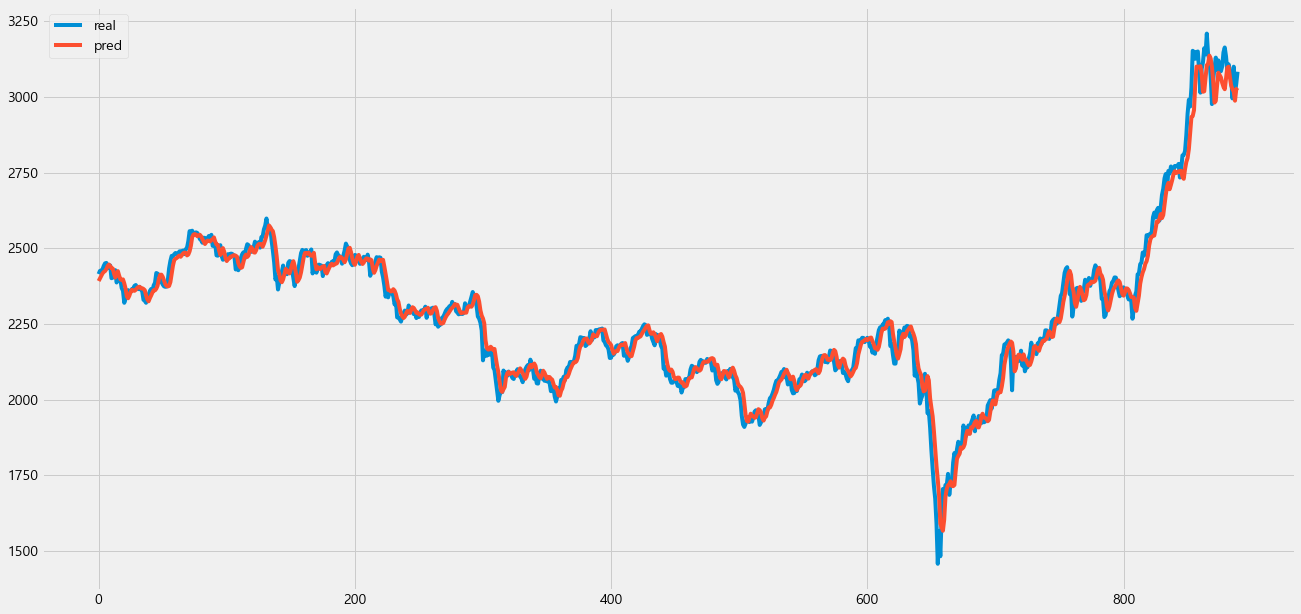

28/28 [==============================] - 1s 4ms/step - loss: 54.7318 - mae: 46.7737
(59.3442, 46.2208, 0.951573784581923)


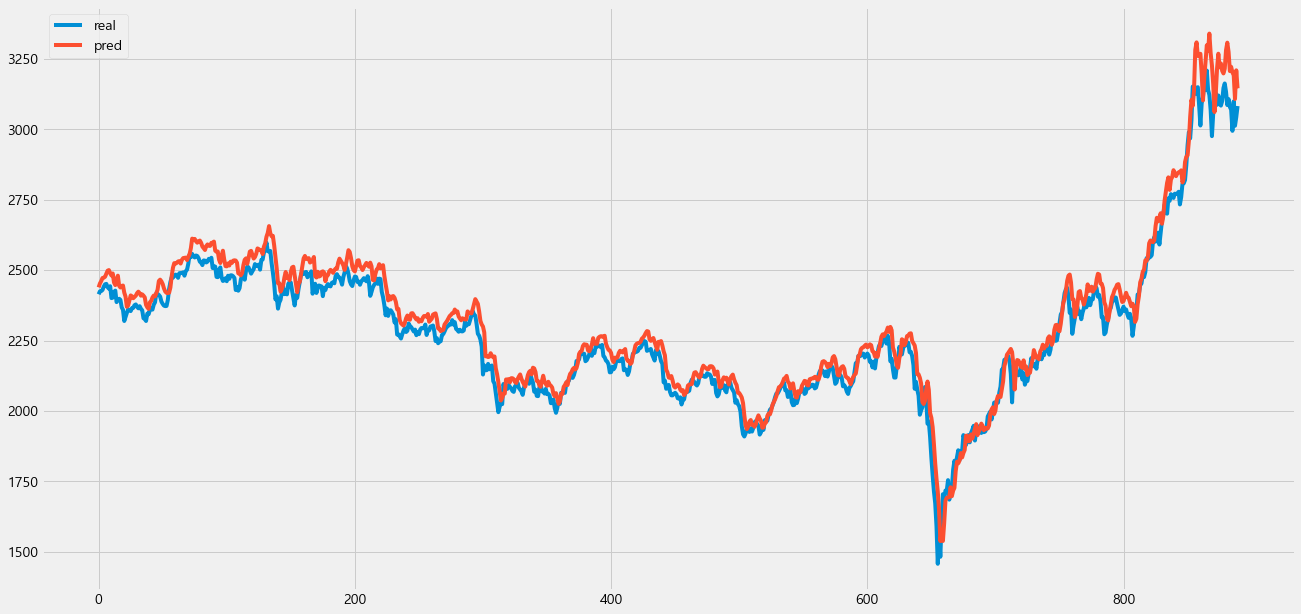

28/28 [==============================] - 1s 4ms/step - loss: 35.5868 - mae: 28.0103
(39.6084, 27.8603, 0.978427614100817)


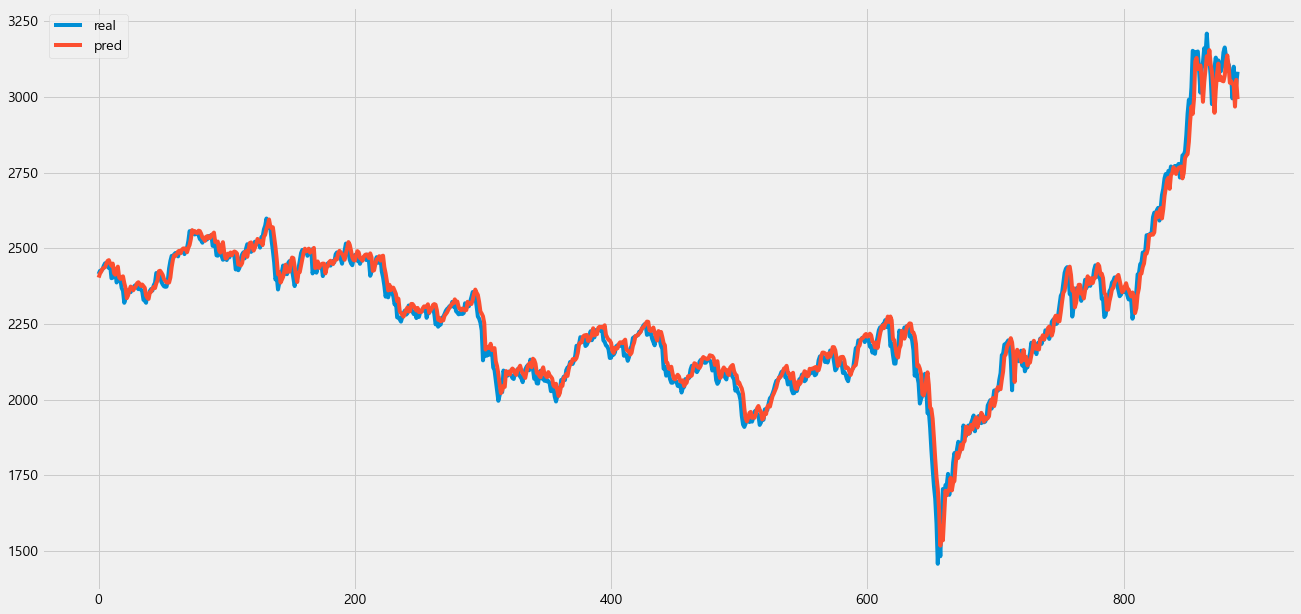

28/28 [==============================] - 1s 4ms/step - loss: 34.3562 - mae: 27.8527
(39.0629, 27.6678, 0.9790177335856993)


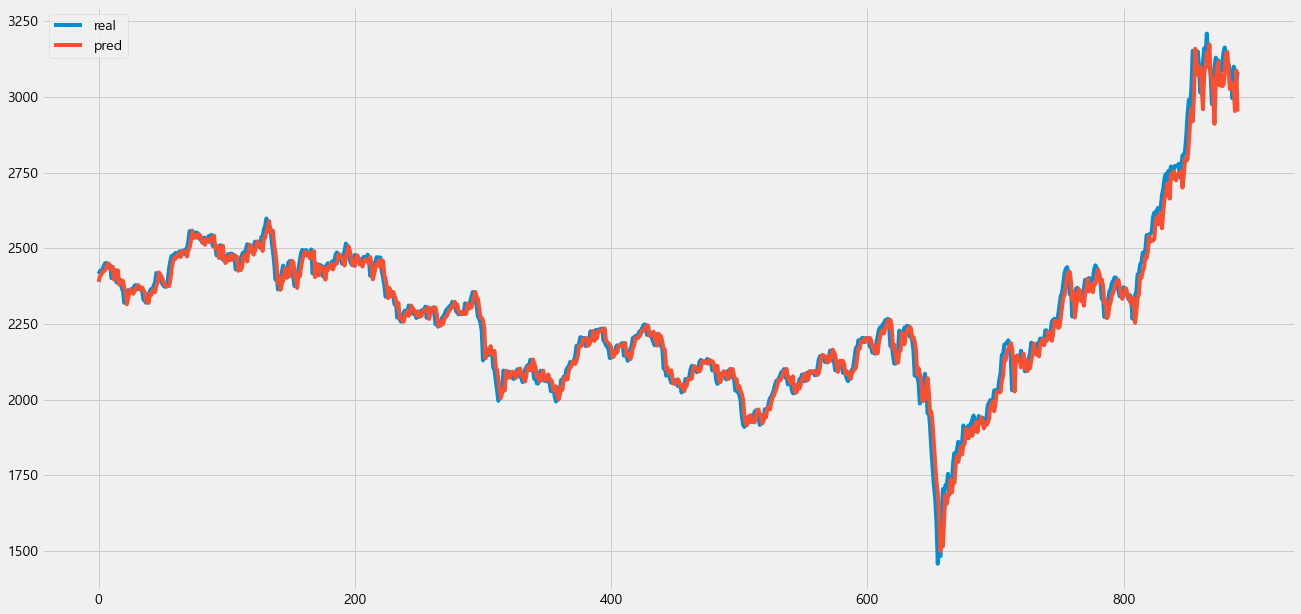

28/28 [==============================] - 1s 4ms/step - loss: 40.1278 - mae: 33.5788
(44.204, 33.3475, 0.9731313155766934)


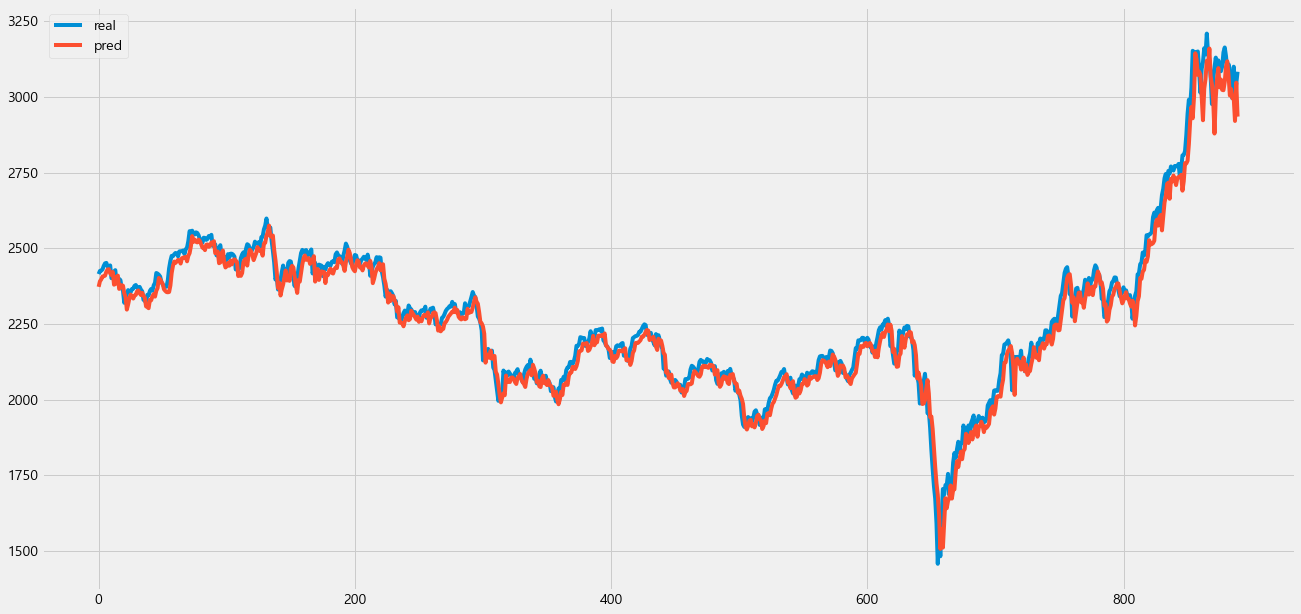

28/28 [==============================] - 1s 5ms/step - loss: 33.4127 - mae: 26.6499
(37.373, 26.4903, 0.9807939206850778)


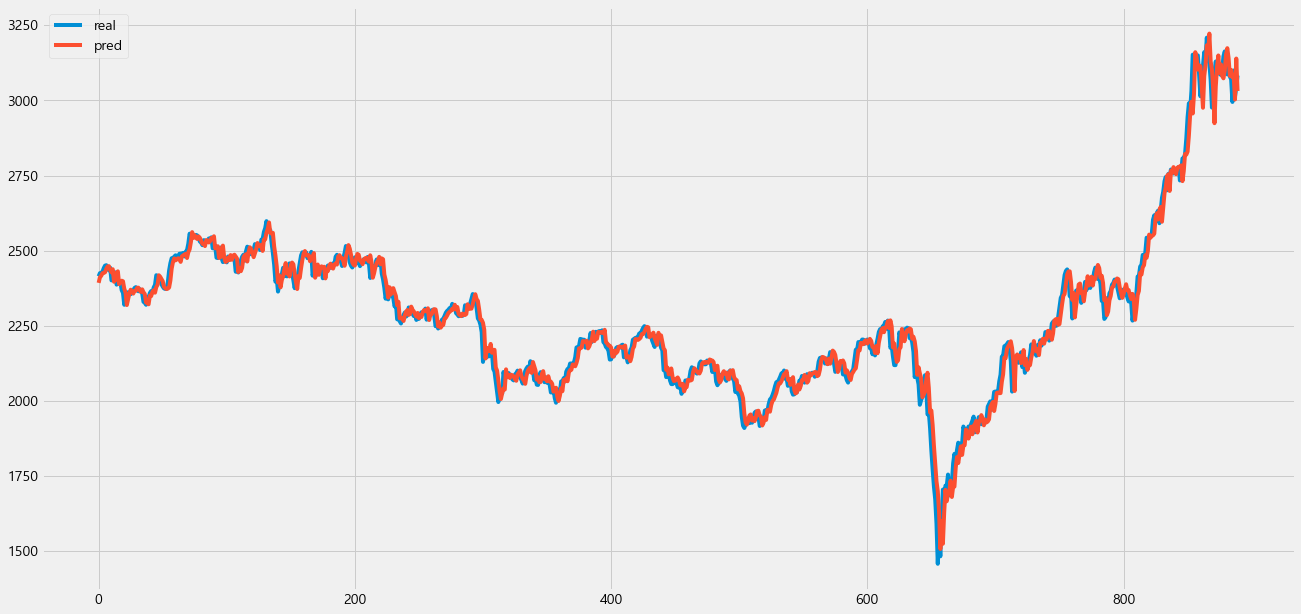

28/28 [==============================] - 1s 5ms/step - loss: 36.6024 - mae: 30.0869
(40.9772, 29.8977, 0.9769108724206834)


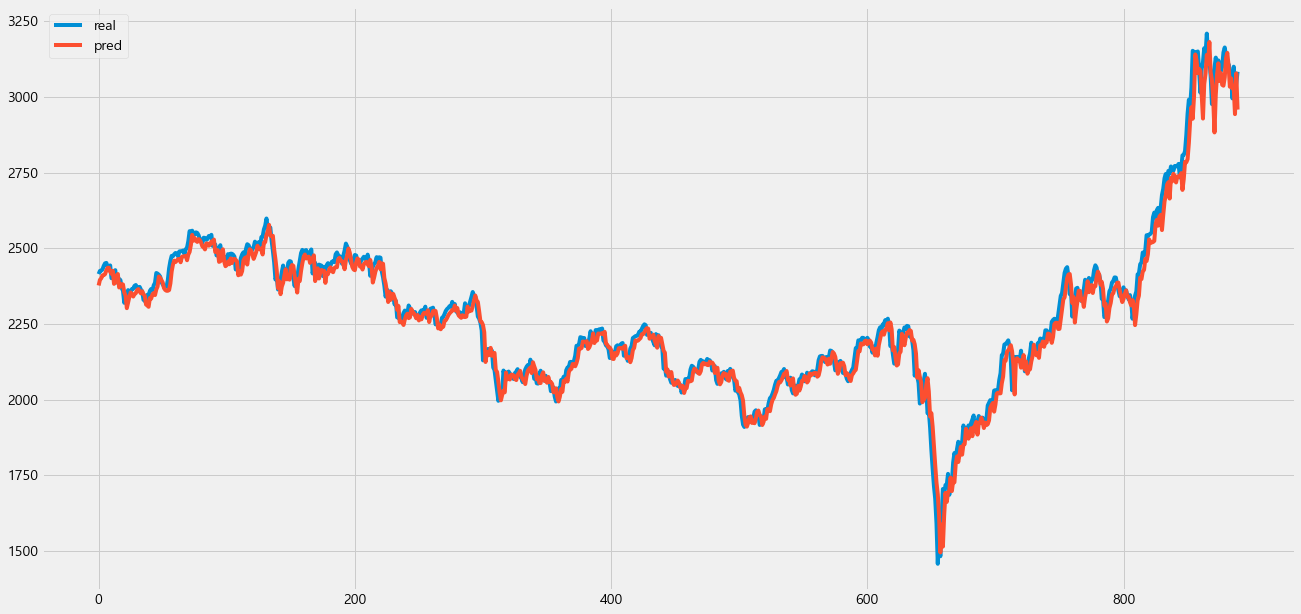

28/28 [==============================] - 1s 5ms/step - loss: 35.5156 - mae: 28.1014
(39.7395, 27.8968, 0.9782845697051746)


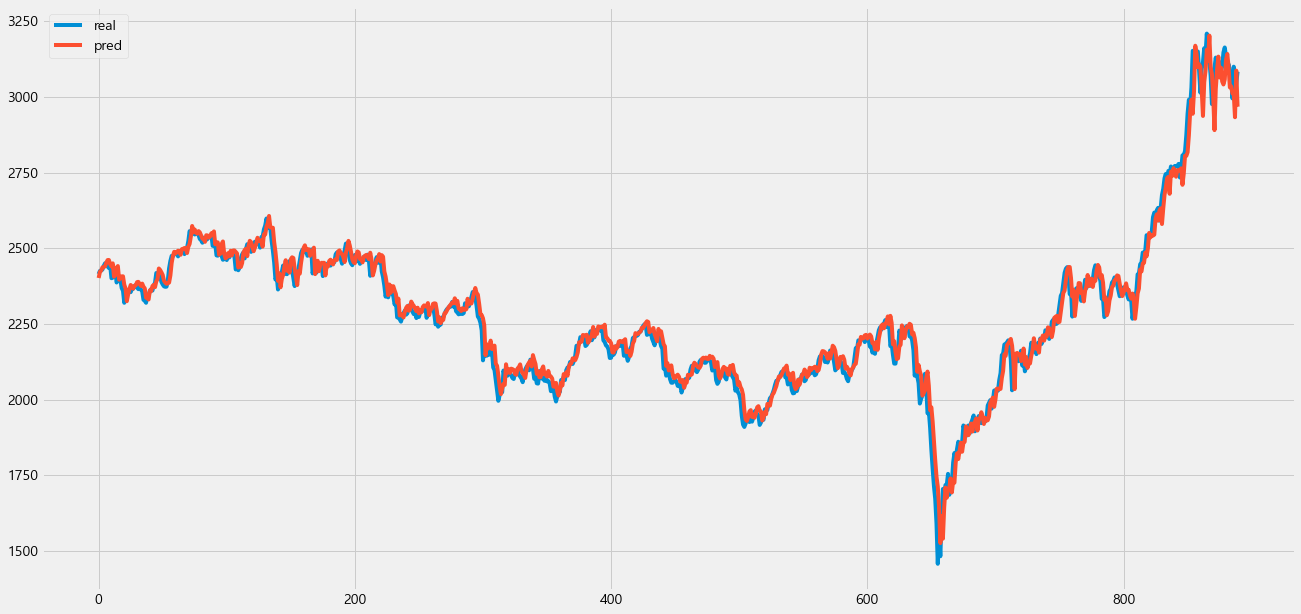

28/28 [==============================] - 1s 4ms/step - loss: 39.9392 - mae: 32.2089
(42.9834, 32.0054, 0.9745946956479503)


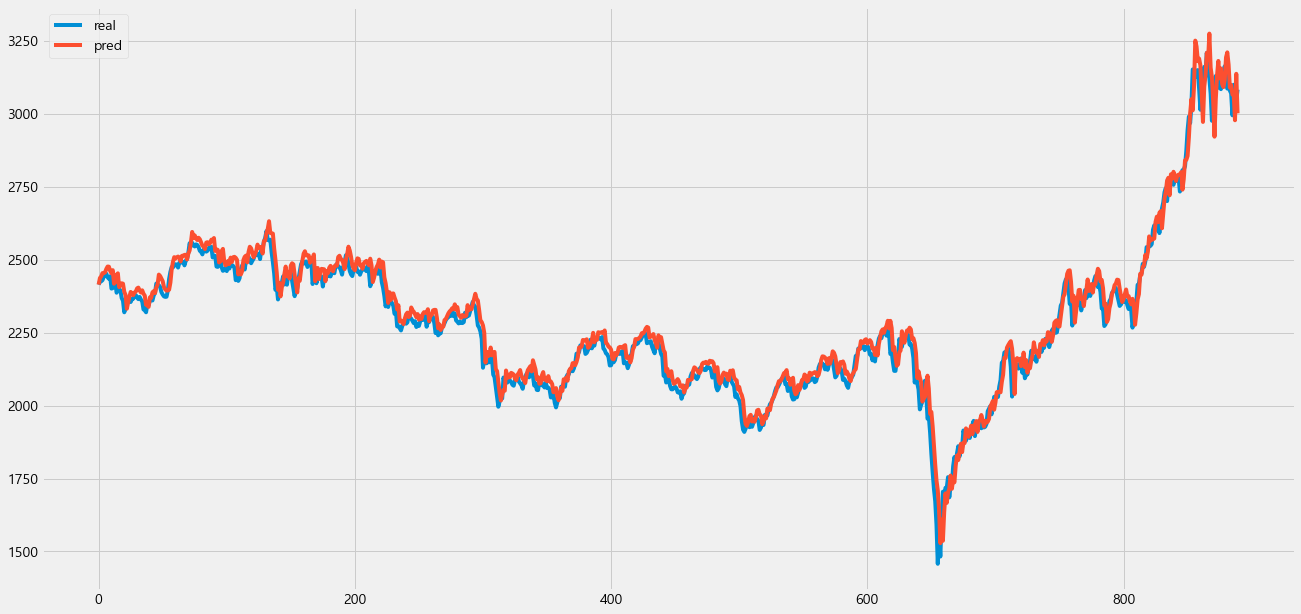

In [48]:
loss_list = []

for epoch, model in zip(epochs,model_list):
    model.evaluate(x_test, y_test)
    pred = model.predict(x_test)
    pred = np.squeeze(pred)

    actual = inverse_data(y_test, max_v, min_v)
    pred = inverse_data(pred, max_v, min_v)
    
    rmse, mae, r2 = get_loss(actual, pred)
    loss_list.append([epoch, rmse, mae, r2])
    print(get_loss(actual, pred))
    plt.plot(actual)
    plt.plot(pred)
    plt.legend(['real', 'pred'])
    plt.show()

In [49]:
loss_list

[[10, 99.0979, 82.3566, 0.8649631896592807],
 [20, 42.7517, 30.0441, 0.9748678359460272],
 [30, 59.3442, 46.2208, 0.951573784581923],
 [40, 39.6084, 27.8603, 0.978427614100817],
 [50, 39.0629, 27.6678, 0.9790177335856993],
 [60, 44.204, 33.3475, 0.9731313155766934],
 [70, 37.373, 26.4903, 0.9807939206850778],
 [80, 40.9772, 29.8977, 0.9769108724206834],
 [90, 39.7395, 27.8968, 0.9782845697051746],
 [100, 42.9834, 32.0054, 0.9745946956479503]]

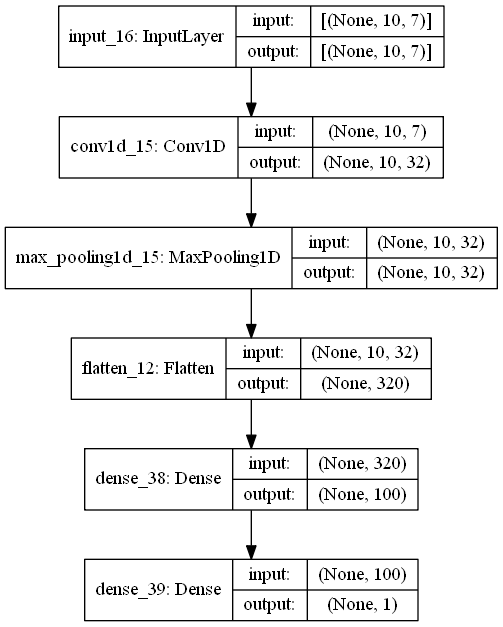

In [50]:
model = Sequential()
model.add(Input(shape=(10, 7)))
model.add(Conv1D(32, 1, activation='tanh', padding='same'))
model.add(MaxPooling1D(1, padding='same'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(1))
plot_model(model, show_shapes=True)

In [51]:
model_list = []

for epoch in epochs:
    print(epoch)
    model = Sequential()
    model.add(Input(shape=(10, 7)))
    model.add(Conv1D(32, 1, activation='tanh', padding='same'))
    model.add(MaxPooling1D(1, padding='same'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(1))
    model.compile(loss=RMSE(max_v, min_v), optimizer=Adam(lr=0.001),
                 metrics=[MAE(max_v, min_v)])
    model.fit(x_train, y_train, epochs=epoch, batch_size=64)
    model_list.append(model)
    print('\n\n')

10
Epoch 1/10
33/33 [==============================] - 1s 4ms/step - loss: 627.4044 - mae: 606.6744
Epoch 2/10
33/33 [==============================] - 0s 4ms/step - loss: 189.6489 - mae: 176.9775
Epoch 3/10
33/33 [==============================] - 0s 4ms/step - loss: 105.8184 - mae: 94.6329
Epoch 4/10
33/33 [==============================] - 0s 4ms/step - loss: 79.8028 - mae: 70.3686
Epoch 5/10
33/33 [==============================] - 0s 4ms/step - loss: 72.9278 - mae: 64.4495
Epoch 6/10
33/33 [==============================] - 0s 4ms/step - loss: 69.0361 - mae: 62.2900
Epoch 7/10
33/33 [==============================] - 0s 4ms/step - loss: 88.1196 - mae: 81.8320
Epoch 8/10
33/33 [==============================] - 0s 4ms/step - loss: 44.8553 - mae: 37.9729
Epoch 9/10
33/33 [==============================] - 0s 4ms/step - loss: 44.8449 - mae: 38.1489
Epoch 10/10
33/33 [==============================] - 0s 4ms/step - loss: 67.9398 - mae: 61.9038



20
Epoch 1/20
33/33 [=================

33/33 [==============================] - 0s 4ms/step - loss: 52.9624 - mae: 47.1811
Epoch 18/60
33/33 [==============================] - 0s 4ms/step - loss: 54.5367 - mae: 48.0693
Epoch 19/60
33/33 [==============================] - 0s 4ms/step - loss: 36.8695 - mae: 30.3529
Epoch 20/60
33/33 [==============================] - 0s 4ms/step - loss: 55.0765 - mae: 49.0993
Epoch 21/60
33/33 [==============================] - 0s 4ms/step - loss: 54.3561 - mae: 48.7239
Epoch 22/60
33/33 [==============================] - 0s 4ms/step - loss: 53.9605 - mae: 47.8261
Epoch 23/60
33/33 [==============================] - 0s 4ms/step - loss: 48.7624 - mae: 42.4411
Epoch 24/60
33/33 [==============================] - 0s 4ms/step - loss: 34.8165 - mae: 27.8116
Epoch 25/60
33/33 [==============================] - 0s 4ms/step - loss: 50.2671 - mae: 44.1040
Epoch 26/60
33/33 [==============================] - 0s 4ms/step - loss: 48.5057 - mae: 42.2794
Epoch 27/60
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 38.7933 - mae: 32.0006
Epoch 54/80
33/33 [==============================] - 0s 4ms/step - loss: 36.6033 - mae: 30.0540
Epoch 55/80
33/33 [==============================] - 0s 4ms/step - loss: 29.4749 - mae: 22.6532
Epoch 56/80
33/33 [==============================] - 0s 4ms/step - loss: 31.7028 - mae: 24.9797
Epoch 57/80
33/33 [==============================] - 0s 4ms/step - loss: 34.2782 - mae: 27.9338
Epoch 58/80
33/33 [==============================] - 0s 4ms/step - loss: 31.4765 - mae: 24.4083
Epoch 59/80
33/33 [==============================] - 0s 4ms/step - loss: 28.8451 - mae: 22.4460
Epoch 60/80
33/33 [==============================] - 0s 4ms/step - loss: 31.1727 - mae: 24.9418
Epoch 61/80
33/33 [==============================] - 0s 4ms/step - loss: 29.3896 - mae: 22.7915
Epoch 62/80
33/33 [==============================] - 0s 4ms/step - loss: 30.9457 - mae: 24.2320
Epoch 63/80
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 34.1021 - mae: 26.9746
Epoch 50/100
33/33 [==============================] - 0s 4ms/step - loss: 29.2321 - mae: 22.5360
Epoch 51/100
33/33 [==============================] - 0s 4ms/step - loss: 34.4157 - mae: 28.2409
Epoch 52/100
33/33 [==============================] - 0s 4ms/step - loss: 37.6026 - mae: 30.7933
Epoch 53/100
33/33 [==============================] - 0s 4ms/step - loss: 33.5977 - mae: 26.7024
Epoch 54/100
33/33 [==============================] - 0s 4ms/step - loss: 33.8353 - mae: 26.5593
Epoch 55/100
33/33 [==============================] - 0s 4ms/step - loss: 32.4082 - mae: 25.6905
Epoch 56/100
33/33 [==============================] - 0s 4ms/step - loss: 36.6301 - mae: 29.5140
Epoch 57/100
33/33 [==============================] - 0s 4ms/step - loss: 30.3392 - mae: 23.3583
Epoch 58/100
33/33 [==============================] - 0s 3ms/step - loss: 32.4786 - mae: 25.7305
Epoch 59/100
33/33 [=======================

28/28 [==============================] - 0s 3ms/step - loss: 166.4570 - mae: 162.9856
(170.7868, 162.3124, 0.5989190274883265)


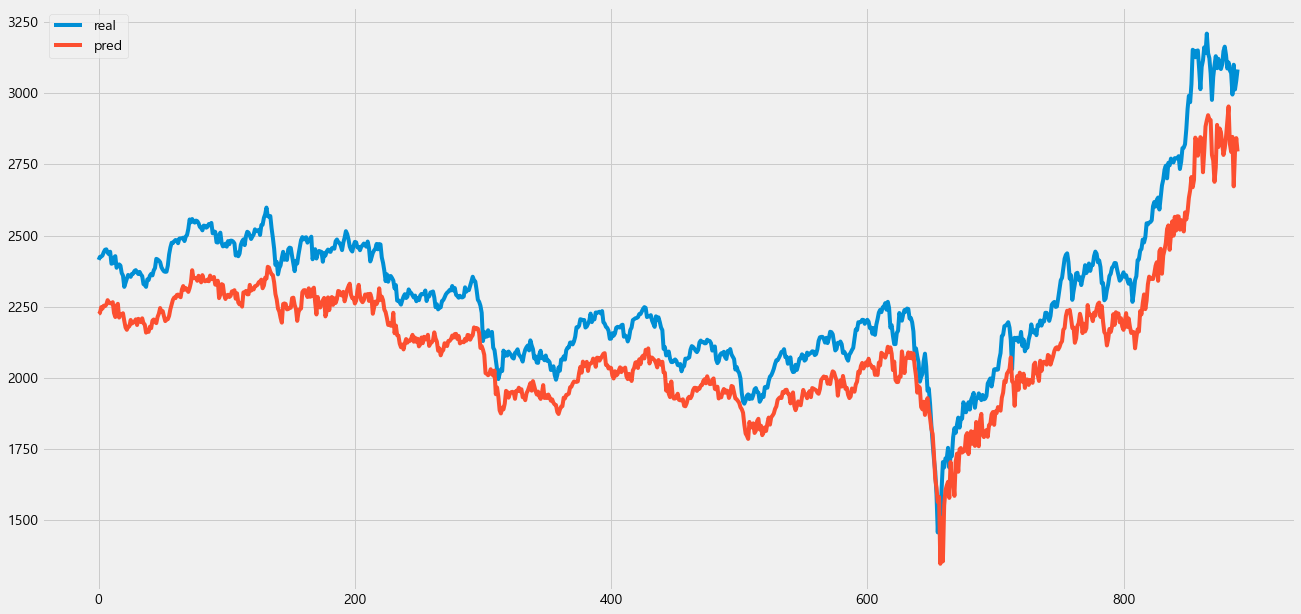

28/28 [==============================] - 0s 2ms/step - loss: 69.2170 - mae: 63.9223
(84.3168, 62.7303, 0.9022420671890555)


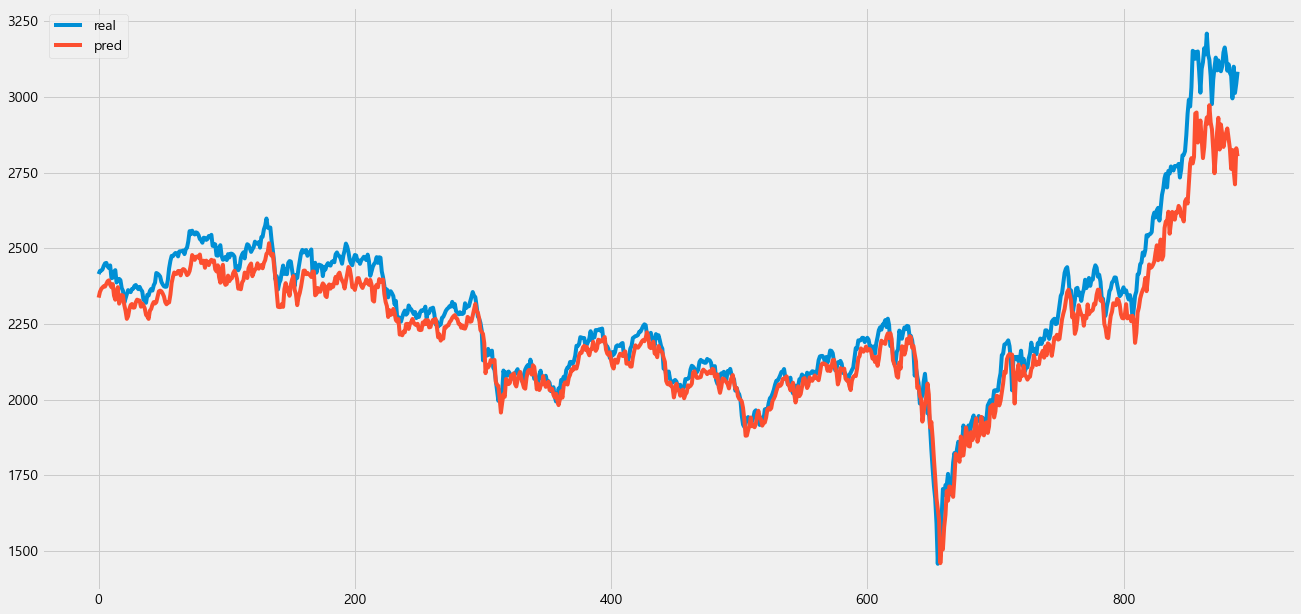

28/28 [==============================] - 0s 3ms/step - loss: 89.3854 - mae: 84.5831
(96.2096, 83.7837, 0.8727199468218027)


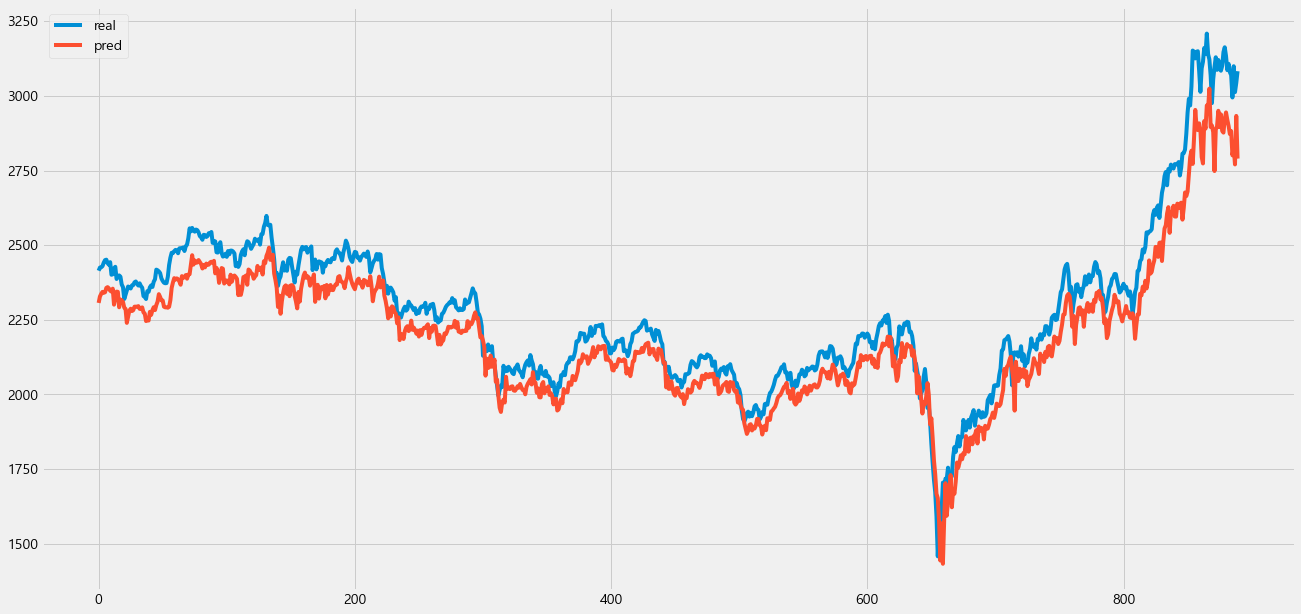

28/28 [==============================] - 0s 2ms/step - loss: 70.9697 - mae: 65.7514
(86.2965, 64.5448, 0.8975976398227496)


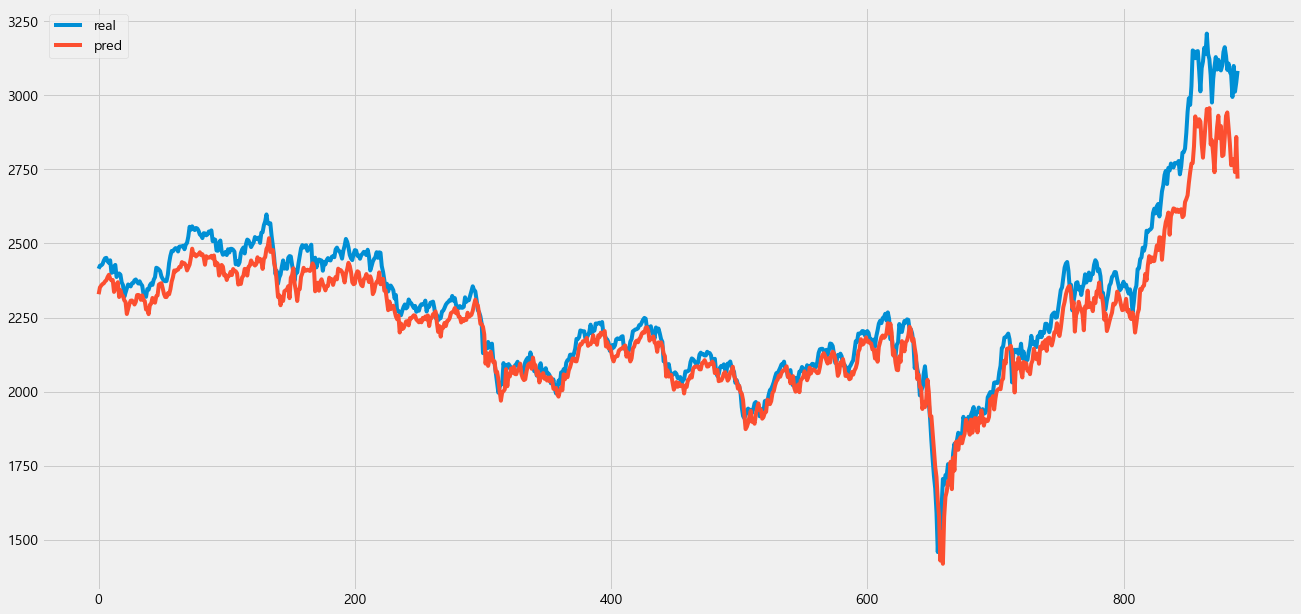

28/28 [==============================] - 0s 2ms/step - loss: 50.5711 - mae: 44.7447
(60.4816, 43.9734, 0.9496997106401956)


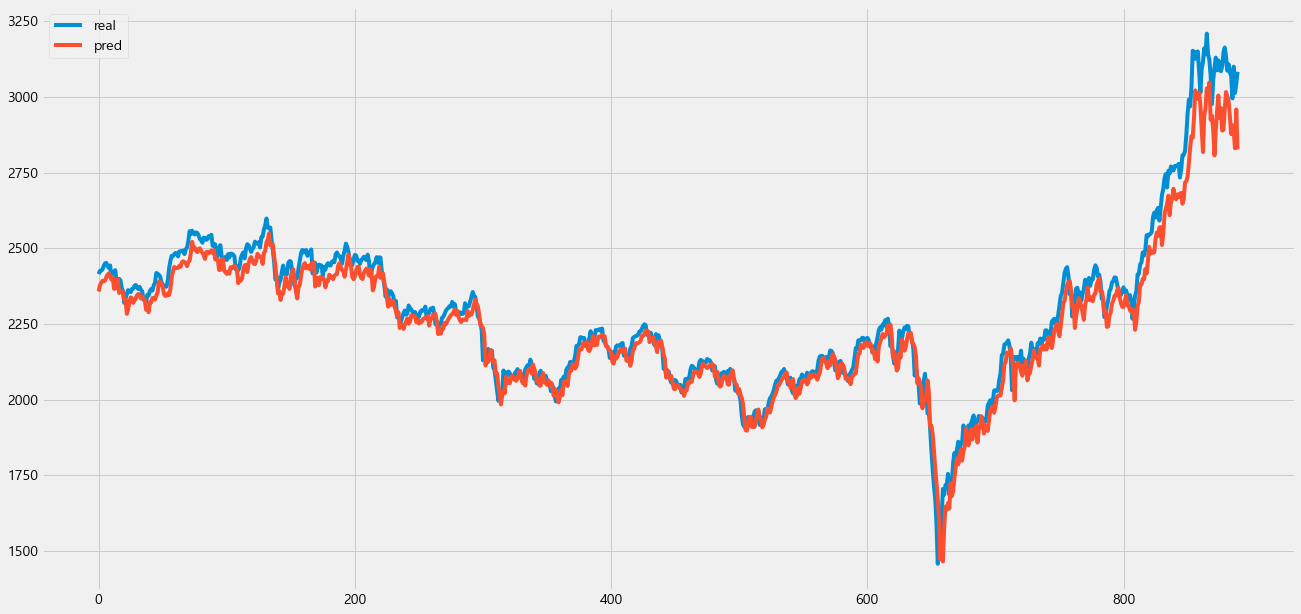

28/28 [==============================] - 0s 2ms/step - loss: 87.8692 - mae: 82.8546
(96.5562, 81.9374, 0.8718011506152763)


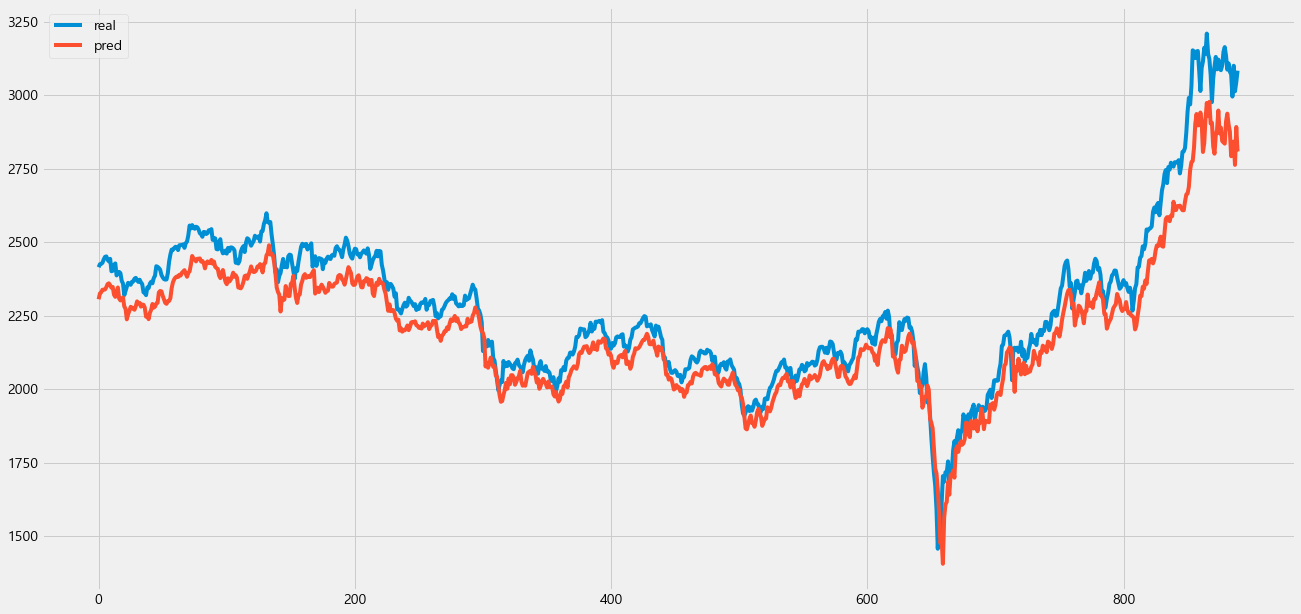

28/28 [==============================] - 0s 3ms/step - loss: 54.6886 - mae: 48.7189
(63.353, 48.0195, 0.9448102708697246)


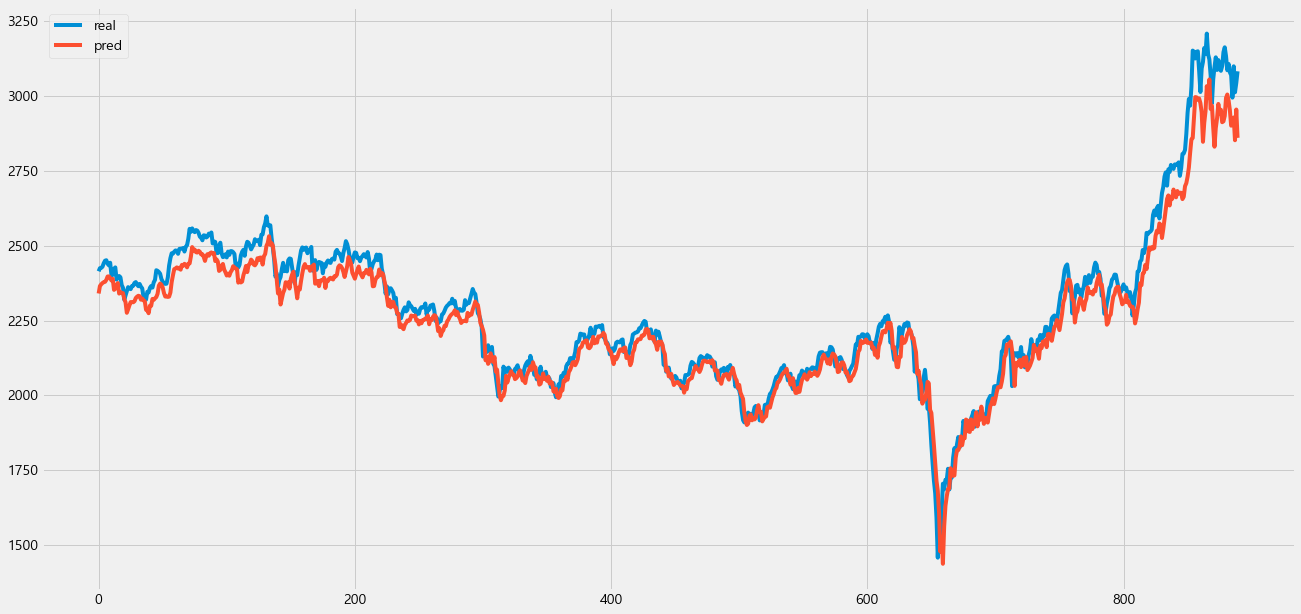

28/28 [==============================] - 0s 2ms/step - loss: 59.2016 - mae: 53.4258
(69.2241, 52.5908, 0.934107224399522)


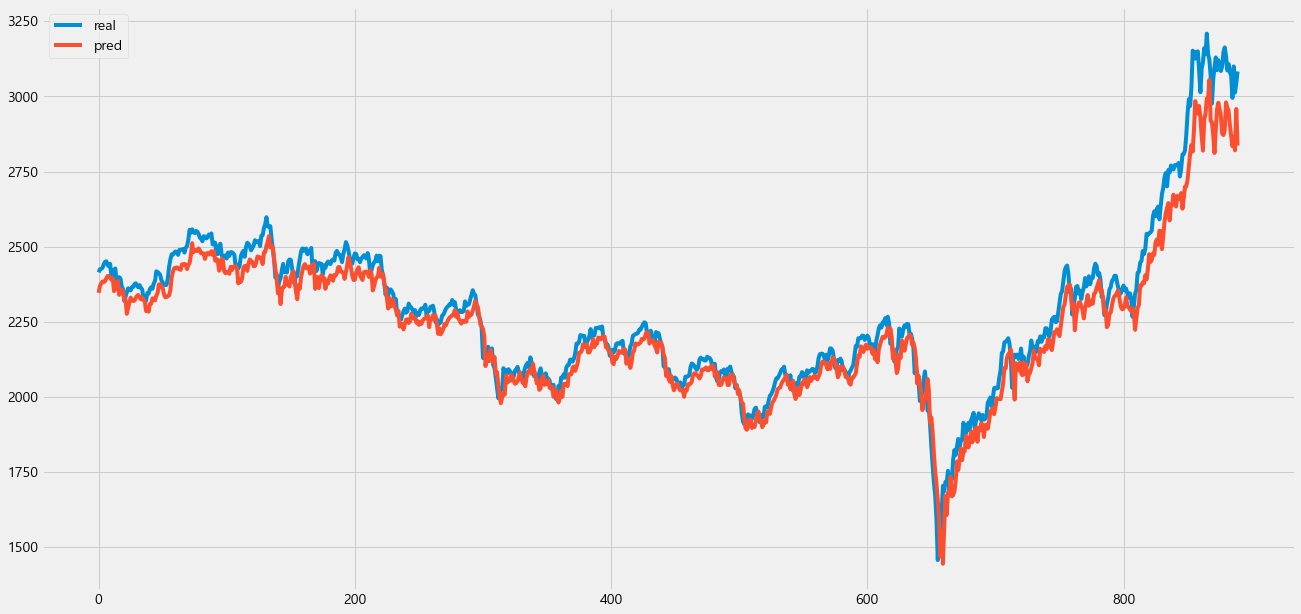

28/28 [==============================] - 0s 2ms/step - loss: 36.2005 - mae: 28.8507
(41.8958, 28.5662, 0.9758640317117709)


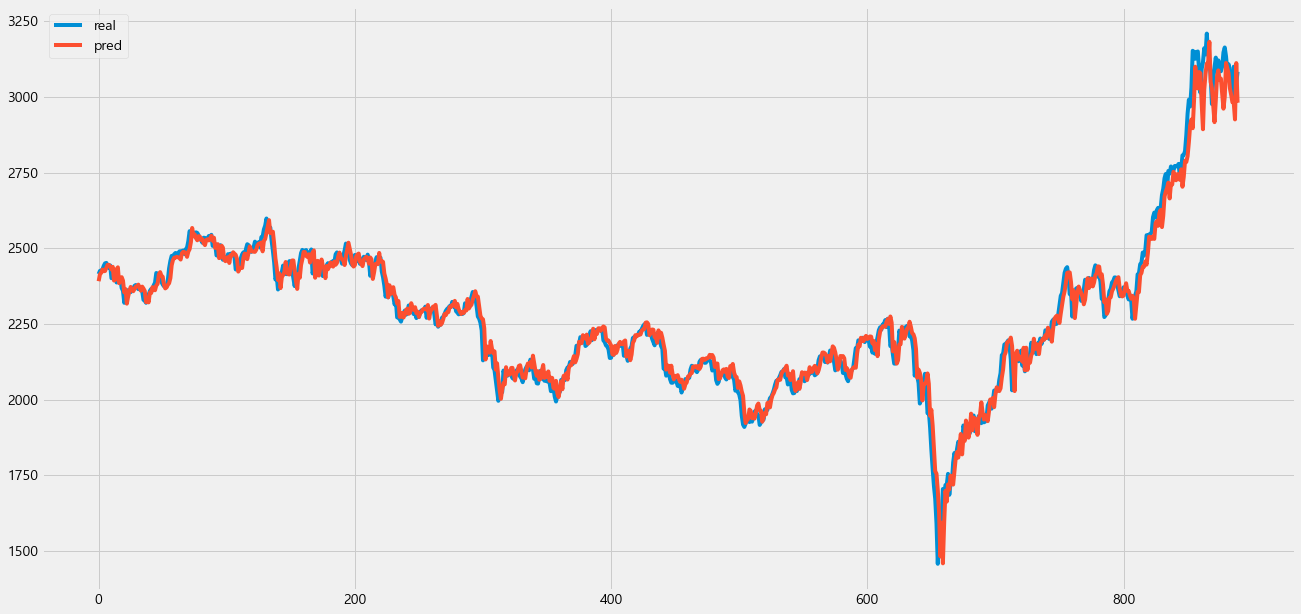

28/28 [==============================] - 0s 2ms/step - loss: 44.3757 - mae: 38.6756
(54.5079, 38.0336, 0.9591453261523499)


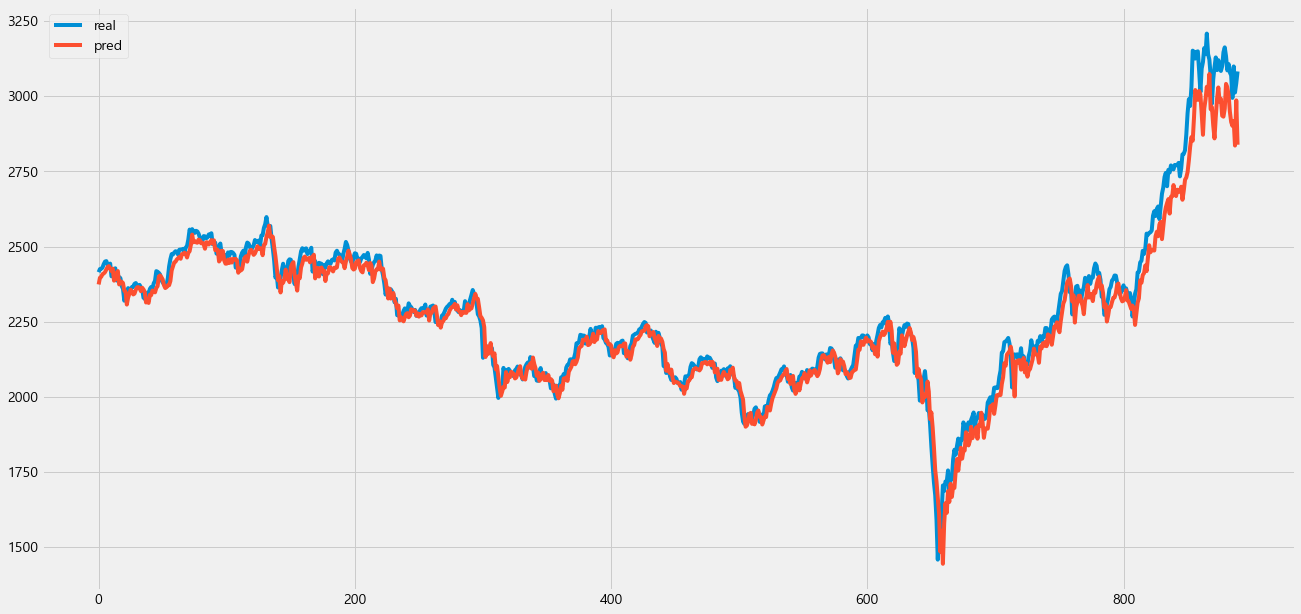

In [52]:
loss_list = []

for epoch, model in zip(epochs,model_list):
    model.evaluate(x_test, y_test)
    pred = model.predict(x_test)
    pred = np.squeeze(pred)

    actual = inverse_data(y_test, max_v, min_v)
    pred = inverse_data(pred, max_v, min_v)
    
    rmse, mae, r2 = get_loss(actual, pred)
    loss_list.append([epoch, rmse, mae, r2])
    print(get_loss(actual, pred))
    plt.plot(actual)
    plt.plot(pred)
    plt.legend(['real', 'pred'])
    plt.show()

In [53]:
loss_list

[[10, 170.7868, 162.3124, 0.5989190274883265],
 [20, 84.3168, 62.7303, 0.9022420671890555],
 [30, 96.2096, 83.7837, 0.8727199468218027],
 [40, 86.2965, 64.5448, 0.8975976398227496],
 [50, 60.4816, 43.9734, 0.9496997106401956],
 [60, 96.5562, 81.9374, 0.8718011506152763],
 [70, 63.353, 48.0195, 0.9448102708697246],
 [80, 69.2241, 52.5908, 0.934107224399522],
 [90, 41.8958, 28.5662, 0.9758640317117709],
 [100, 54.5079, 38.0336, 0.9591453261523499]]

In [54]:
from tensorflow.keras.layers import SimpleRNN

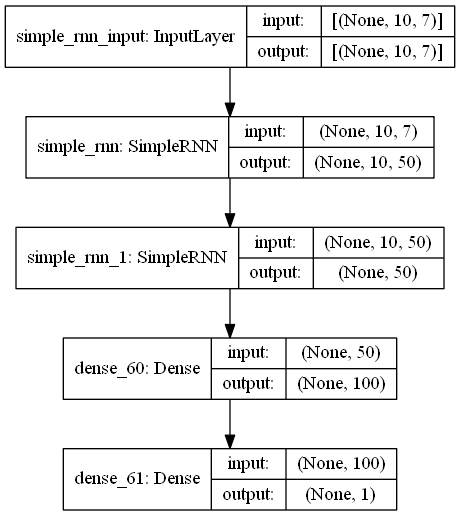

In [55]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(10,7), return_sequences=True))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(100))
model.add(Dense(1))
plot_model(model, show_shapes=True)

In [56]:
model_list = []

for epoch in epochs:
    print(epoch)
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(10,7), return_sequences=True))
    model.add(SimpleRNN(50, return_sequences=False))
    model.add(Dense(100))
    model.add(Dense(1))
    model.compile(loss=RMSE(max_v, min_v), optimizer=Adam(lr=0.001),
                 metrics=[MAE(max_v, min_v)])
    model.fit(x_train, y_train, epochs=epoch, batch_size=64)
    model_list.append(model)
    print('\n\n')

10
Epoch 1/10
33/33 [==============================] - 5s 32ms/step - loss: 579.5778 - mae: 563.0788
Epoch 2/10
33/33 [==============================] - 1s 32ms/step - loss: 110.5180 - mae: 95.9142A: 0s - loss: 129.614
Epoch 3/10
33/33 [==============================] - 1s 32ms/step - loss: 70.8911 - mae: 61.7280
Epoch 4/10
33/33 [==============================] - 1s 33ms/step - loss: 64.4360 - mae: 56.6605
Epoch 5/10
33/33 [==============================] - 1s 33ms/step - loss: 69.2274 - mae: 62.5446: 0s - loss: 71.0625 -
Epoch 6/10
33/33 [==============================] - 1s 33ms/step - loss: 64.2177 - mae: 57.2815: 0s - loss: 67.3559 - mae: 
Epoch 7/10
33/33 [==============================] - 1s 35ms/step - loss: 64.3444 - mae: 57.6165: 0s - loss: 64.9698 - mae: 58.
Epoch 8/10
33/33 [==============================] - 1s 34ms/step - loss: 56.9561 - mae: 50.5020: 0s - loss: 57.0105 - mae:
Epoch 9/10
33/33 [==============================] - 1s 34ms/step - loss: 55.2660 - mae: 48.0652
E

33/33 [==============================] - 1s 35ms/step - loss: 30.8763 - mae: 24.3864
Epoch 41/50
33/33 [==============================] - 1s 33ms/step - loss: 29.2532 - mae: 22.3278: 0s - loss: 29.2637 - mae: 22.30
Epoch 42/50
33/33 [==============================] - 1s 34ms/step - loss: 30.0547 - mae: 23.3352
Epoch 43/50
33/33 [==============================] - 1s 33ms/step - loss: 28.6630 - mae: 22.1459
Epoch 44/50
33/33 [==============================] - 1s 33ms/step - loss: 28.8044 - mae: 21.5350
Epoch 45/50
33/33 [==============================] - 1s 33ms/step - loss: 28.8383 - mae: 22.3773
Epoch 46/50
33/33 [==============================] - 1s 32ms/step - loss: 28.4896 - mae: 21.8408: 0s - loss: 28.9025 - ma
Epoch 47/50
33/33 [==============================] - 1s 36ms/step - loss: 33.0260 - mae: 26.1026
Epoch 48/50
33/33 [==============================] - 1s 32ms/step - loss: 37.8833 - mae: 30.8920: 0s - loss: 41.5977 - mae: 34.28 - ETA: 0s - loss: 40.7255 - mae
Epoch 49/50
33/3

33/33 [==============================] - 1s 35ms/step - loss: 54.6341 - mae: 48.2751
Epoch 9/80
33/33 [==============================] - 1s 35ms/step - loss: 59.6781 - mae: 53.2643
Epoch 10/80
33/33 [==============================] - 1s 36ms/step - loss: 61.4105 - mae: 54.5470
Epoch 11/80
33/33 [==============================] - 1s 35ms/step - loss: 48.9607 - mae: 41.6603
Epoch 12/80
33/33 [==============================] - 1s 35ms/step - loss: 41.5165 - mae: 34.3000: 0s - loss: 36.1587 - mae: 2 - ETA: 0s - loss: 40.8430 - mae: 3
Epoch 13/80
33/33 [==============================] - 1s 34ms/step - loss: 37.9820 - mae: 31.5336
Epoch 14/80
33/33 [==============================] - 1s 36ms/step - loss: 53.0316 - mae: 46.6654
Epoch 15/80
33/33 [==============================] - 1s 34ms/step - loss: 50.1055 - mae: 43.1549: 0s - loss: 50.2151 - mae: 43.25
Epoch 16/80
33/33 [==============================] - 1s 35ms/step - loss: 49.1617 - mae: 42.2122
Epoch 17/80
33/33 [========================

33/33 [==============================] - 1s 30ms/step - loss: 29.4411 - mae: 22.4379: 0s - loss: 29.4360 - mae: 22.418
Epoch 65/90
33/33 [==============================] - 1s 32ms/step - loss: 28.1065 - mae: 22.0214
Epoch 66/90
33/33 [==============================] - 1s 31ms/step - loss: 29.7466 - mae: 23.3605: 0s - loss: 28.8631 - mae: - ETA: 0s - loss: 29.6203 - mae: 23
Epoch 67/90
33/33 [==============================] - 1s 31ms/step - loss: 32.7239 - mae: 25.9429: 0s - loss: 34.6187 - m - ETA: 0s - loss: 32.7443 - mae: 25.962
Epoch 68/90
33/33 [==============================] - 1s 31ms/step - loss: 28.5835 - mae: 21.7181: 0s - loss: 28.5694 - mae: 21.7
Epoch 69/90
33/33 [==============================] - 1s 32ms/step - loss: 28.1447 - mae: 21.2985: 0s - loss: 29.7606 - mae: 22.1 - ETA: 0s - loss: 28.9041 - mae: 21.722 - ETA: 0s - loss: 28.6763 - mae: 2
Epoch 70/90
33/33 [==============================] - 1s 30ms/step - loss: 29.5182 - mae: 22.9544
Epoch 71/90
33/33 [==============

33/33 [==============================] - 1s 34ms/step - loss: 31.1588 - mae: 24.8966: 0s - loss: 31.2867 - mae: 
Epoch 94/100
33/33 [==============================] - 1s 32ms/step - loss: 29.3567 - mae: 22.3425
Epoch 95/100
33/33 [==============================] - 1s 33ms/step - loss: 31.4215 - mae: 25.0262: 0s - loss: 33.0286 - ma
Epoch 96/100
33/33 [==============================] - 1s 33ms/step - loss: 28.8471 - mae: 21.6763: 0s - loss: 28.8723 - mae
Epoch 97/100
33/33 [==============================] - 1s 33ms/step - loss: 29.6874 - mae: 22.4186: 0s - loss: 29.9237 - mae: 22 - ETA: 0s - loss: 29.9868 - mae: 
Epoch 98/100
33/33 [==============================] - 1s 32ms/step - loss: 27.0581 - mae: 20.3041: 0s - loss: 27.3079 - mae: 20.35 - ETA: 0s - loss: 27.1184 - mae: 20.24 - ETA: 0s - loss: 27.0502 - mae:
Epoch 99/100
33/33 [==============================] - 1s 35ms/step - loss: 27.6099 - mae: 21.0395
Epoch 100/100
33/33 [==============================] - 1s 34ms/step - loss: 31.

28/28 [==============================] - 0s 7ms/step - loss: 69.6787 - mae: 63.8437
(96.6752, 62.102, 0.8714850034786451)


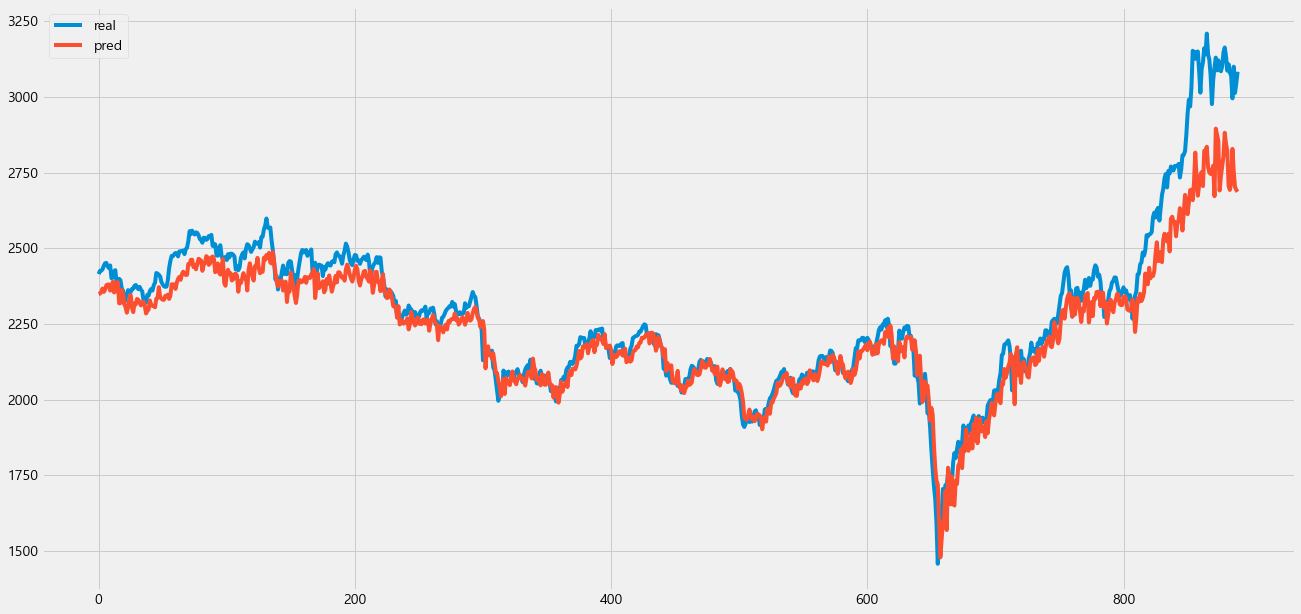

28/28 [==============================] - 0s 7ms/step - loss: 66.3770 - mae: 61.5826
(100.8063, 59.3915, 0.8602671783189935)


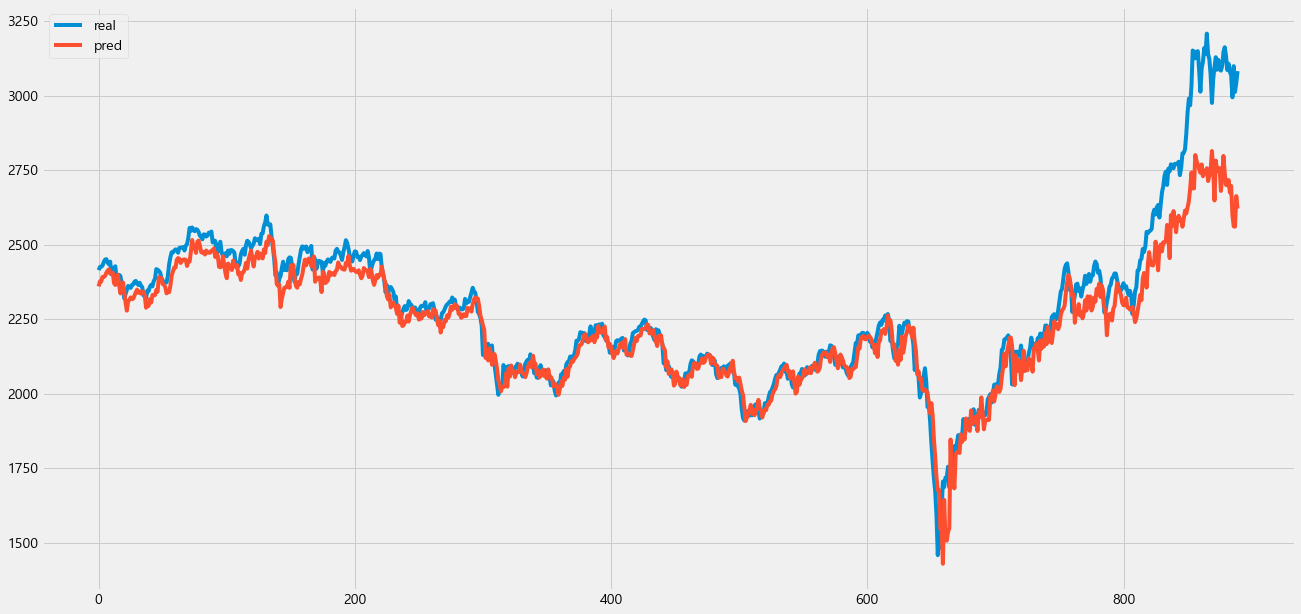

28/28 [==============================] - 0s 6ms/step - loss: 71.3807 - mae: 66.3682
(107.6563, 64.1412, 0.8406316773706418)


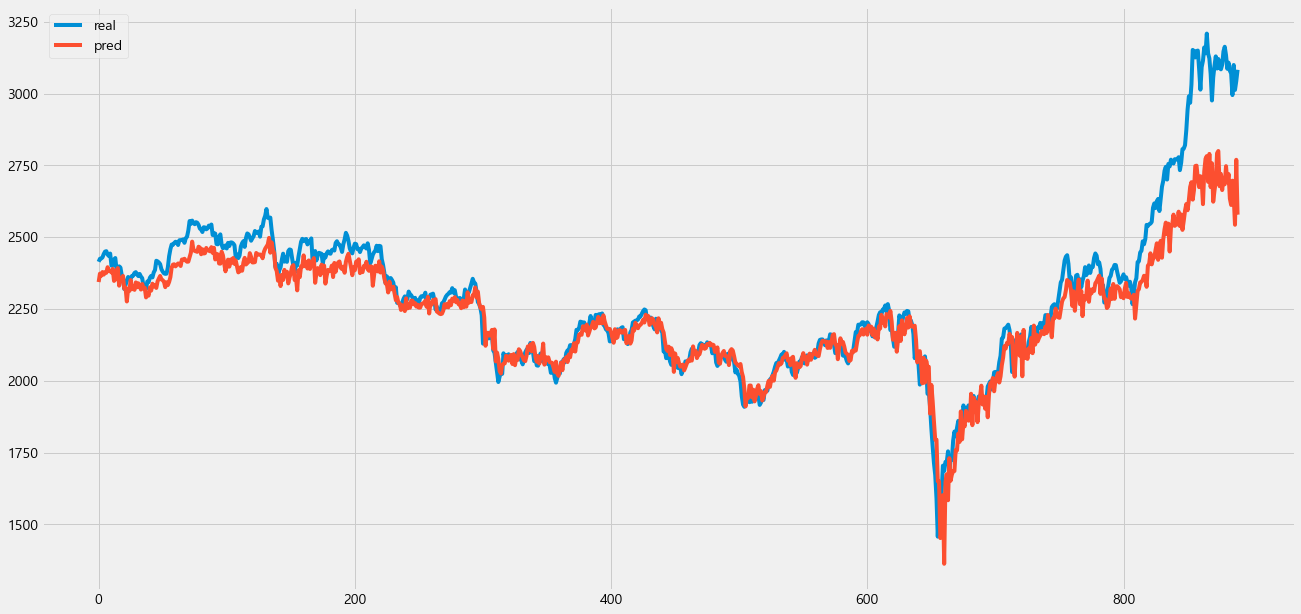

28/28 [==============================] - 0s 6ms/step - loss: 61.7373 - mae: 55.5145
(79.4199, 54.1869, 0.9132675191720533)


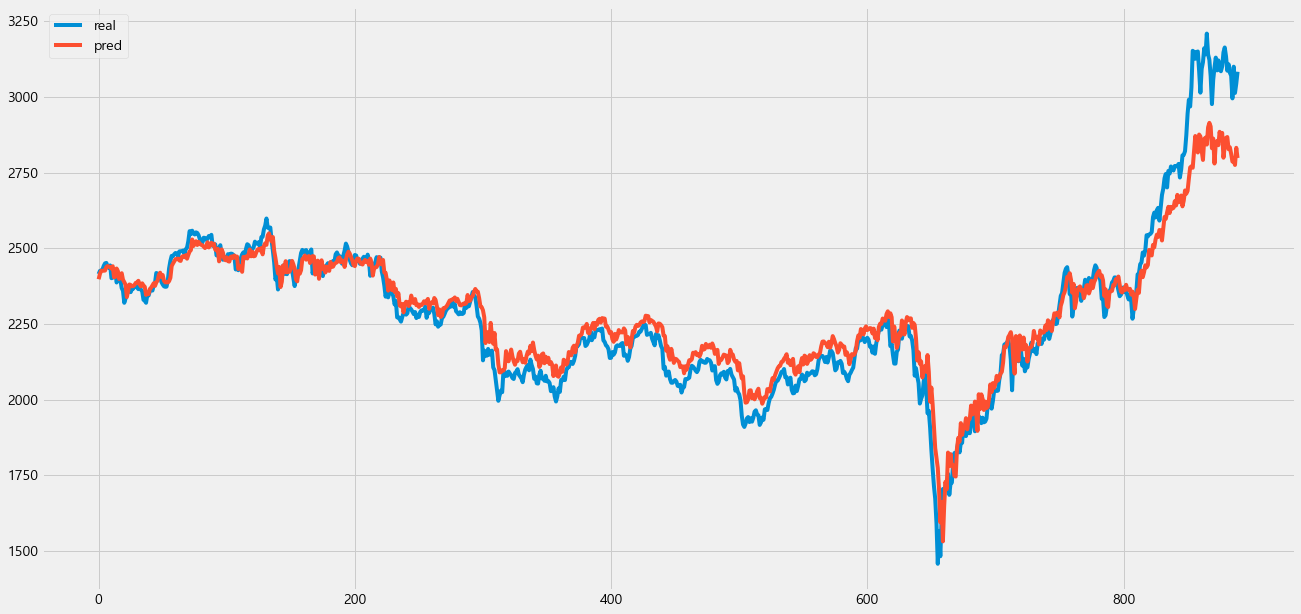

28/28 [==============================] - 0s 7ms/step - loss: 54.4209 - mae: 49.0703
(72.3936, 47.7998, 0.9279351614612494)


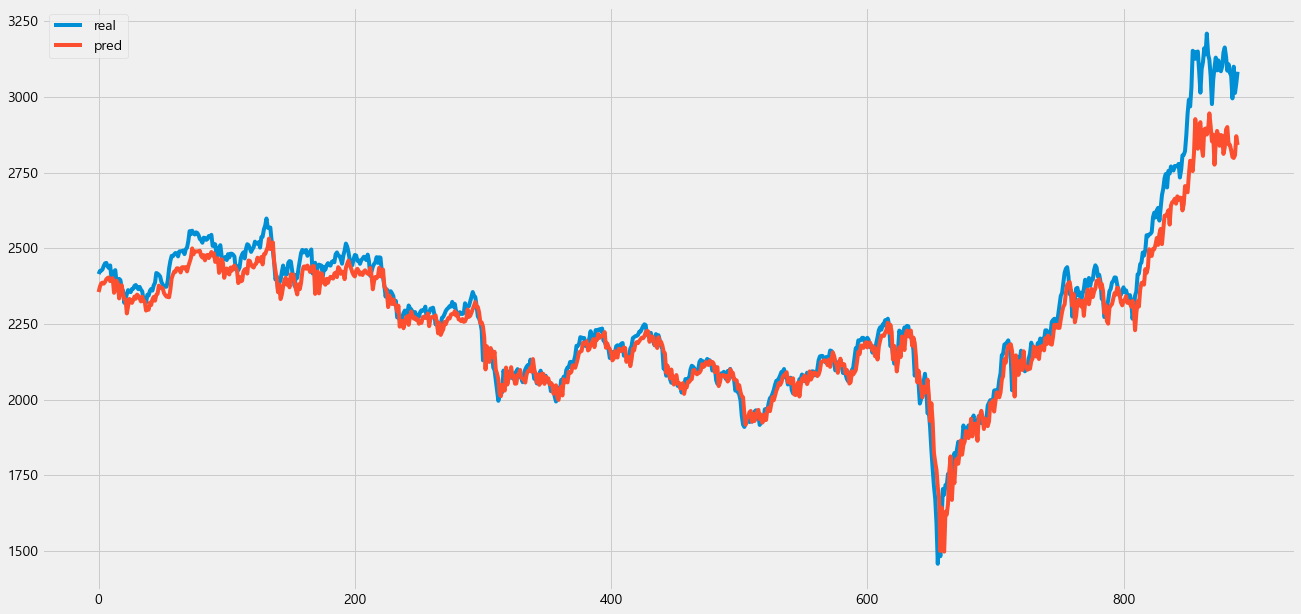

28/28 [==============================] - 0s 6ms/step - loss: 45.8947 - mae: 40.2524
(60.9804, 39.1817, 0.9488666567383468)


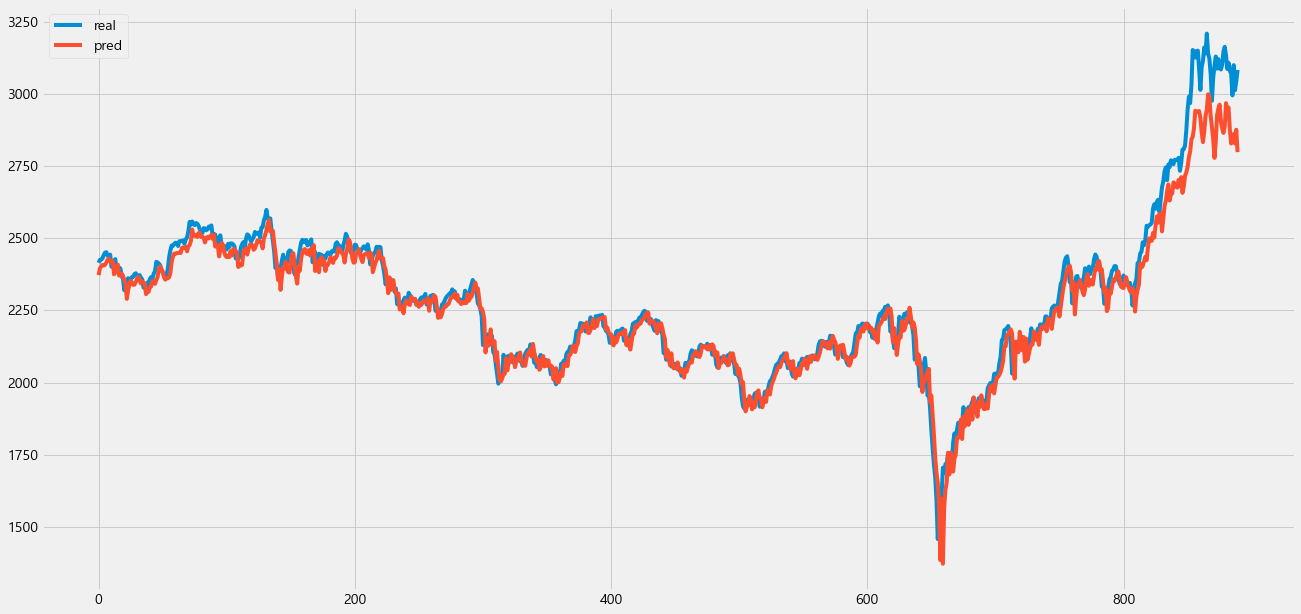

28/28 [==============================] - 0s 6ms/step - loss: 53.5614 - mae: 47.8553
(68.681, 46.7468, 0.9351370972207798)


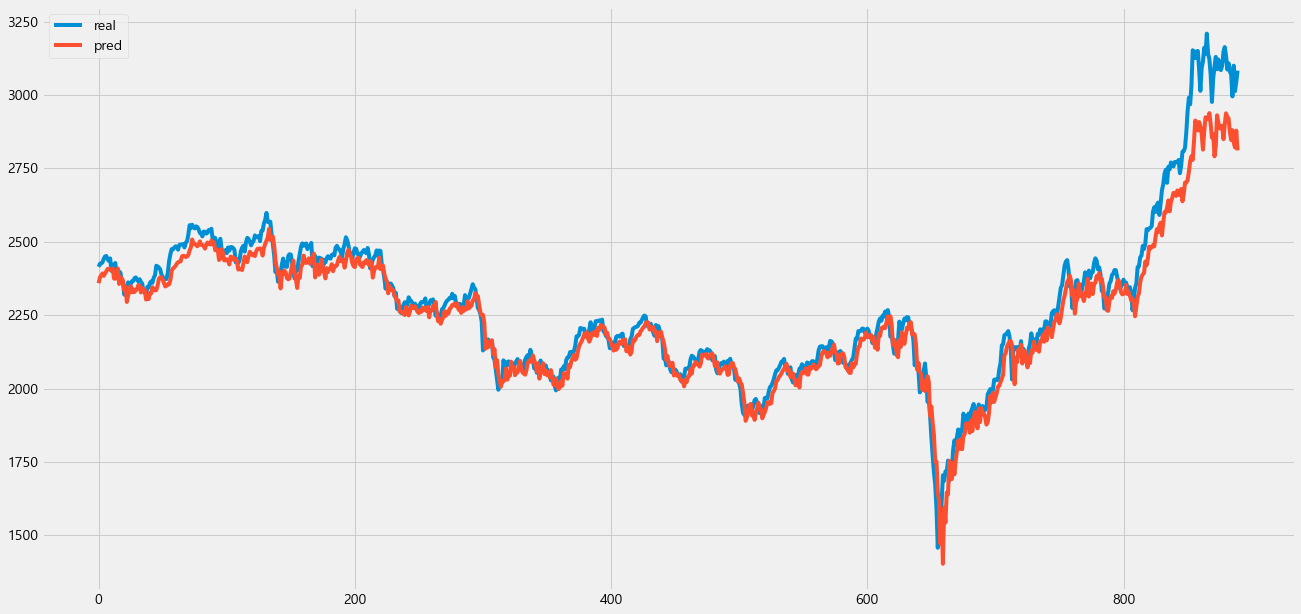

28/28 [==============================] - 0s 7ms/step - loss: 58.6068 - mae: 53.3083
(77.1005, 51.9743, 0.9182592956450374)


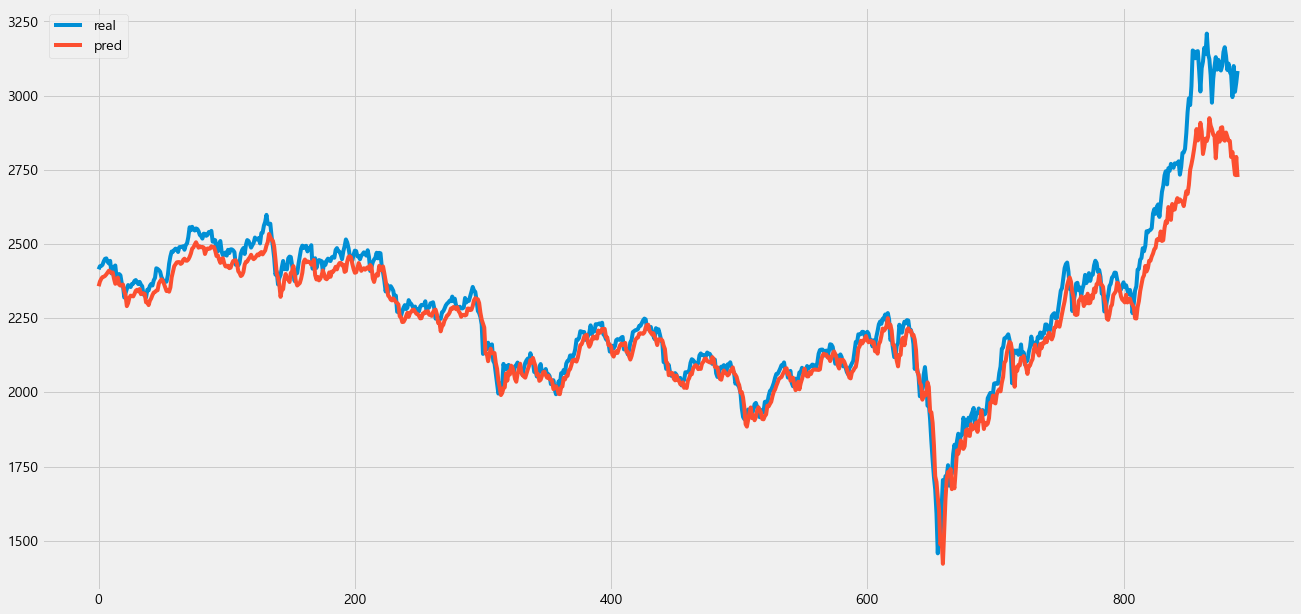

28/28 [==============================] - 0s 7ms/step - loss: 41.4825 - mae: 35.3408
(53.6118, 34.5028, 0.9604775756921657)


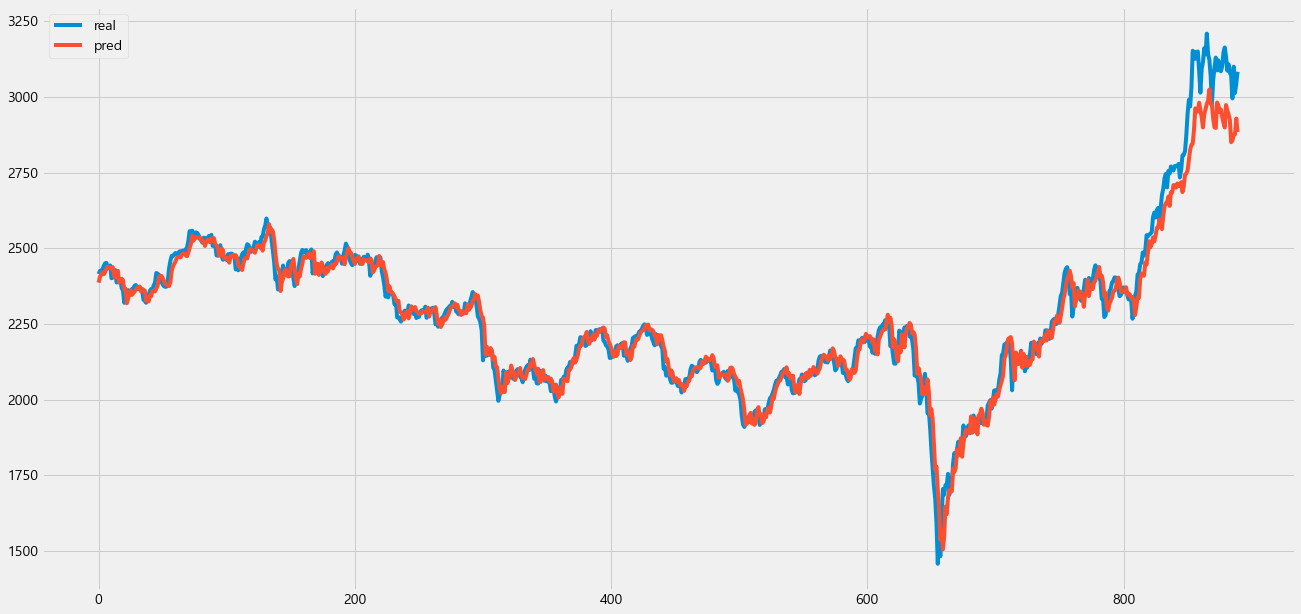

28/28 [==============================] - 0s 6ms/step - loss: 43.9052 - mae: 38.1708
(60.3254, 37.1346, 0.9499592522001735)


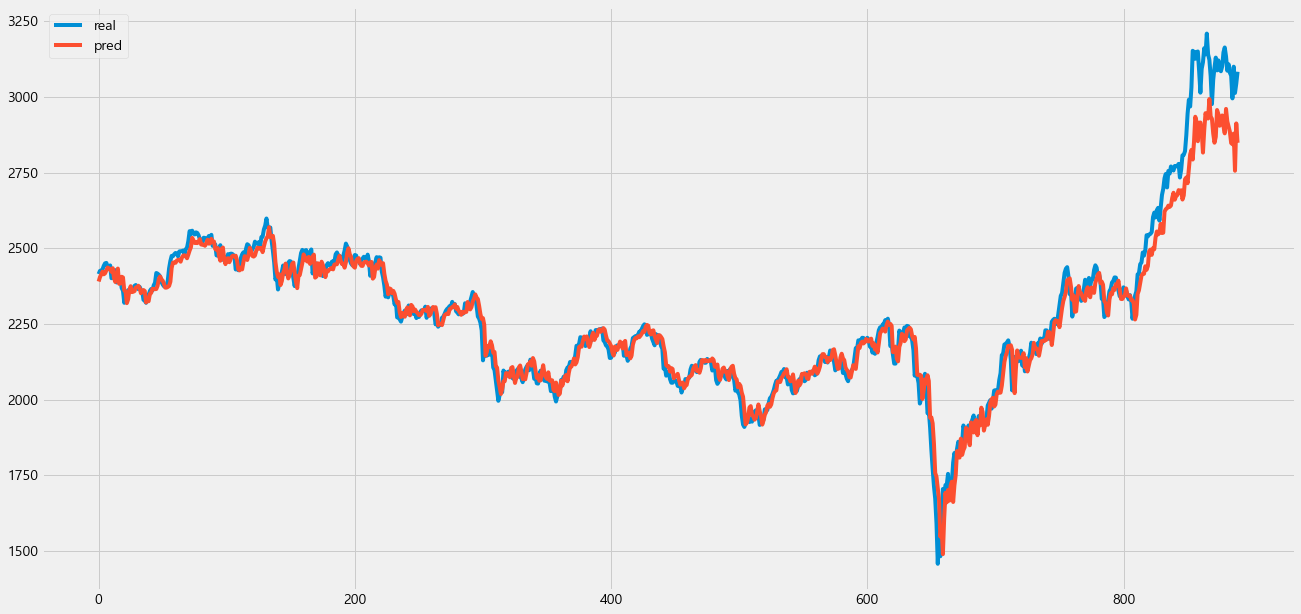

In [57]:
loss_list = []

for epoch, model in zip(epochs,model_list):
    model.evaluate(x_test, y_test)
    pred = model.predict(x_test)
    pred = np.squeeze(pred)

    actual = inverse_data(y_test, max_v, min_v)
    pred = inverse_data(pred, max_v, min_v)
    
    rmse, mae, r2 = get_loss(actual, pred)
    loss_list.append([epoch, rmse, mae, r2])
    print(get_loss(actual, pred))
    plt.plot(actual)
    plt.plot(pred)
    plt.legend(['real', 'pred'])
    plt.show()

In [58]:
loss_list

[[10, 96.6752, 62.102, 0.8714850034786451],
 [20, 100.8063, 59.3915, 0.8602671783189935],
 [30, 107.6563, 64.1412, 0.8406316773706418],
 [40, 79.4199, 54.1869, 0.9132675191720533],
 [50, 72.3936, 47.7998, 0.9279351614612494],
 [60, 60.9804, 39.1817, 0.9488666567383468],
 [70, 68.681, 46.7468, 0.9351370972207798],
 [80, 77.1005, 51.9743, 0.9182592956450374],
 [90, 53.6118, 34.5028, 0.9604775756921657],
 [100, 60.3254, 37.1346, 0.9499592522001735]]

In [59]:
from tensorflow.keras.layers import GRU

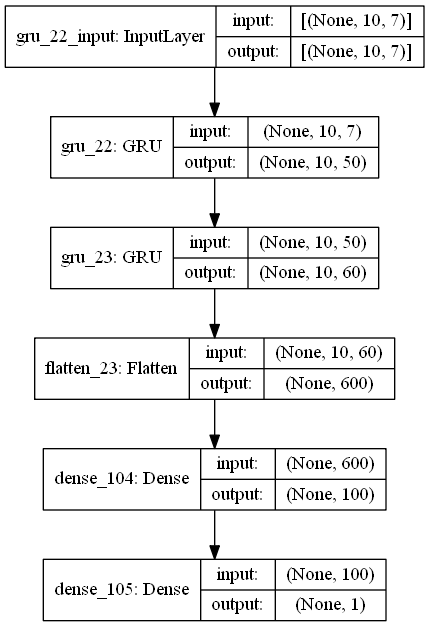

In [67]:
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(10,7)))
model.add(GRU(60, return_sequences=True))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(1))
plot_model(model, show_shapes=True)

In [68]:
model_list = []

for epoch in epochs:
    print(epoch)
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(10,7)))
    model.add(GRU(60, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(1))
    model.compile(loss=RMSE(max_v, min_v), optimizer=Adam(lr=0.001),
                 metrics=[MAE(max_v, min_v)])
    model.fit(x_train, y_train, epochs=epoch, batch_size=64)
    model_list.append(model)
    print('\n\n')

10
Epoch 1/10
33/33 [==============================] - 5s 8ms/step - loss: 253.3700 - mae: 240.3640
Epoch 2/10
33/33 [==============================] - 0s 8ms/step - loss: 50.8681 - mae: 40.9558
Epoch 3/10
33/33 [==============================] - 0s 9ms/step - loss: 41.3460 - mae: 31.8965
Epoch 4/10
33/33 [==============================] - 0s 8ms/step - loss: 39.1339 - mae: 31.0516
Epoch 5/10
33/33 [==============================] - 0s 9ms/step - loss: 38.5680 - mae: 31.0286
Epoch 6/10
33/33 [==============================] - 0s 8ms/step - loss: 39.2824 - mae: 32.4598
Epoch 7/10
33/33 [==============================] - 0s 9ms/step - loss: 32.2048 - mae: 25.2220
Epoch 8/10
33/33 [==============================] - 0s 9ms/step - loss: 38.4809 - mae: 31.6105
Epoch 9/10
33/33 [==============================] - 0s 9ms/step - loss: 29.7750 - mae: 22.3842
Epoch 10/10
33/33 [==============================] - 0s 8ms/step - loss: 32.3047 - mae: 26.0090



20
Epoch 1/20
33/33 [====================

33/33 [==============================] - 0s 8ms/step - loss: 31.1136 - mae: 23.8936
Epoch 15/60
33/33 [==============================] - 0s 8ms/step - loss: 35.1669 - mae: 28.6533
Epoch 16/60
33/33 [==============================] - 0s 8ms/step - loss: 29.8477 - mae: 23.5543
Epoch 17/60
33/33 [==============================] - 0s 8ms/step - loss: 28.7044 - mae: 22.6069
Epoch 18/60
33/33 [==============================] - ETA: 0s - loss: 32.9059 - mae: 26.8380- ETA: 0s - loss: 34.6677 - mae: 28.8 - 0s 8ms/step - loss: 32.3682 - mae: 26.2065
Epoch 19/60
33/33 [==============================] - 0s 7ms/step - loss: 28.9645 - mae: 22.7176
Epoch 20/60
33/33 [==============================] - 0s 8ms/step - loss: 31.8037 - mae: 25.2806
Epoch 21/60
33/33 [==============================] - ETA: 0s - loss: 29.4838 - mae: 22.930 - 0s 8ms/step - loss: 29.6429 - mae: 23.0691
Epoch 22/60
33/33 [==============================] - ETA: 0s - loss: 30.6659 - mae: 24.467 - 0s 8ms/step - loss: 30.3754 - mae

33/33 [==============================] - 0s 8ms/step - loss: 31.8182 - mae: 25.0865
Epoch 47/80
33/33 [==============================] - 0s 8ms/step - loss: 30.5575 - mae: 24.0703A: 0s - loss: 30.8371 - mae: 24.376
Epoch 48/80
33/33 [==============================] - 0s 8ms/step - loss: 27.4446 - mae: 20.8317
Epoch 49/80
33/33 [==============================] - 0s 8ms/step - loss: 31.6902 - mae: 25.3408
Epoch 50/80
33/33 [==============================] - 0s 7ms/step - loss: 27.3745 - mae: 20.9463A: 0s - loss: 26.6411 - mae: 20.33
Epoch 51/80
33/33 [==============================] - 0s 7ms/step - loss: 29.0898 - mae: 22.2692
Epoch 52/80
33/33 [==============================] - ETA: 0s - loss: 30.4102 - mae: 23.710 - 0s 7ms/step - loss: 30.3542 - mae: 23.6623
Epoch 53/80
33/33 [==============================] - 0s 7ms/step - loss: 30.4330 - mae: 23.4247A: 0s - loss: 31.3146 - mae: 23.8
Epoch 54/80
33/33 [==============================] - 0s 7ms/step - loss: 28.5766 - mae: 21.5144
Epoch 

33/33 [==============================] - 0s 8ms/step - loss: 29.5656 - mae: 22.3594
Epoch 38/100
33/33 [==============================] - 0s 8ms/step - loss: 28.1396 - mae: 21.5027
Epoch 39/100
33/33 [==============================] - 0s 9ms/step - loss: 28.1642 - mae: 21.8218
Epoch 40/100
33/33 [==============================] - 0s 8ms/step - loss: 30.2108 - mae: 23.7198
Epoch 41/100
33/33 [==============================] - 0s 7ms/step - loss: 28.4292 - mae: 21.7414
Epoch 42/100
33/33 [==============================] - 0s 7ms/step - loss: 28.4630 - mae: 21.8796
Epoch 43/100
33/33 [==============================] - 0s 7ms/step - loss: 26.9484 - mae: 20.8773
Epoch 44/100
33/33 [==============================] - 0s 7ms/step - loss: 28.2521 - mae: 21.6570
Epoch 45/100
33/33 [==============================] - 0s 7ms/step - loss: 28.9303 - mae: 21.6427
Epoch 46/100
33/33 [==============================] - 0s 8ms/step - loss: 27.8967 - mae: 20.8855
Epoch 47/100
33/33 [=======================

28/28 [==============================] - 1s 4ms/step - loss: 47.2151 - mae: 41.2043
(55.185, 40.7113, 0.958123960700616)


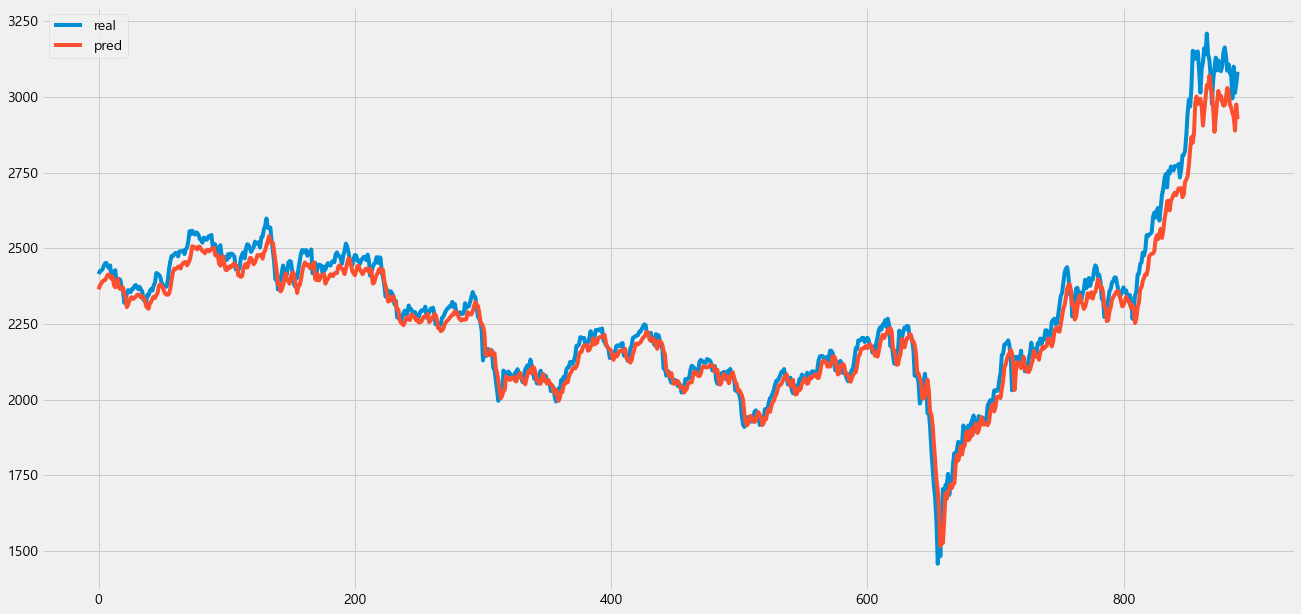

28/28 [==============================] - 1s 5ms/step - loss: 34.9725 - mae: 28.1152
(39.9604, 27.9212, 0.9780424454521232)


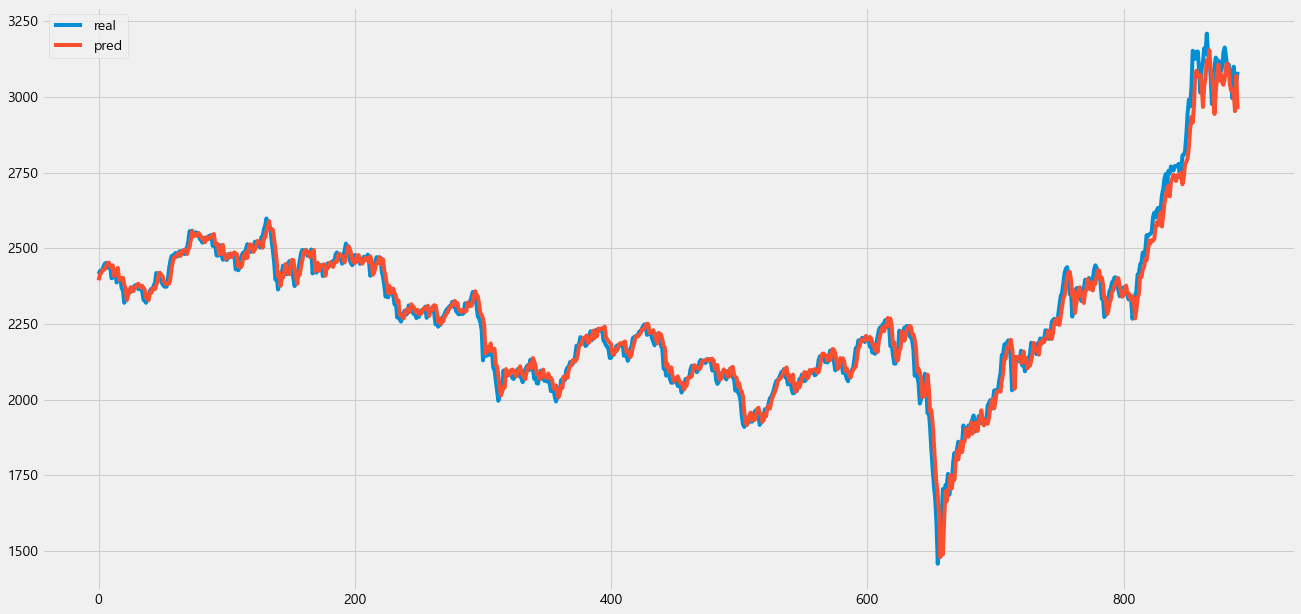

28/28 [==============================] - 1s 5ms/step - loss: 40.2496 - mae: 33.9024
(45.8458, 33.6636, 0.9710983291869936)


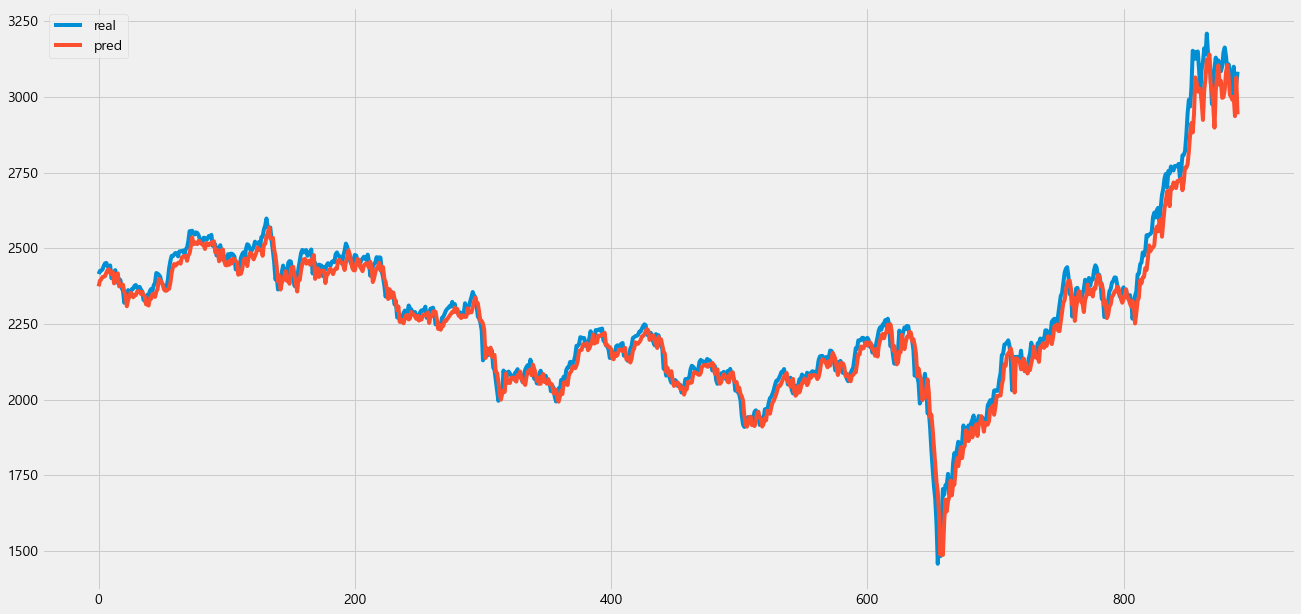

28/28 [==============================] - 2s 4ms/step - loss: 38.6002 - mae: 32.1963
(44.3137, 31.9094, 0.9729977712722236)


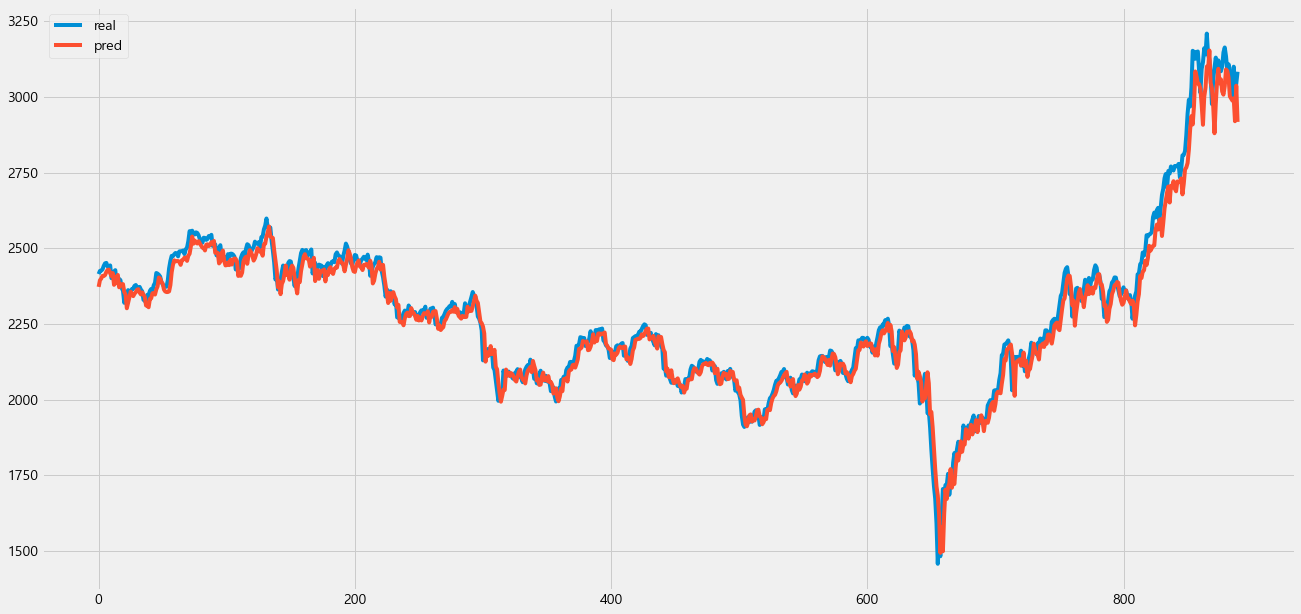

28/28 [==============================] - 1s 4ms/step - loss: 35.1519 - mae: 28.3856
(40.4135, 28.1647, 0.977541702680952)


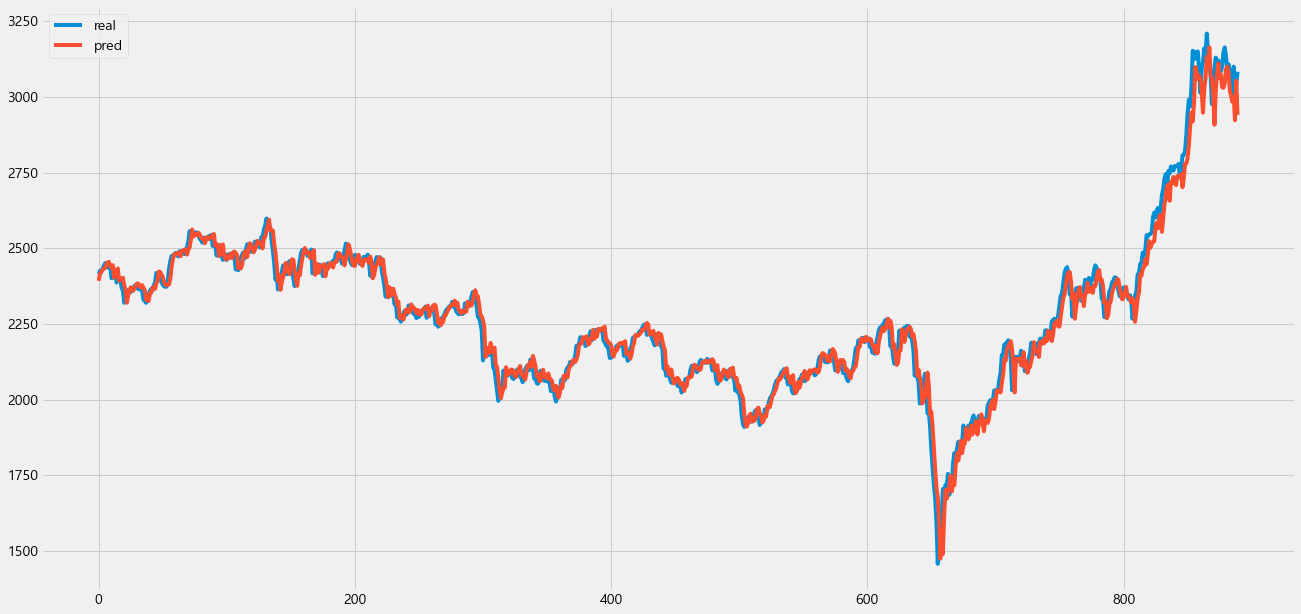

28/28 [==============================] - 1s 4ms/step - loss: 43.9769 - mae: 37.9019
(50.683, 37.4913, 0.9646777467163564)


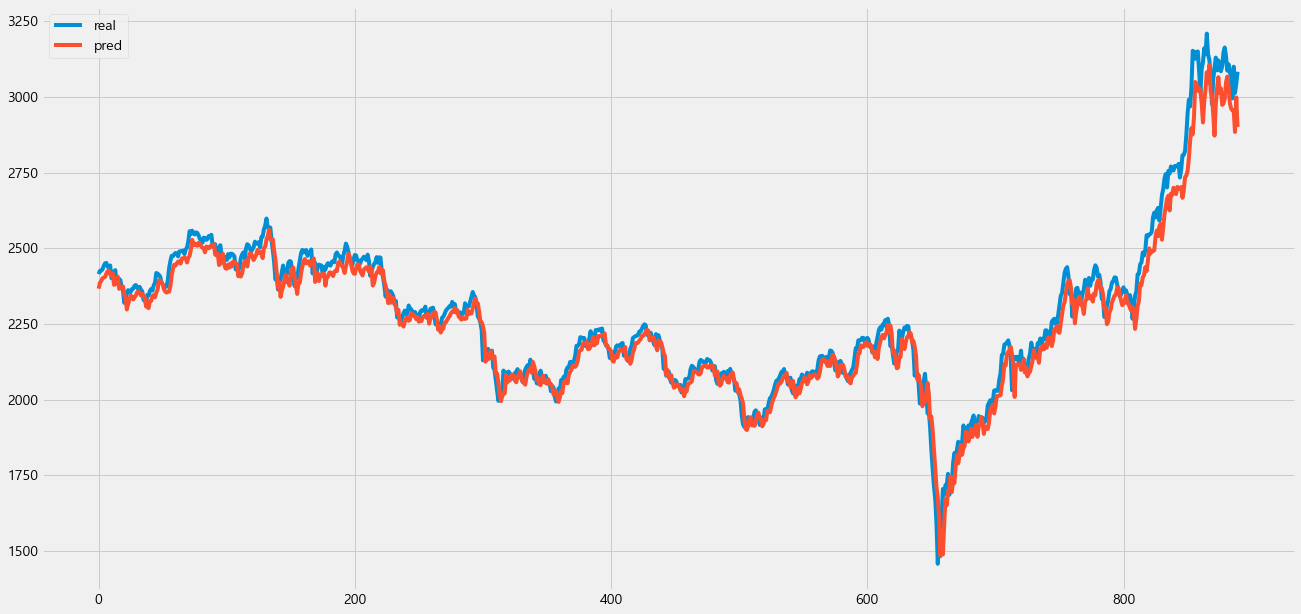

28/28 [==============================] - 1s 5ms/step - loss: 45.0790 - mae: 38.5933
(49.879, 38.3099, 0.9657895337524204)


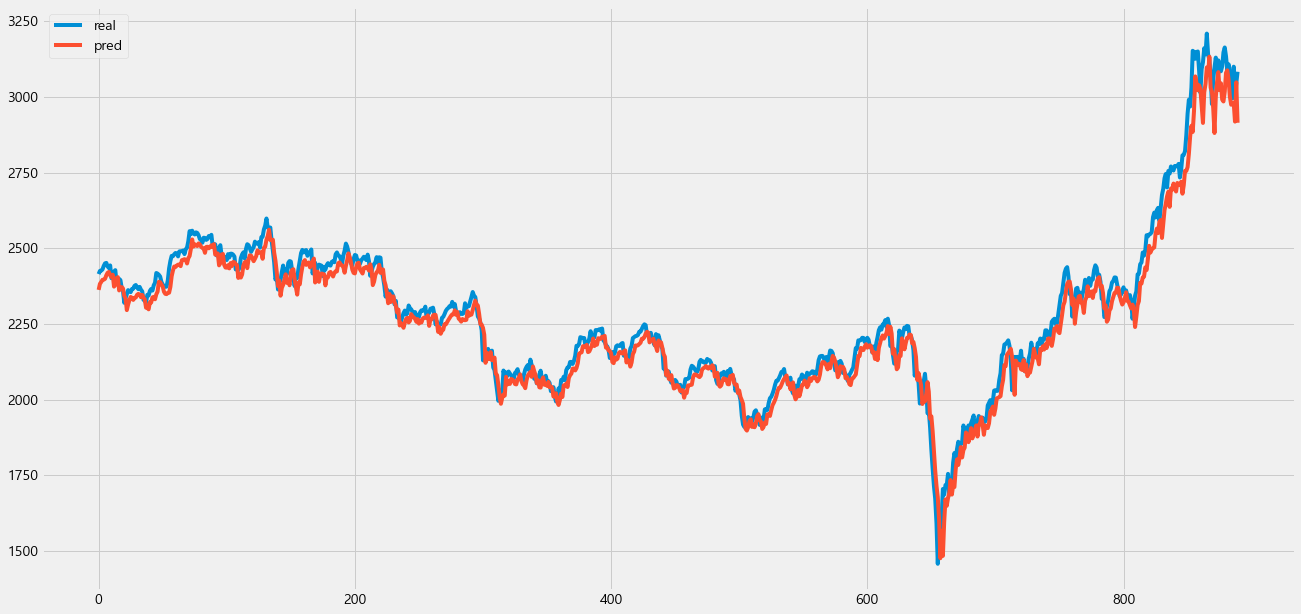

28/28 [==============================] - 1s 4ms/step - loss: 41.8766 - mae: 35.2966
(46.1104, 35.1083, 0.9707637627785133)


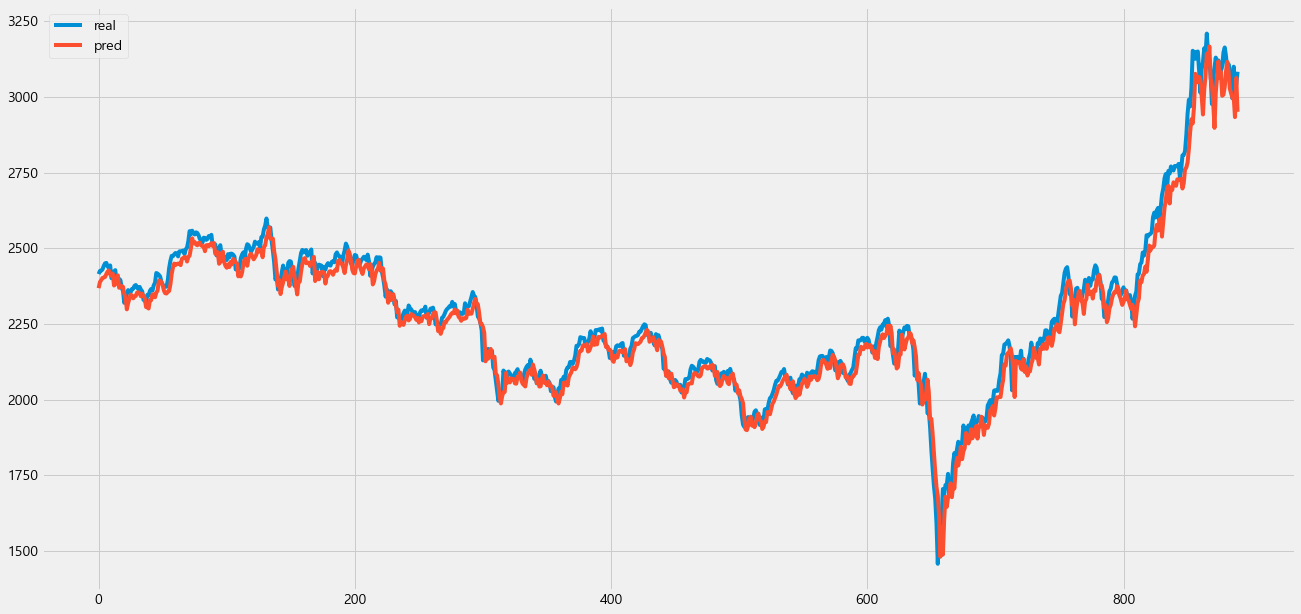

28/28 [==============================] - 1s 4ms/step - loss: 43.1174 - mae: 36.6694
(48.3485, 36.3694, 0.9678567418584159)


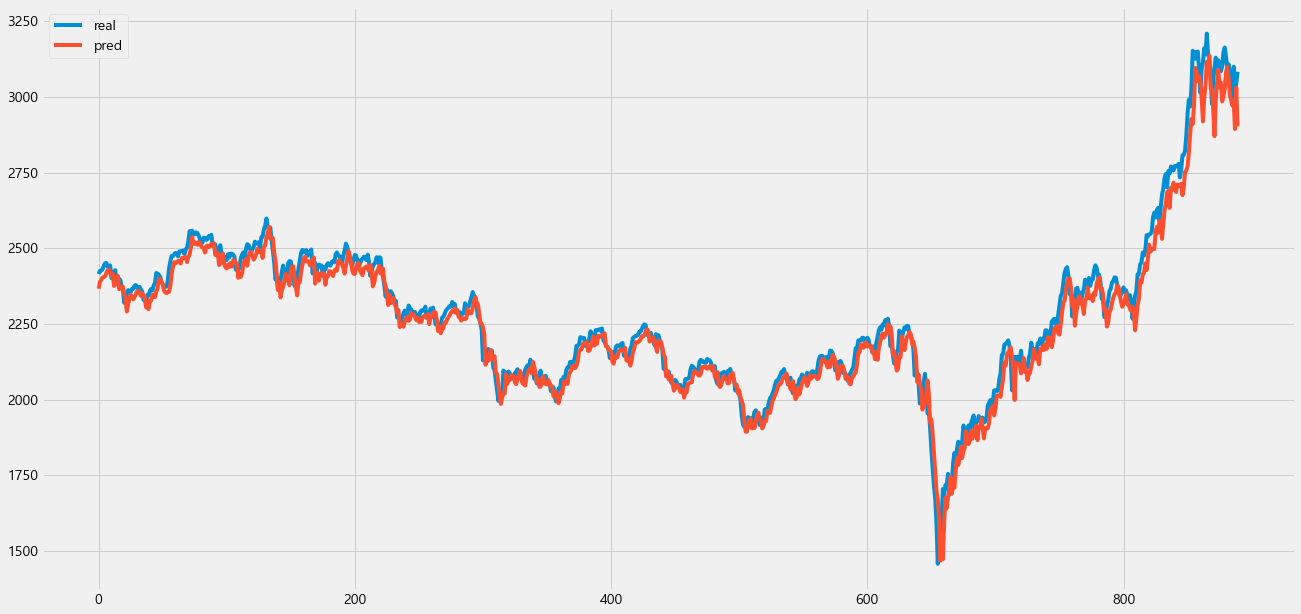

28/28 [==============================] - 1s 4ms/step - loss: 36.1763 - mae: 28.8972
(40.7771, 28.7242, 0.9771357429543517)


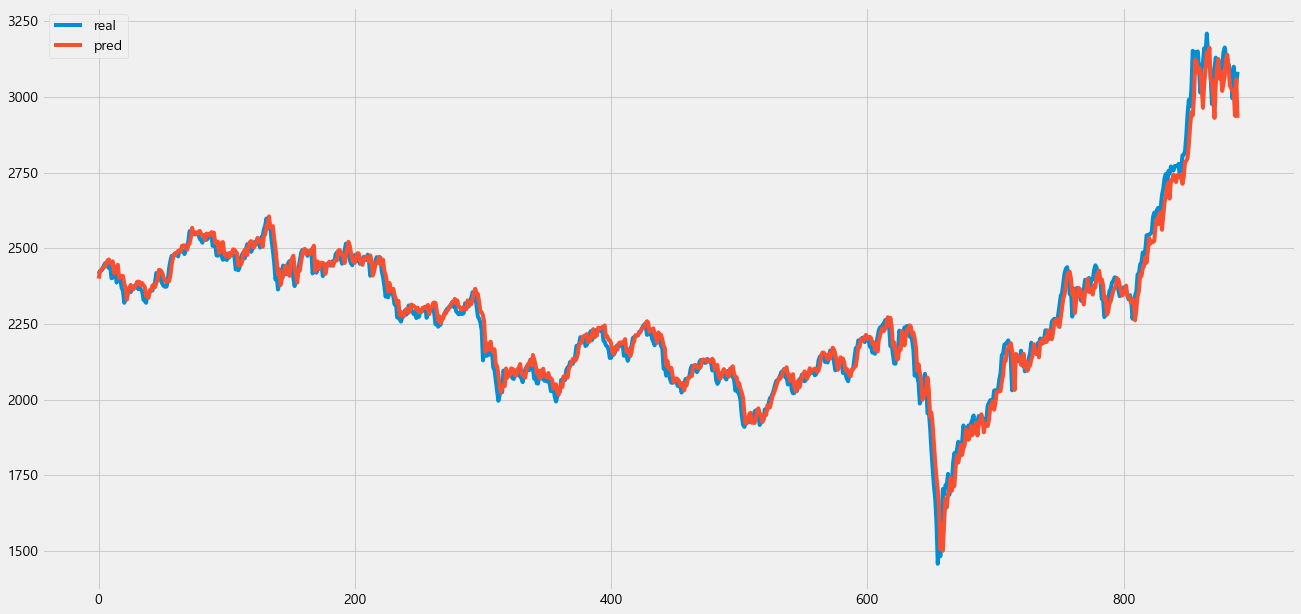

In [69]:
loss_list = []

for epoch, model in zip(epochs,model_list):
    model.evaluate(x_test, y_test)
    pred = model.predict(x_test)
    pred = np.squeeze(pred)

    actual = inverse_data(y_test, max_v, min_v)
    pred = inverse_data(pred, max_v, min_v)
    
    rmse, mae, r2 = get_loss(actual, pred)
    loss_list.append([epoch, rmse, mae, r2])
    print(get_loss(actual, pred))
    plt.plot(actual)
    plt.plot(pred)
    plt.legend(['real', 'pred'])
    plt.show()

In [70]:
loss_list

[[10, 55.185, 40.7113, 0.958123960700616],
 [20, 39.9604, 27.9212, 0.9780424454521232],
 [30, 45.8458, 33.6636, 0.9710983291869936],
 [40, 44.3137, 31.9094, 0.9729977712722236],
 [50, 40.4135, 28.1647, 0.977541702680952],
 [60, 50.683, 37.4913, 0.9646777467163564],
 [70, 49.879, 38.3099, 0.9657895337524204],
 [80, 46.1104, 35.1083, 0.9707637627785133],
 [90, 48.3485, 36.3694, 0.9678567418584159],
 [100, 40.7771, 28.7242, 0.9771357429543517]]

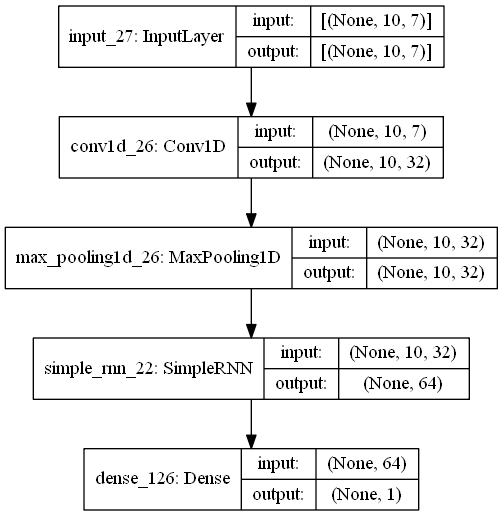

In [71]:
model = Sequential()
model.add(Input(shape=(10, 7)))
model.add(Conv1D(32, 1, activation='tanh', padding='same'))
model.add(MaxPooling1D(1, padding='same'))
model.add(SimpleRNN(64, activation='tanh'))
model.add(Dense(1))
plot_model(model, show_shapes=True)

In [72]:
model_list = []

for epoch in epochs:
    print(epoch)
    model = Sequential()
    model.add(Input(shape=(10, 7)))
    model.add(Conv1D(32, 1, activation='tanh', padding='same'))
    model.add(MaxPooling1D(1, padding='same'))
    model.add(SimpleRNN(64, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss=RMSE(max_v, min_v), optimizer=Adam(lr=0.001),
                 metrics=[MAE(max_v, min_v)])
    model.fit(x_train, y_train, epochs=epoch, batch_size=64)
    model_list.append(model)
    print('\n\n')

10
Epoch 1/10
33/33 [==============================] - 2s 18ms/step - loss: 232.2890 - mae: 216.9325
Epoch 2/10
33/33 [==============================] - 1s 19ms/step - loss: 53.0464 - mae: 42.2713
Epoch 3/10
33/33 [==============================] - 1s 19ms/step - loss: 37.0870 - mae: 28.5864
Epoch 4/10
33/33 [==============================] - 1s 20ms/step - loss: 42.5434 - mae: 35.3969
Epoch 5/10
33/33 [==============================] - 1s 19ms/step - loss: 33.0056 - mae: 25.0645: 0s - loss: 32.8473 - mae: 24.8
Epoch 6/10
33/33 [==============================] - 1s 19ms/step - loss: 39.6265 - mae: 31.9892
Epoch 7/10
33/33 [==============================] - 1s 18ms/step - loss: 39.3189 - mae: 32.5485
Epoch 8/10
33/33 [==============================] - 1s 18ms/step - loss: 30.9476 - mae: 24.0836
Epoch 9/10
33/33 [==============================] - 1s 19ms/step - loss: 32.6646 - mae: 25.5420
Epoch 10/10
33/33 [==============================] - 1s 20ms/step - loss: 33.0788 - mae: 25.9092




33/33 [==============================] - 1s 19ms/step - loss: 47.8545 - mae: 41.0240: 0s - loss: 49.7944 - mae: 42. - ETA: 0s - loss: 48.2860 - mae: 41.4
Epoch 12/60
33/33 [==============================] - 1s 23ms/step - loss: 43.5553 - mae: 37.5892
Epoch 13/60
33/33 [==============================] - 1s 20ms/step - loss: 39.4027 - mae: 32.5332
Epoch 14/60
33/33 [==============================] - 1s 21ms/step - loss: 37.4498 - mae: 30.3595
Epoch 15/60
33/33 [==============================] - 1s 19ms/step - loss: 45.2017 - mae: 38.9028
Epoch 16/60
33/33 [==============================] - 1s 22ms/step - loss: 38.3523 - mae: 31.4163
Epoch 17/60
33/33 [==============================] - 1s 19ms/step - loss: 33.1302 - mae: 26.5956
Epoch 18/60
33/33 [==============================] - 1s 22ms/step - loss: 30.2806 - mae: 23.4801
Epoch 19/60
33/33 [==============================] - 1s 20ms/step - loss: 35.1481 - mae: 28.9841
Epoch 20/60
33/33 [==============================] - 1s 21ms/step - lo

33/33 [==============================] - 1s 18ms/step - loss: 33.5393 - mae: 26.5054
Epoch 40/80
33/33 [==============================] - 1s 18ms/step - loss: 31.0497 - mae: 24.5769
Epoch 41/80
33/33 [==============================] - 1s 18ms/step - loss: 29.7522 - mae: 23.4355
Epoch 42/80
33/33 [==============================] - 1s 17ms/step - loss: 29.2174 - mae: 22.0174: 0s - loss: 28.9413 - mae: 21.6
Epoch 43/80
33/33 [==============================] - 1s 17ms/step - loss: 30.8242 - mae: 24.4337: 0s - loss: 30.8486 - mae: 24.47
Epoch 44/80
33/33 [==============================] - 1s 20ms/step - loss: 32.6782 - mae: 26.1529: 0s - loss: 32.7076 - mae: 26.181
Epoch 45/80
33/33 [==============================] - 1s 17ms/step - loss: 31.6697 - mae: 24.4932
Epoch 46/80
33/33 [==============================] - 1s 17ms/step - loss: 28.2805 - mae: 21.4929
Epoch 47/80
33/33 [==============================] - 1s 18ms/step - loss: 29.9308 - mae: 23.4930
Epoch 48/80
33/33 [=====================

33/33 [==============================] - 1s 17ms/step - loss: 28.6781 - mae: 21.9934
Epoch 30/100
33/33 [==============================] - 1s 17ms/step - loss: 35.1778 - mae: 27.9896
Epoch 31/100
33/33 [==============================] - 1s 20ms/step - loss: 30.3324 - mae: 23.2472
Epoch 32/100
33/33 [==============================] - 1s 21ms/step - loss: 30.3656 - mae: 23.6358
Epoch 33/100
33/33 [==============================] - 1s 19ms/step - loss: 31.2353 - mae: 24.7632
Epoch 34/100
33/33 [==============================] - 1s 19ms/step - loss: 31.4517 - mae: 24.7746
Epoch 35/100
33/33 [==============================] - 1s 18ms/step - loss: 35.1010 - mae: 28.5763
Epoch 36/100
33/33 [==============================] - 1s 20ms/step - loss: 29.3761 - mae: 22.9323: 0s - loss: 26.5197 - mae: 
Epoch 37/100
33/33 [==============================] - 1s 17ms/step - loss: 31.5099 - mae: 25.5488: 0s - loss: 29.6907 - mae: 24.128 - ETA: 0s - loss: 30.2547 - mae: 24.
Epoch 38/100
33/33 [============

28/28 [==============================] - 0s 6ms/step - loss: 81.2644 - mae: 76.2841
(108.2254, 74.3357, 0.8389422482482578)


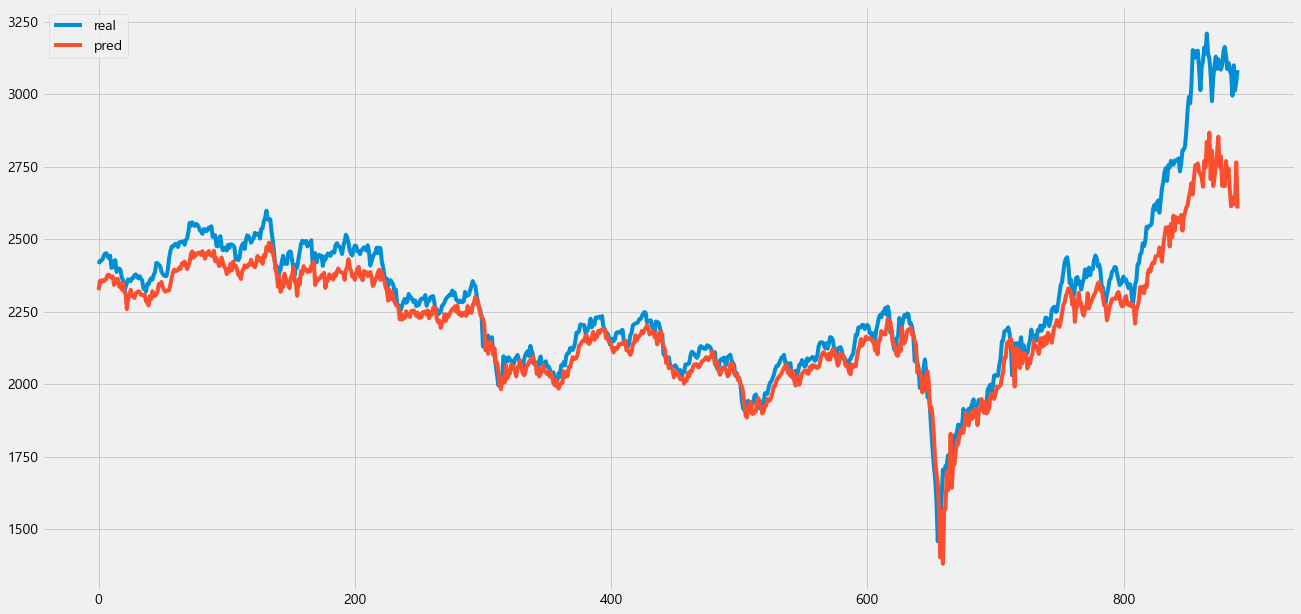

28/28 [==============================] - 0s 5ms/step - loss: 58.1631 - mae: 52.5873
(74.6099, 51.44, 0.9234549827149834)


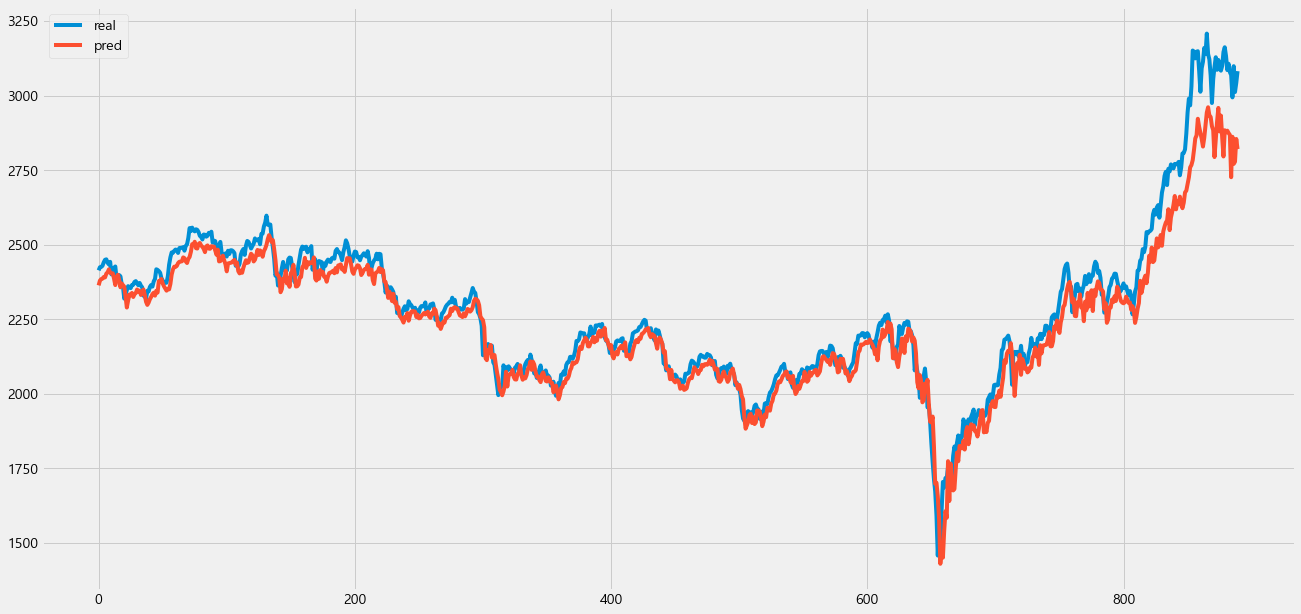

28/28 [==============================] - 0s 4ms/step - loss: 45.9070 - mae: 40.2698
(59.9888, 39.3836, 0.9505161391379009)


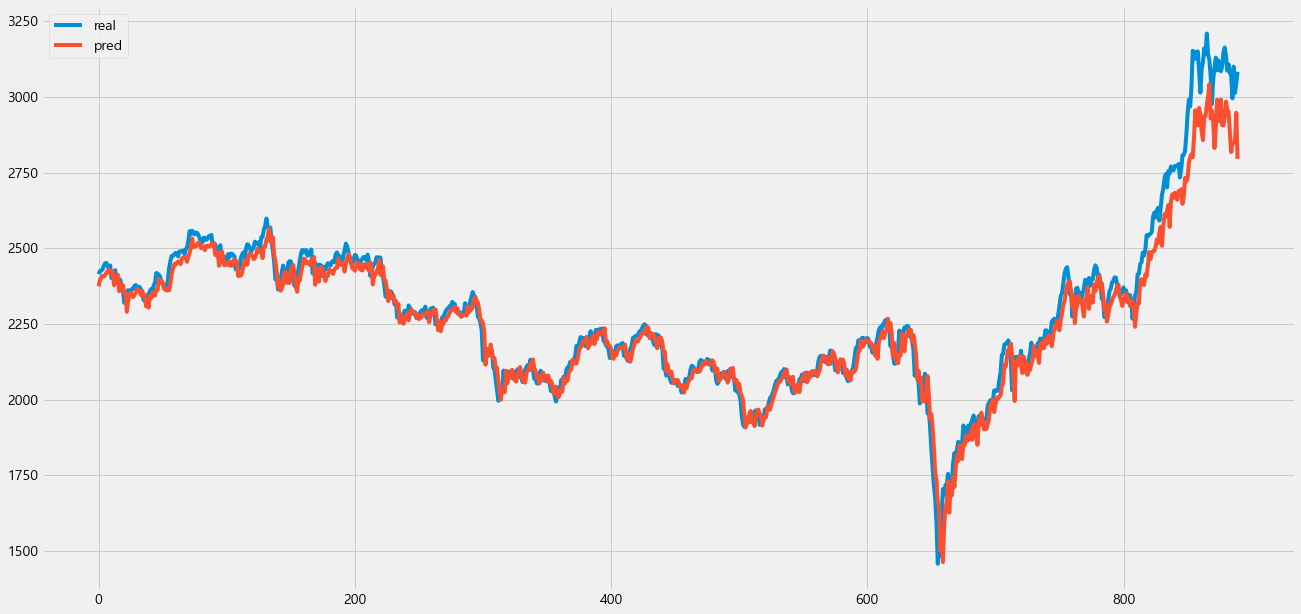

28/28 [==============================] - 0s 5ms/step - loss: 46.8171 - mae: 41.2950
(64.1698, 40.1849, 0.9433780851061976)


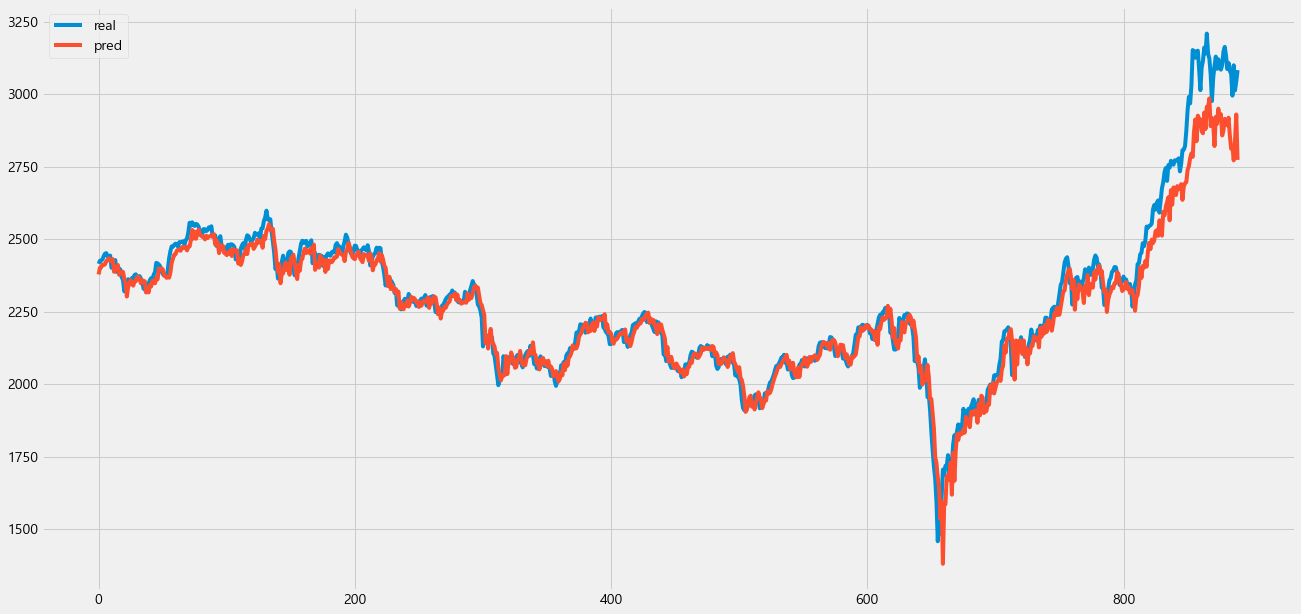

28/28 [==============================] - 0s 5ms/step - loss: 38.4866 - mae: 32.1748
(46.4056, 31.6271, 0.9703881938360325)


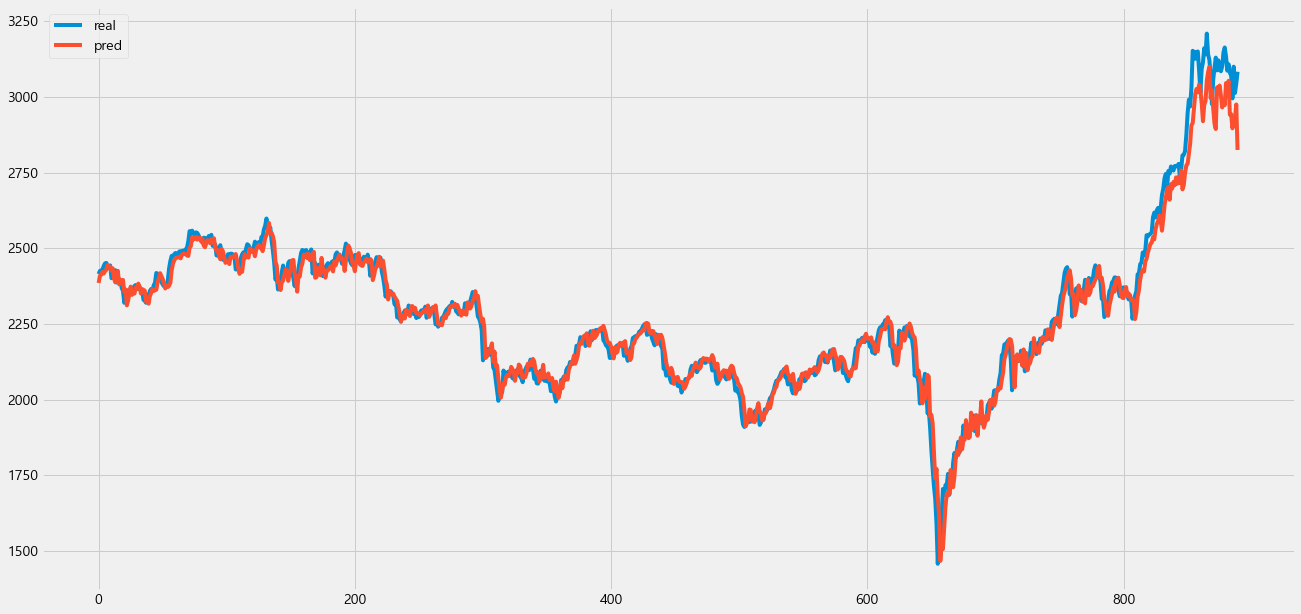

28/28 [==============================] - 0s 5ms/step - loss: 42.1315 - mae: 35.6643
(54.2204, 34.8731, 0.9595750480878587)


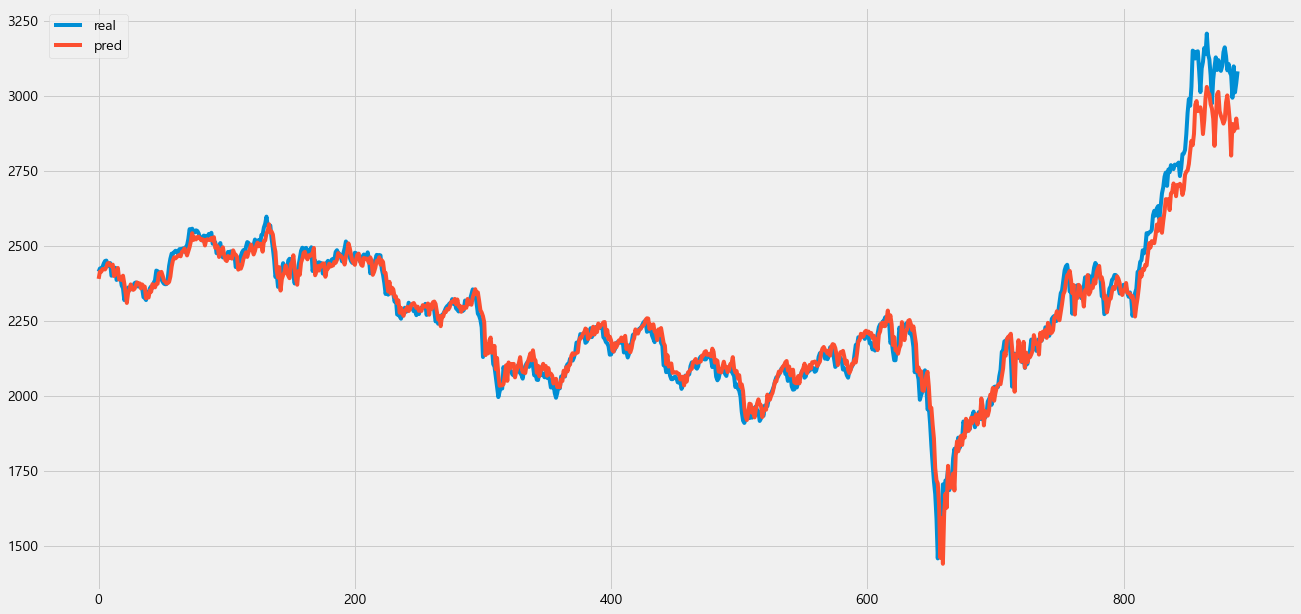

28/28 [==============================] - 0s 4ms/step - loss: 39.5620 - mae: 32.1256
(46.0016, 31.6656, 0.970901543089455)


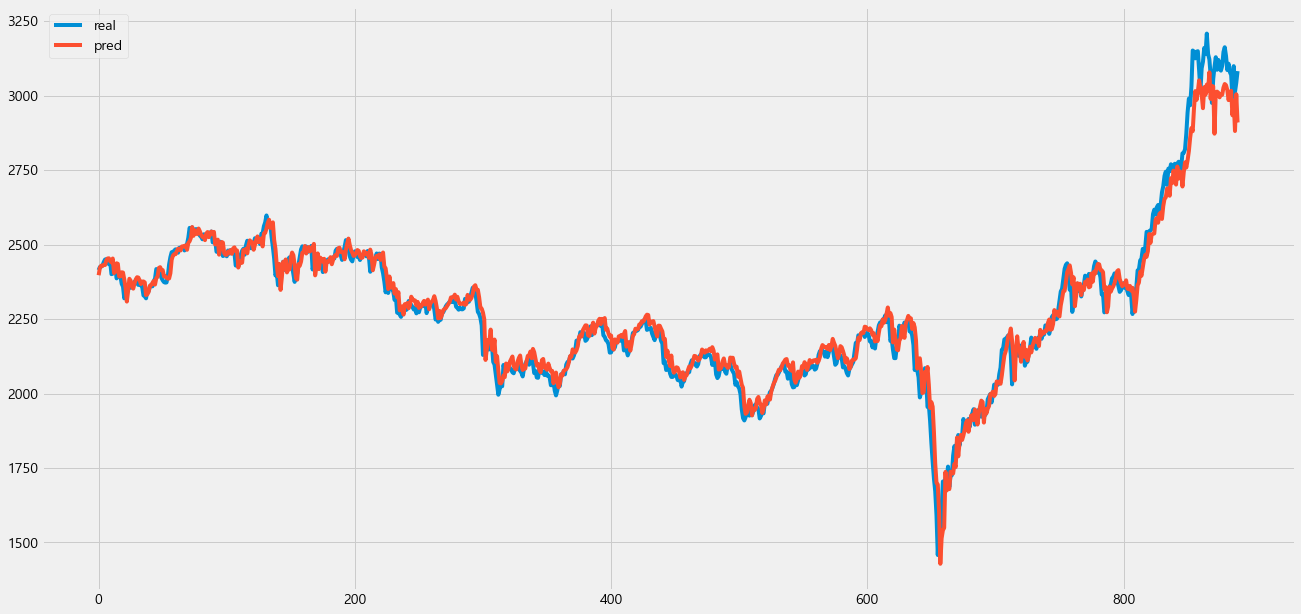

28/28 [==============================] - 0s 5ms/step - loss: 49.0257 - mae: 43.2854
(59.3892, 42.5161, 0.9515003563392975)


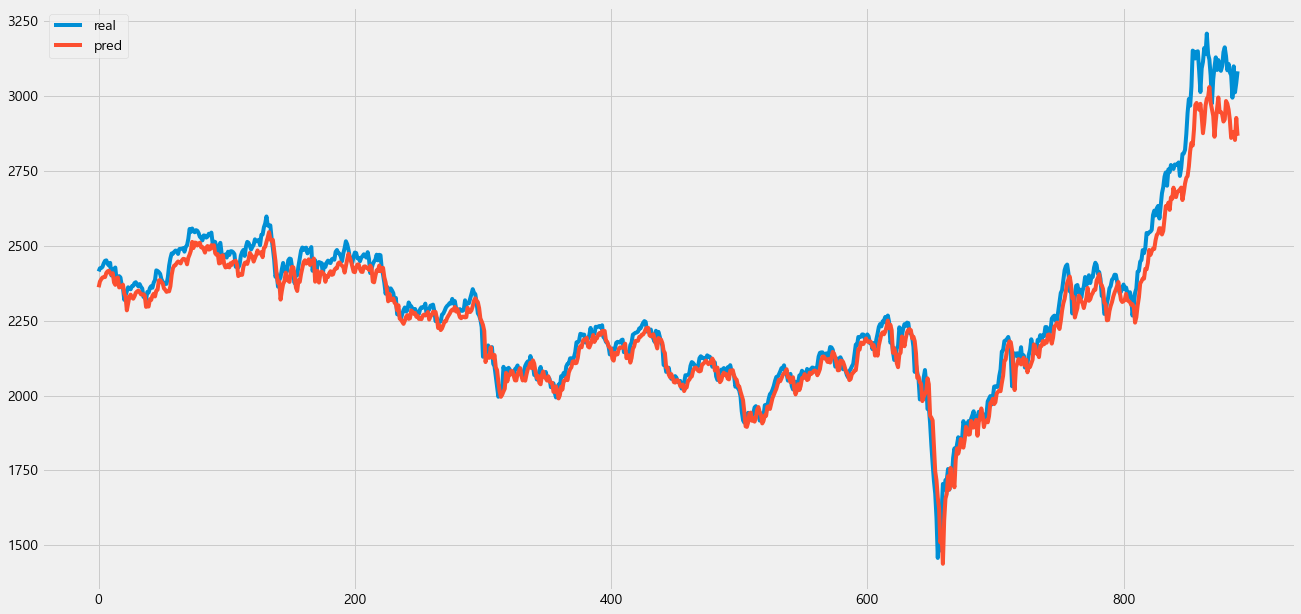

28/28 [==============================] - 0s 5ms/step - loss: 42.2461 - mae: 36.2692
(54.4505, 35.4701, 0.959231277065391)


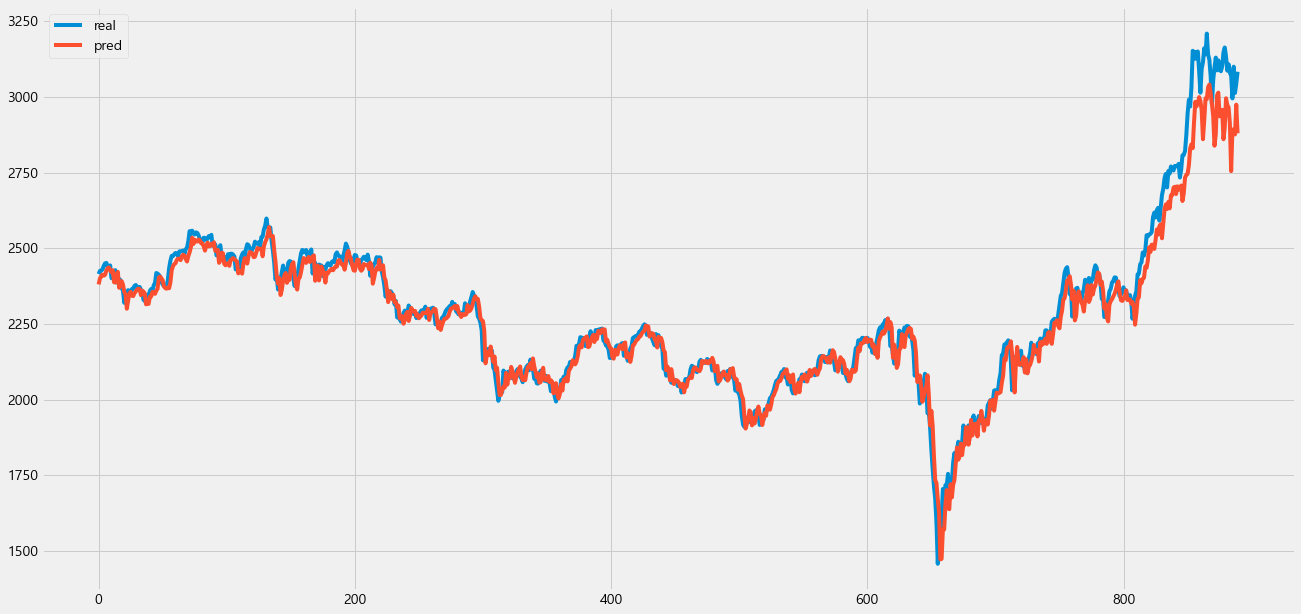

28/28 [==============================] - 0s 4ms/step - loss: 58.5614 - mae: 52.5672
(70.5896, 51.591, 0.9314819028179097)


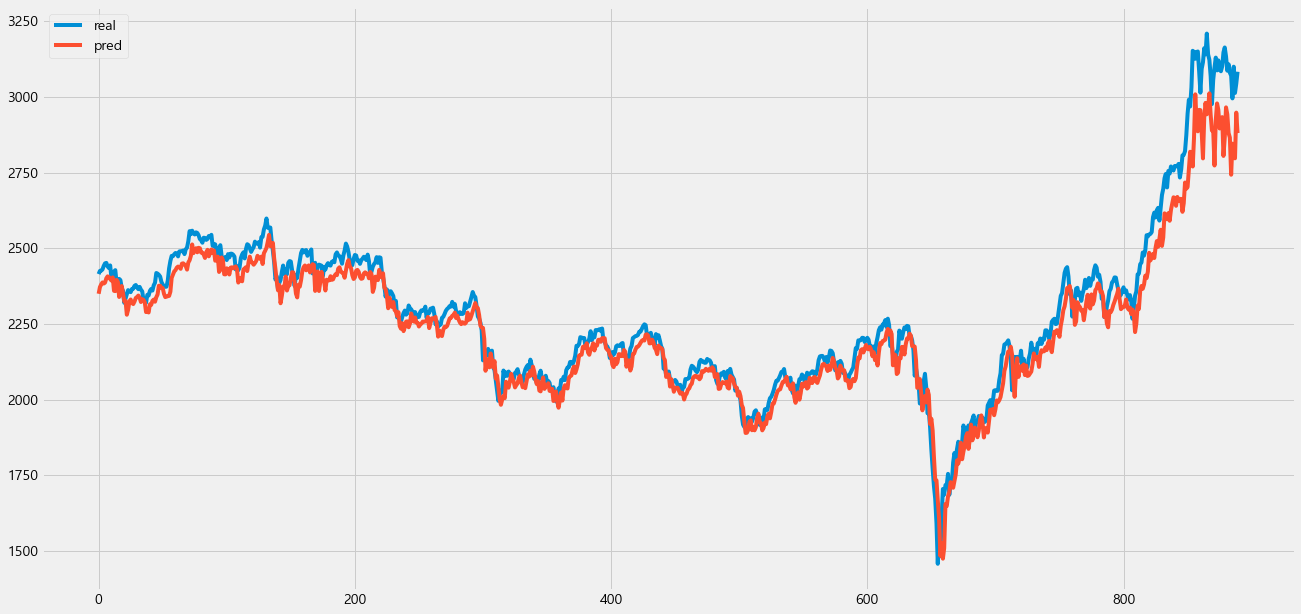

In [73]:
loss_list = []

for epoch, model in zip(epochs,model_list):
    model.evaluate(x_test, y_test)
    pred = model.predict(x_test)
    pred = np.squeeze(pred)

    actual = inverse_data(y_test, max_v, min_v)
    pred = inverse_data(pred, max_v, min_v)
    
    rmse, mae, r2 = get_loss(actual, pred)
    loss_list.append([epoch, rmse, mae, r2])
    print(get_loss(actual, pred))
    plt.plot(actual)
    plt.plot(pred)
    plt.legend(['real', 'pred'])
    plt.show()

In [74]:
loss_list

[[10, 108.2254, 74.3357, 0.8389422482482578],
 [20, 74.6099, 51.44, 0.9234549827149834],
 [30, 59.9888, 39.3836, 0.9505161391379009],
 [40, 64.1698, 40.1849, 0.9433780851061976],
 [50, 46.4056, 31.6271, 0.9703881938360325],
 [60, 54.2204, 34.8731, 0.9595750480878587],
 [70, 46.0016, 31.6656, 0.970901543089455],
 [80, 59.3892, 42.5161, 0.9515003563392975],
 [90, 54.4505, 35.4701, 0.959231277065391],
 [100, 70.5896, 51.591, 0.9314819028179097]]

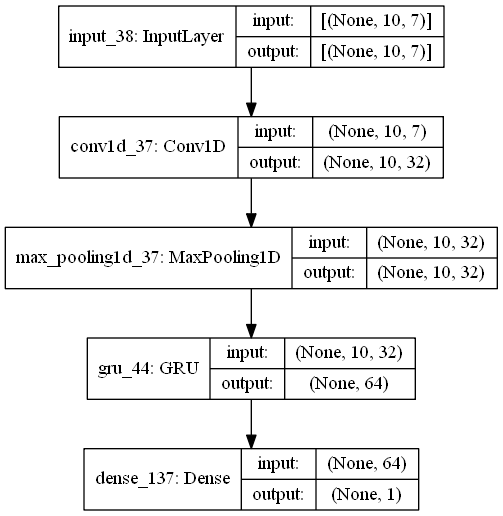

In [75]:
model = Sequential()
model.add(Input(shape=(10, 7)))
model.add(Conv1D(32, 1, activation='tanh', padding='same'))
model.add(MaxPooling1D(1, padding='same'))
model.add(GRU(64, activation='tanh'))
model.add(Dense(1))
plot_model(model, show_shapes=True)

In [76]:
model_list = []

for epoch in epochs:
    print(epoch)
    model = Sequential()
    model.add(Input(shape=(10, 7)))
    model.add(Conv1D(32, 1, activation='tanh', padding='same'))
    model.add(MaxPooling1D(1, padding='same'))
    model.add(GRU(64, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss=RMSE(max_v, min_v), optimizer=Adam(lr=0.001),
                 metrics=[MAE(max_v, min_v)])
    model.fit(x_train, y_train, epochs=epoch, batch_size=64)
    model_list.append(model)
    print('\n\n')

10
Epoch 1/10
33/33 [==============================] - 2s 6ms/step - loss: 481.4400 - mae: 463.0656
Epoch 2/10
33/33 [==============================] - 0s 5ms/step - loss: 47.9771 - mae: 39.8548
Epoch 3/10
33/33 [==============================] - 0s 6ms/step - loss: 30.4462 - mae: 23.3962
Epoch 4/10
33/33 [==============================] - 0s 6ms/step - loss: 32.4435 - mae: 25.1107
Epoch 5/10
33/33 [==============================] - 0s 7ms/step - loss: 30.3151 - mae: 23.7867
Epoch 6/10
33/33 [==============================] - 0s 7ms/step - loss: 34.1921 - mae: 27.5386
Epoch 7/10
33/33 [==============================] - 0s 5ms/step - loss: 31.0107 - mae: 24.2828
Epoch 8/10
33/33 [==============================] - 0s 5ms/step - loss: 31.6334 - mae: 24.8968
Epoch 9/10
33/33 [==============================] - 0s 6ms/step - loss: 28.0173 - mae: 21.6661
Epoch 10/10
33/33 [==============================] - 0s 6ms/step - loss: 28.3304 - mae: 21.9042



20
Epoch 1/20
33/33 [====================

33/33 [==============================] - 0s 6ms/step - loss: 26.5458 - mae: 20.5745
Epoch 13/60
33/33 [==============================] - 0s 5ms/step - loss: 28.3057 - mae: 21.1544
Epoch 14/60
33/33 [==============================] - 0s 6ms/step - loss: 29.7129 - mae: 22.7098
Epoch 15/60
33/33 [==============================] - 0s 5ms/step - loss: 27.3338 - mae: 20.8604
Epoch 16/60
33/33 [==============================] - 0s 5ms/step - loss: 28.7702 - mae: 22.5070
Epoch 17/60
33/33 [==============================] - 0s 5ms/step - loss: 28.7565 - mae: 22.1075
Epoch 18/60
33/33 [==============================] - 0s 5ms/step - loss: 27.1420 - mae: 19.8426
Epoch 19/60
33/33 [==============================] - 0s 5ms/step - loss: 27.0428 - mae: 20.9276
Epoch 20/60
33/33 [==============================] - 0s 6ms/step - loss: 26.6063 - mae: 20.2263
Epoch 21/60
33/33 [==============================] - 0s 5ms/step - loss: 28.4149 - mae: 21.8454A: 0s - loss: 28.3149 - mae: 21.834 - ETA: 0s - loss:

33/33 [==============================] - 0s 7ms/step - loss: 28.4644 - mae: 21.7053
Epoch 36/70
33/33 [==============================] - 0s 7ms/step - loss: 26.4826 - mae: 20.3413
Epoch 37/70
33/33 [==============================] - 0s 6ms/step - loss: 27.7165 - mae: 21.1140
Epoch 38/70
33/33 [==============================] - 0s 6ms/step - loss: 26.4750 - mae: 19.9361
Epoch 39/70
33/33 [==============================] - 0s 6ms/step - loss: 27.1966 - mae: 20.6869
Epoch 40/70
33/33 [==============================] - 0s 5ms/step - loss: 26.5464 - mae: 19.7564
Epoch 41/70
33/33 [==============================] - 0s 6ms/step - loss: 27.6088 - mae: 21.4238
Epoch 42/70
33/33 [==============================] - 0s 6ms/step - loss: 28.3776 - mae: 21.6624
Epoch 43/70
33/33 [==============================] - 0s 5ms/step - loss: 28.0475 - mae: 21.4793A: 0s - loss: 28.1257 - mae: 21.570
Epoch 44/70
33/33 [==============================] - 0s 6ms/step - loss: 29.1583 - mae: 22.0124
Epoch 45/70
33/33

33/33 [==============================] - 0s 5ms/step - loss: 29.3531 - mae: 22.4016
Epoch 47/90
33/33 [==============================] - 0s 5ms/step - loss: 27.0542 - mae: 20.7575
Epoch 48/90
33/33 [==============================] - 0s 6ms/step - loss: 26.6568 - mae: 20.1519
Epoch 49/90
33/33 [==============================] - 0s 6ms/step - loss: 27.1777 - mae: 20.3932
Epoch 50/90
33/33 [==============================] - 0s 5ms/step - loss: 26.9480 - mae: 20.6382
Epoch 51/90
33/33 [==============================] - 0s 7ms/step - loss: 35.6858 - mae: 28.8725
Epoch 52/90
33/33 [==============================] - 0s 6ms/step - loss: 29.3855 - mae: 21.8236
Epoch 53/90
33/33 [==============================] - 0s 6ms/step - loss: 26.0491 - mae: 19.9289
Epoch 54/90
33/33 [==============================] - 0s 6ms/step - loss: 28.8790 - mae: 21.9337
Epoch 55/90
33/33 [==============================] - 0s 6ms/step - loss: 29.1748 - mae: 22.8778
Epoch 56/90
33/33 [==============================] -

28/28 [==============================] - 1s 3ms/step - loss: 38.1739 - mae: 31.9864
(45.395, 31.629, 0.971663926622164)


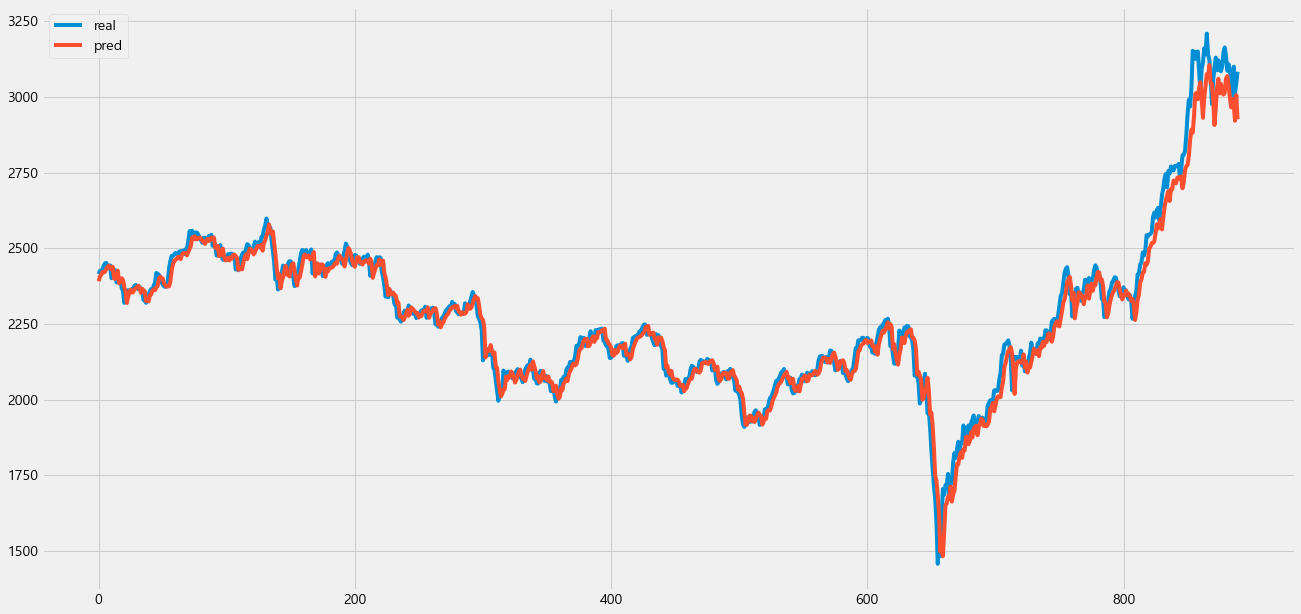

28/28 [==============================] - 0s 4ms/step - loss: 45.8654 - mae: 39.9836
(54.3366, 39.3736, 0.9594015783589236)


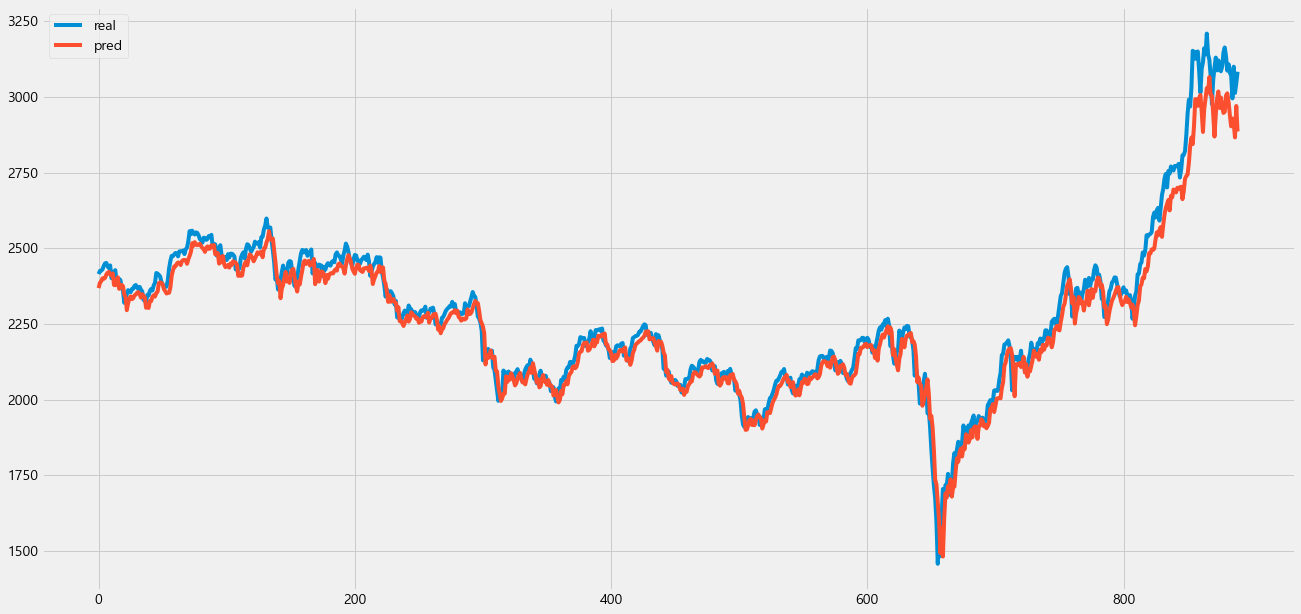

28/28 [==============================] - 1s 3ms/step - loss: 36.2535 - mae: 29.5351
(42.9217, 29.1445, 0.974667527103306)


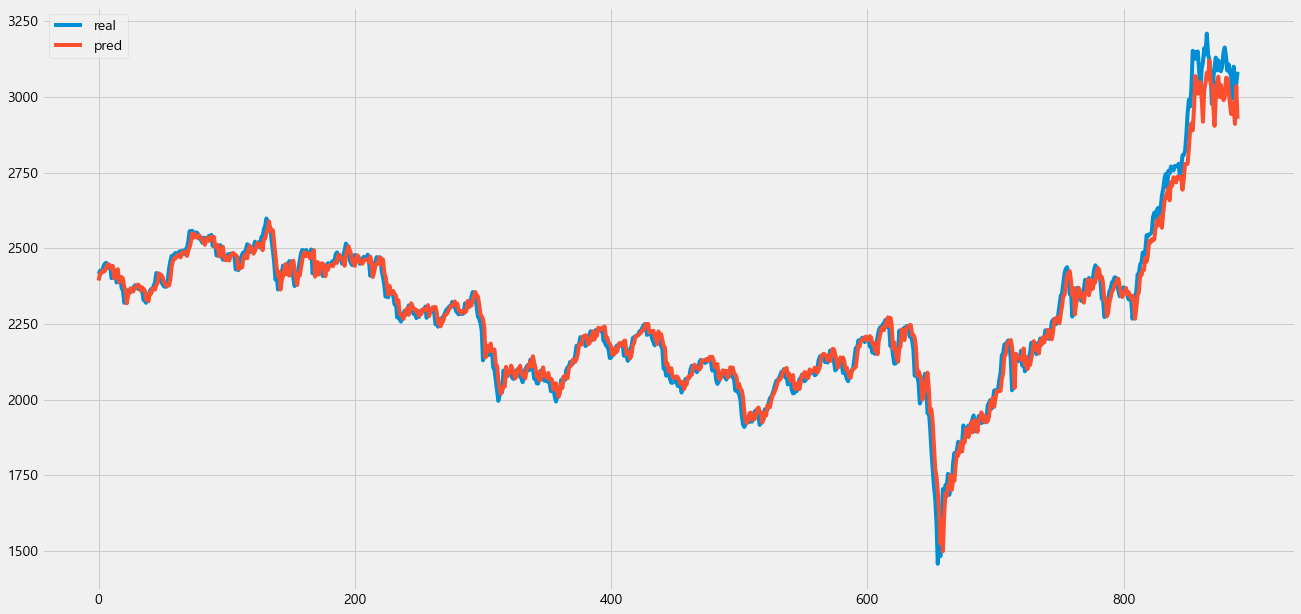

28/28 [==============================] - 1s 4ms/step - loss: 34.5807 - mae: 27.8894
(39.2993, 27.7055, 0.9787629871240218)


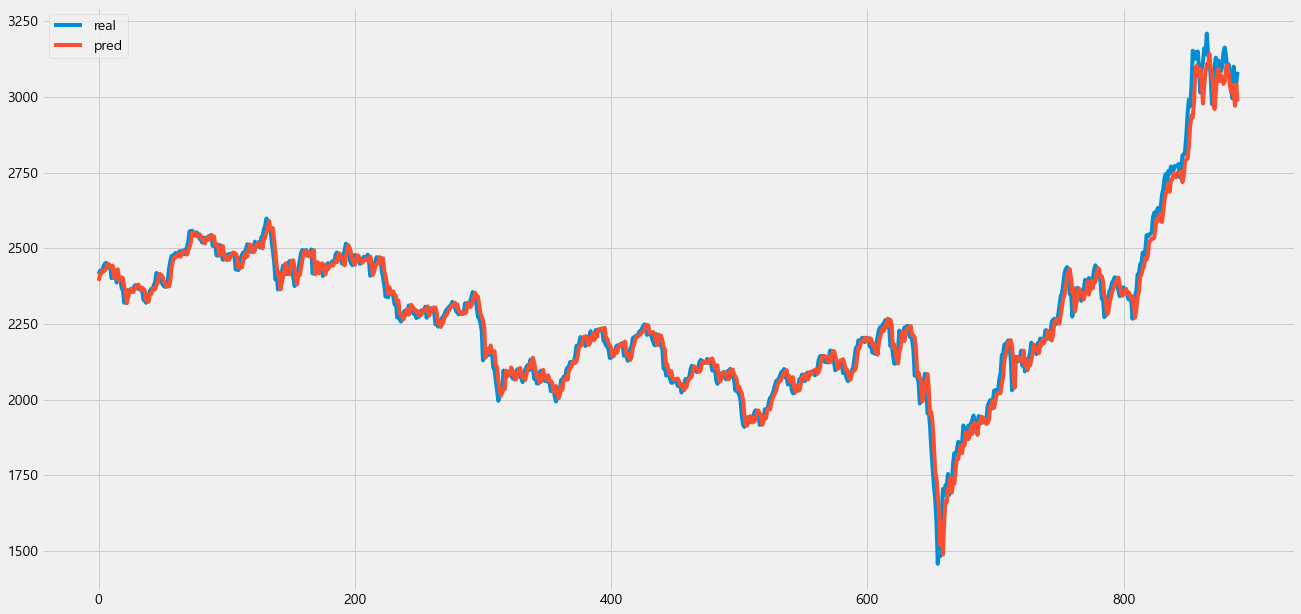

28/28 [==============================] - 0s 3ms/step - loss: 35.9095 - mae: 29.3112
(42.0694, 28.9845, 0.9756636134393127)


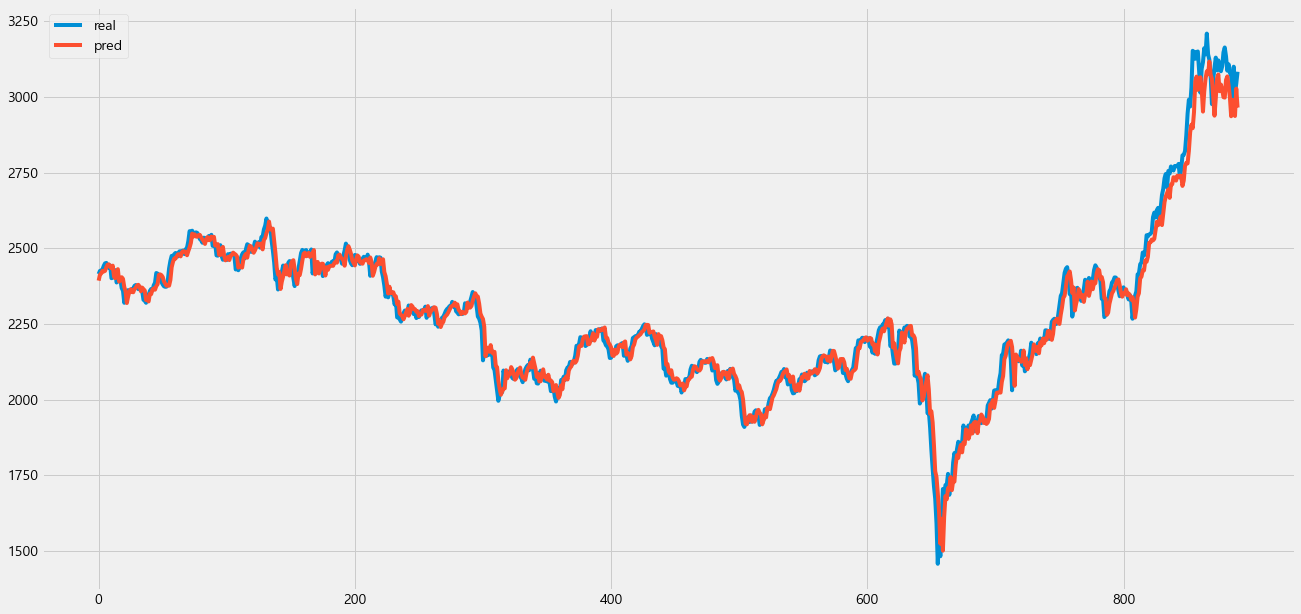

28/28 [==============================] - 0s 3ms/step - loss: 56.6537 - mae: 50.6737
(62.9656, 50.0977, 0.9454833088726178)


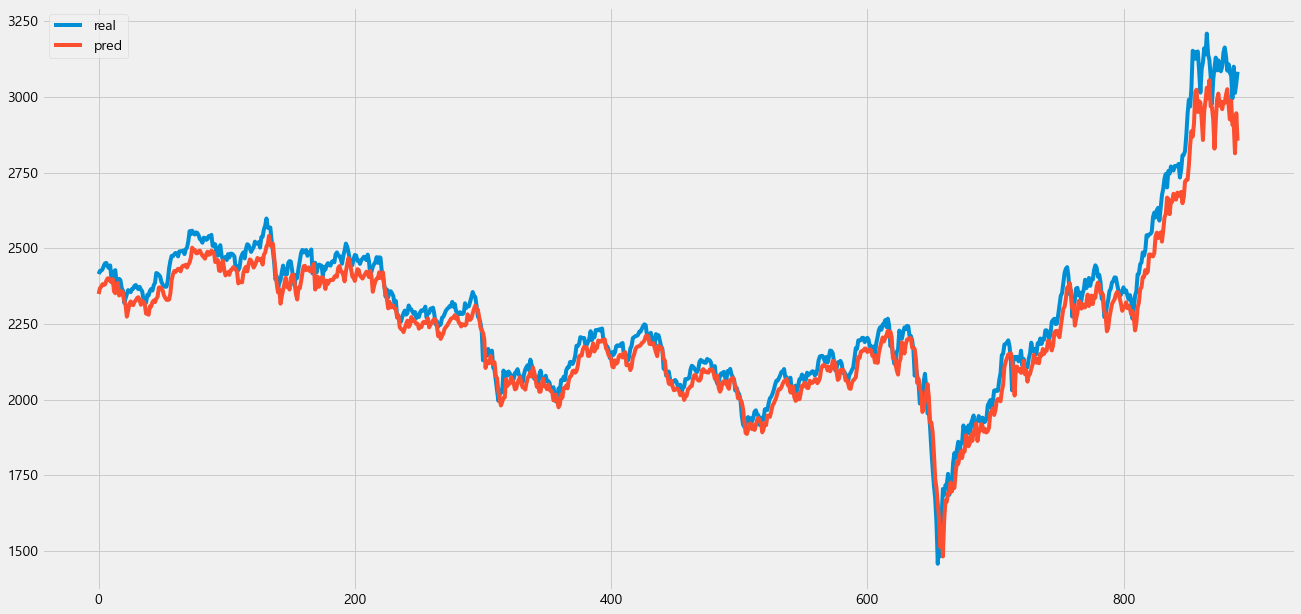

28/28 [==============================] - 0s 4ms/step - loss: 36.7406 - mae: 30.4748
(44.488, 29.9958, 0.9727849687939264)


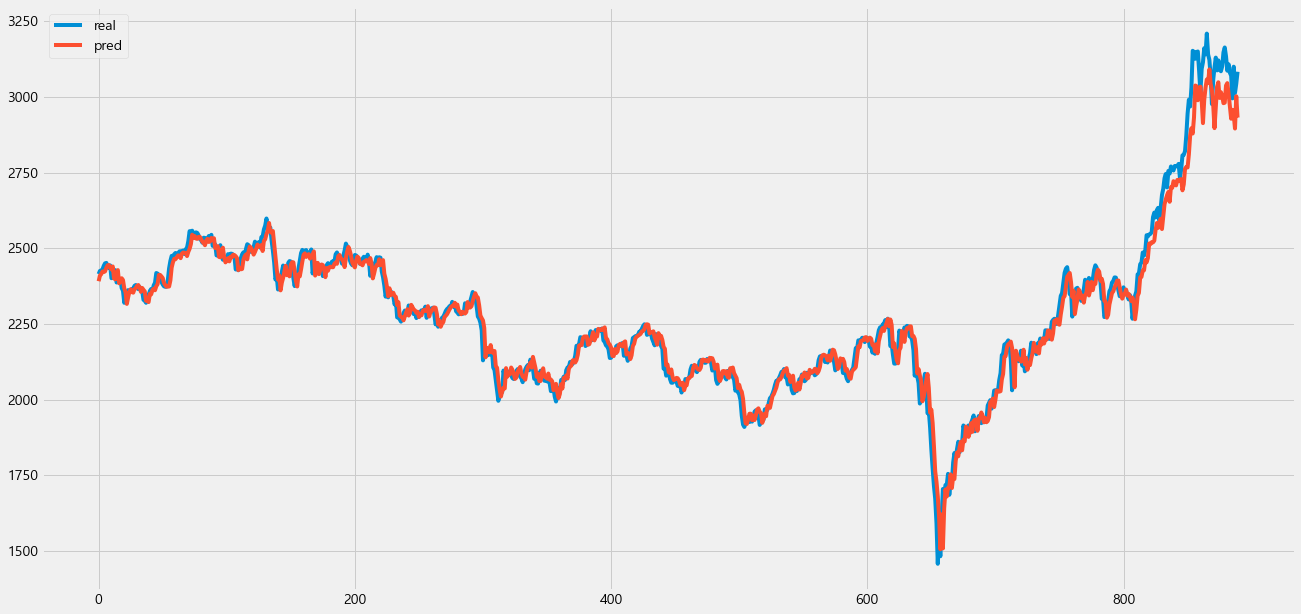

28/28 [==============================] - 1s 4ms/step - loss: 36.7061 - mae: 29.3267
(41.6649, 29.0534, 0.9761293400138732)


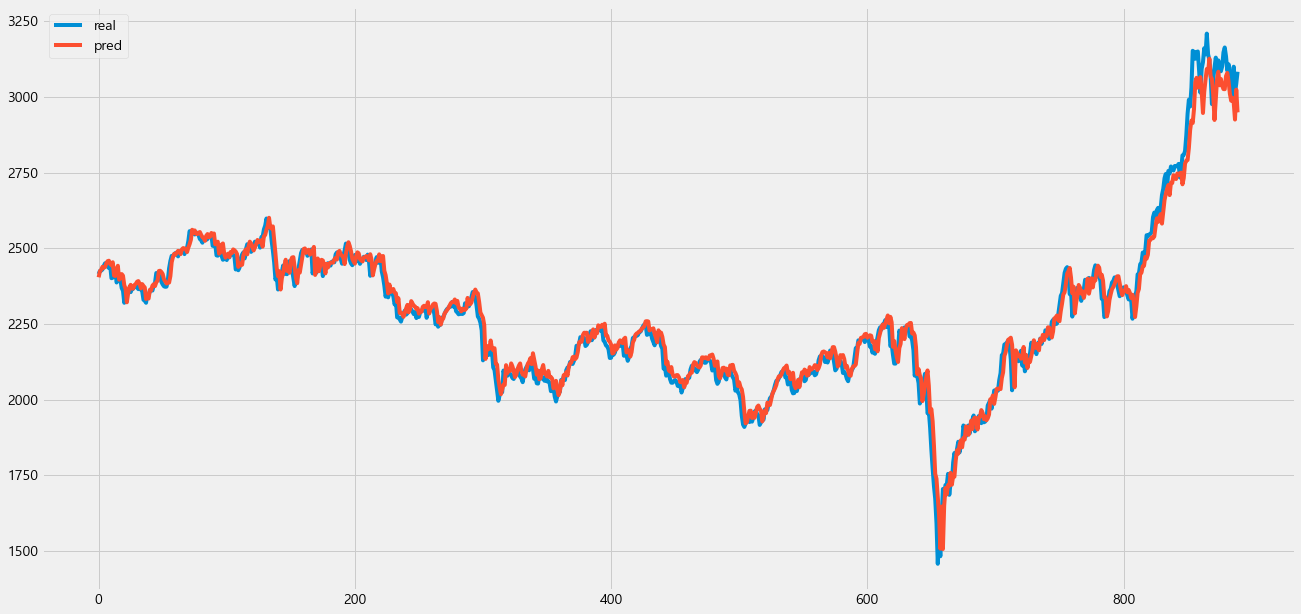

28/28 [==============================] - 0s 3ms/step - loss: 34.3751 - mae: 27.9390
(38.8481, 27.7629, 0.9792478419313122)


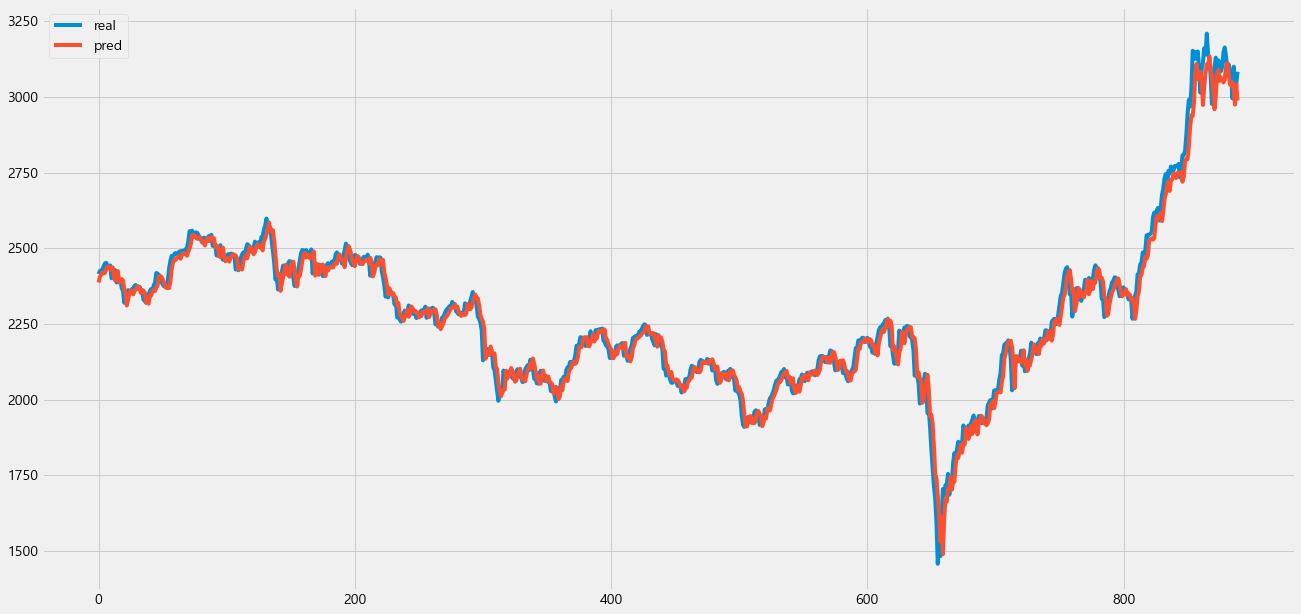

28/28 [==============================] - 0s 3ms/step - loss: 34.8045 - mae: 28.4877
(39.8082, 28.2529, 0.9782094022184661)


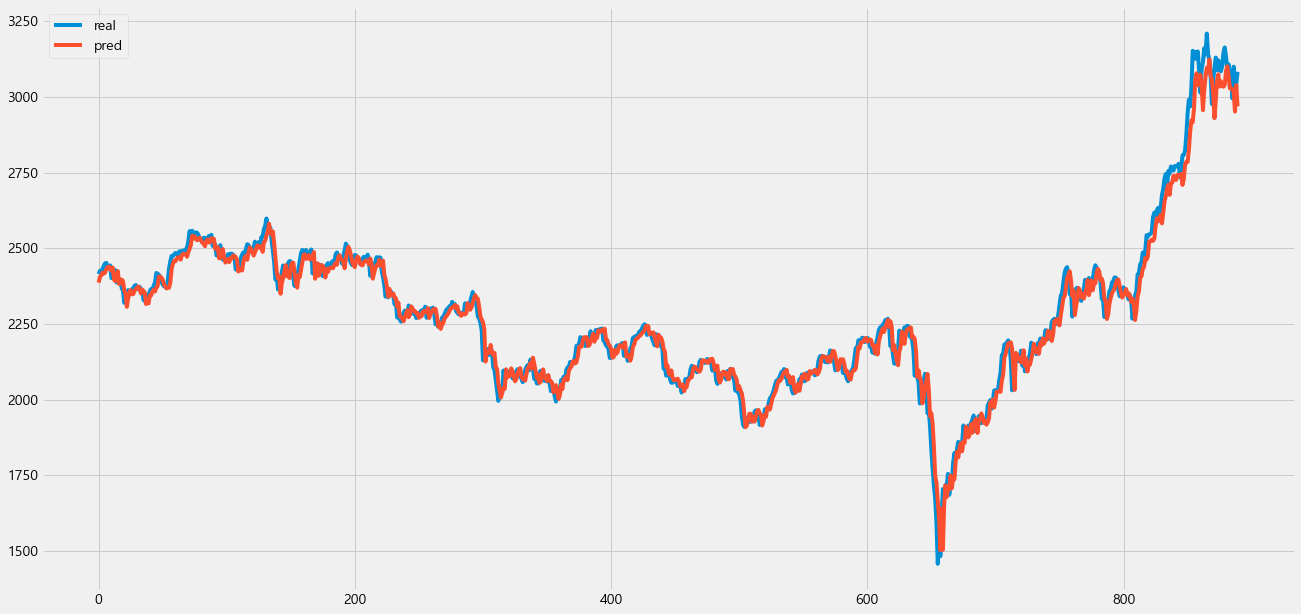

In [77]:
loss_list = []

for epoch, model in zip(epochs,model_list):
    model.evaluate(x_test, y_test)
    pred = model.predict(x_test)
    pred = np.squeeze(pred)

    actual = inverse_data(y_test, max_v, min_v)
    pred = inverse_data(pred, max_v, min_v)
    
    rmse, mae, r2 = get_loss(actual, pred)
    loss_list.append([epoch, rmse, mae, r2])
    print(get_loss(actual, pred))
    plt.plot(actual)
    plt.plot(pred)
    plt.legend(['real', 'pred'])
    plt.show()

In [78]:
loss_list

[[10, 45.395, 31.629, 0.971663926622164],
 [20, 54.3366, 39.3736, 0.9594015783589236],
 [30, 42.9217, 29.1445, 0.974667527103306],
 [40, 39.2993, 27.7055, 0.9787629871240218],
 [50, 42.0694, 28.9845, 0.9756636134393127],
 [60, 62.9656, 50.0977, 0.9454833088726178],
 [70, 44.488, 29.9958, 0.9727849687939264],
 [80, 41.6649, 29.0534, 0.9761293400138732],
 [90, 38.8481, 27.7629, 0.9792478419313122],
 [100, 39.8082, 28.2529, 0.9782094022184661]]